In [ ]:
install.packages("Metrics")  

In [1]:
library(astsa)
library(forecast)
library(Metrics)

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 

Attaching package: 'forecast'

The following object is masked from 'package:astsa':

    gas

Warning message:
"package 'Metrics' was built under R version 3.6.3"
Attaching package: 'Metrics'

The following object is masked from 'package:forecast':

    accuracy



En el presente trabajo desarrollaremos modelos econométricos y de aprendizaje automático para predecir los valores de consumo del producto blanco de mercado interno "Gasoil 50-S" en Uruguay para el período 2019 - 2020.

La serie histórica es mensual, y tiene inicio en Enero 2010. A los efectos de poder evaluar el ajuste de nuestras predicciones cortaremos la serie en diciembre 2018 y ajustaremos los modelos con los datos comprendidos en el período 2010 - 2018.

Los datos fueron obtenidos de la siguiente página oficial de Ancap:
https://www.ancap.com.uy/8887/1/informacion-historica.html

In [2]:
consumo <- read.csv("consumo.csv")

In [3]:
#consumo

In [4]:
consumo_2019_2020 = consumo[109:132,]
consumo_hasta_2018 = consumo[0:108,]

In [5]:
#consumo_2019_2020

In [6]:
#consumo_hasta_2018

In [7]:
valores_reales = consumo_2019_2020$consumo_miles_m3

In [8]:
options(repr.plot.width = 14, repr.plot.height = 6)

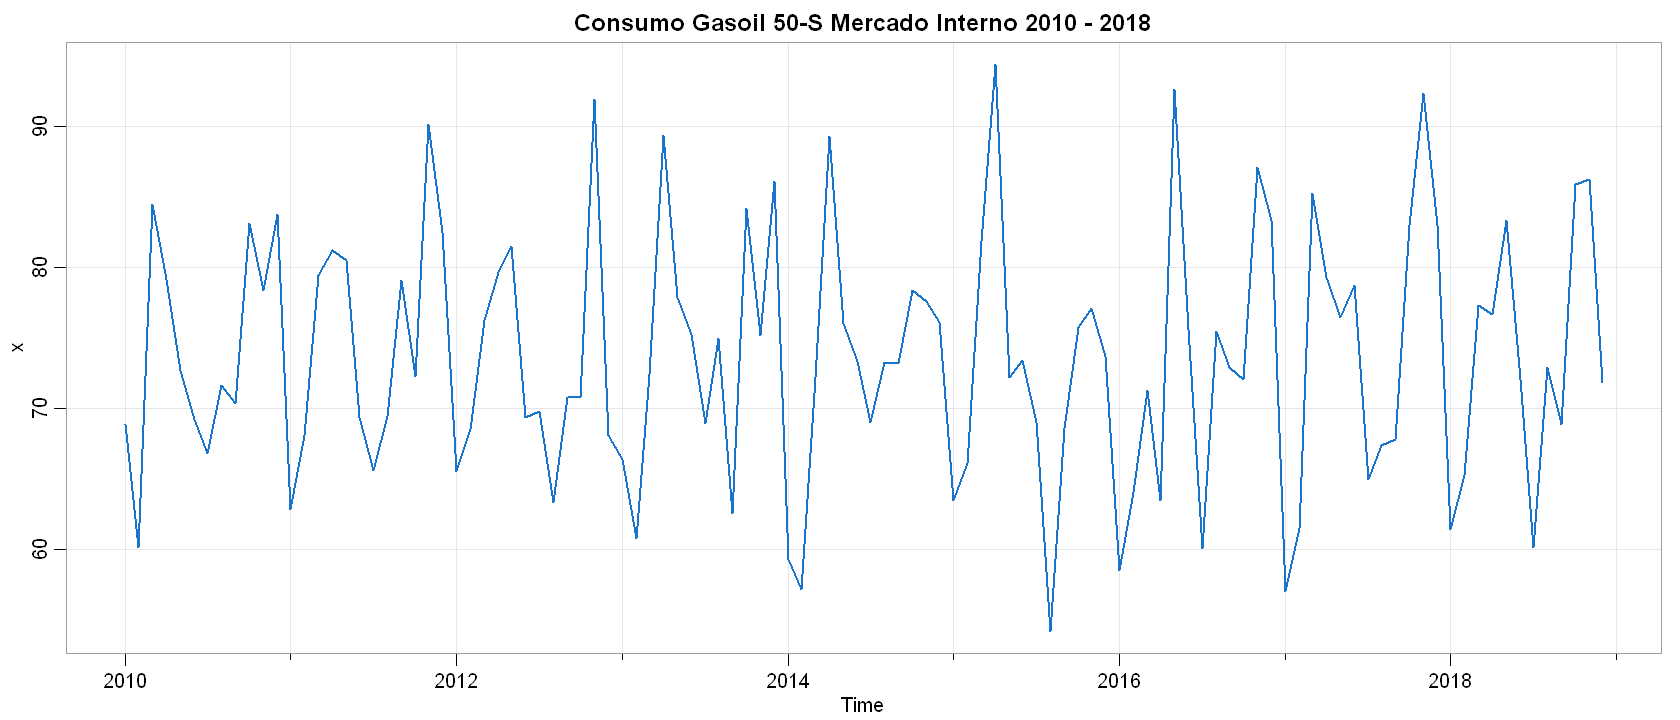

In [9]:
x = ts(consumo_hasta_2018$consumo_miles_m3, start = 2010, freq = 12)
tsplot(x, main = 'Consumo Gasoil 50-S Mercado Interno 2010 - 2018', col = 4, lwd = 2)

La serie pareceriera ser naturalmente bastante estacionaria, ya que no presenta tendencia alguna (su media parece ser constante en el tiempo) y lo mismo ocurre con su varianza. 

Dado que no se observa una tendencia en la serie, no tiene sentido diferenciarla, sin embargo, veremos que ocurre si le aplicamos logaritmo: 

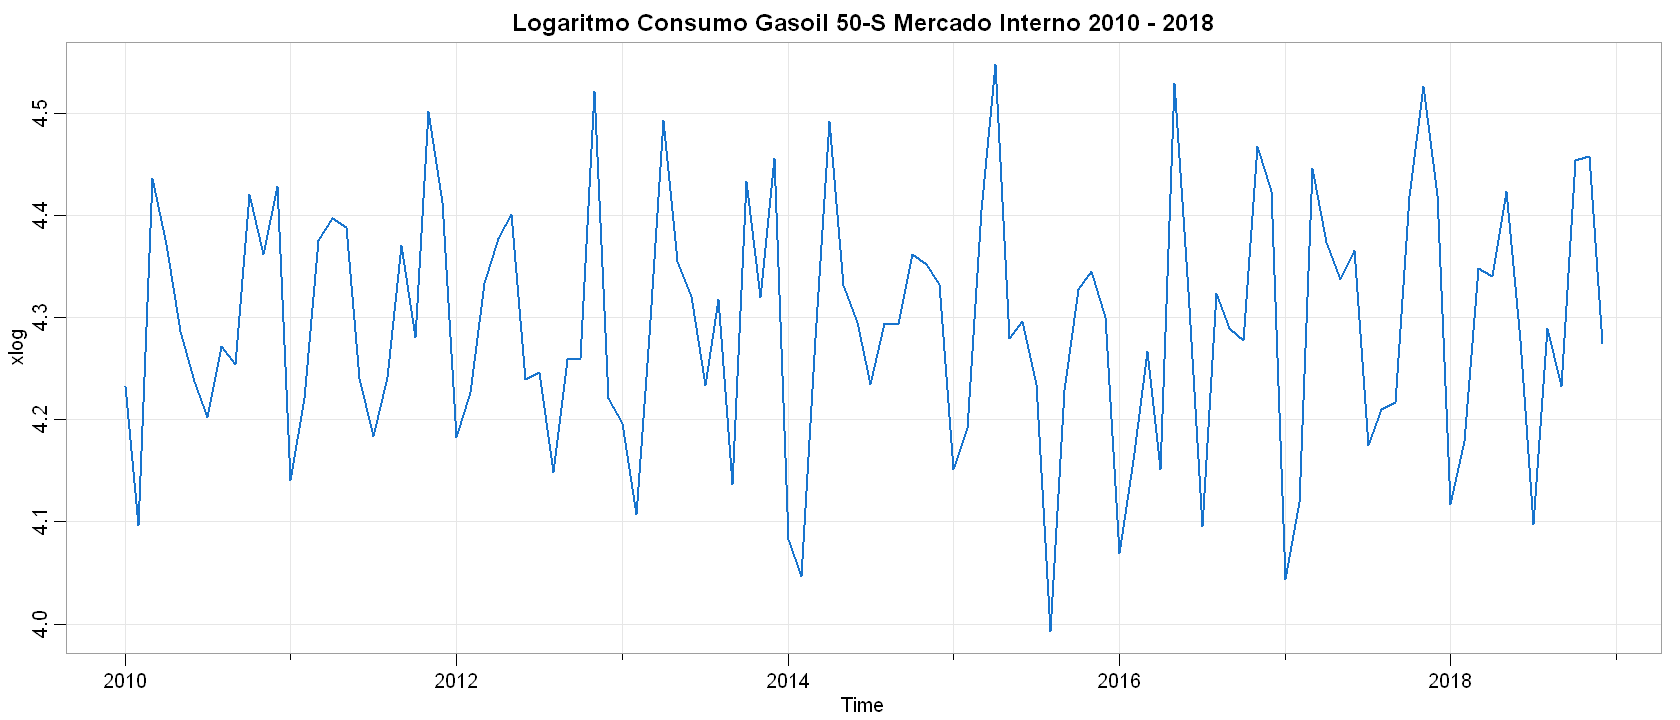

In [10]:
xlog = log(x)
tsplot(xlog, main = 'Logaritmo Consumo Gasoil 50-S Mercado Interno 2010 - 2018', col = 4, lwd=2)

Se verifica que el logaritmo de la serie no la suaviza (no empareja la serie ni le genera un efecto significativo). Por este motivo continuaremos trabajando con la serie original, pero centrada entorno al cero. Para ello le restaremos a la serie el promedio de los datos:

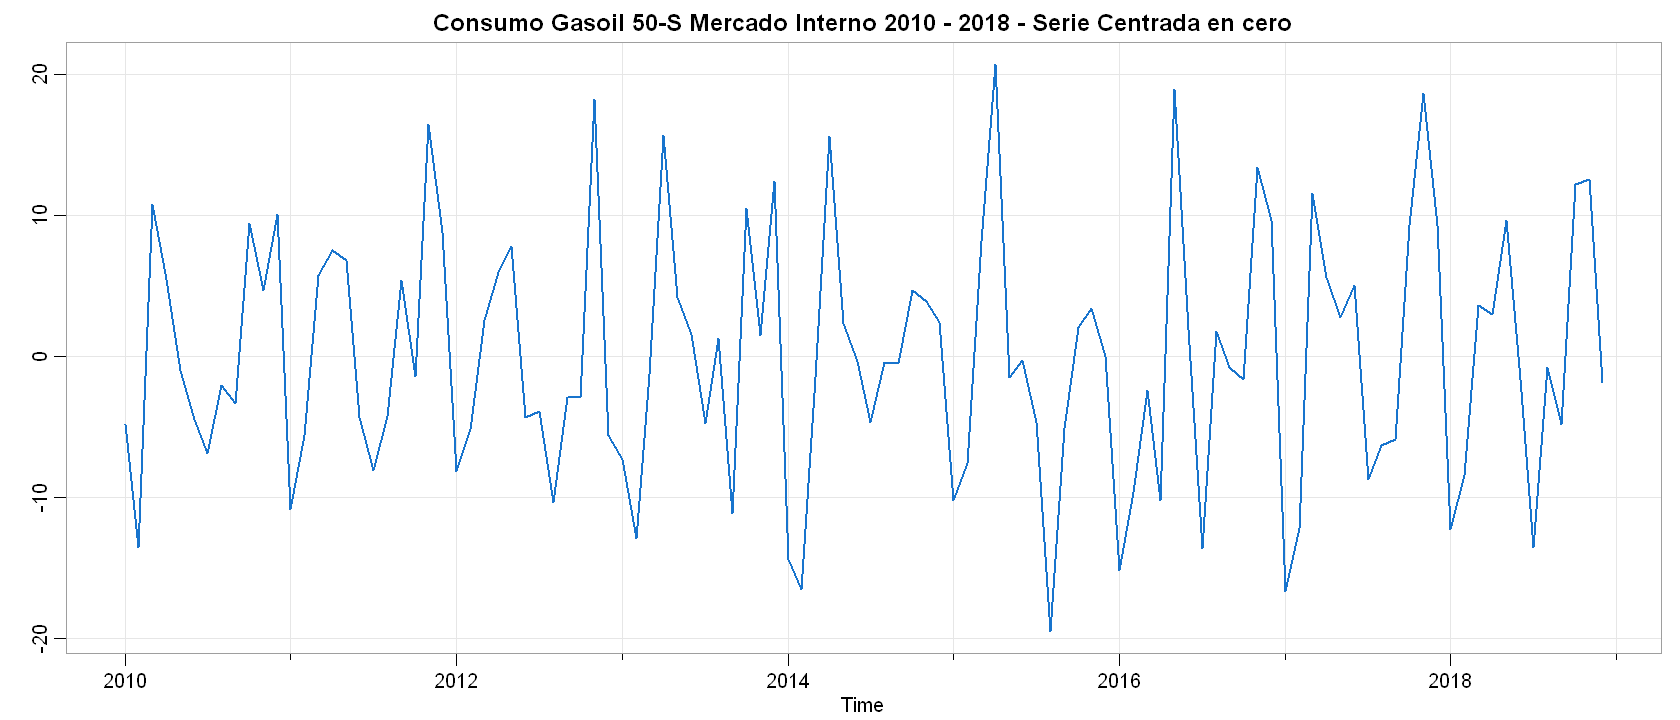

In [11]:
xmean = x-mean(x)
tsplot(xmean, ylab = '', main = 'Consumo Gasoil 50-S Mercado Interno 2010 - 2018 - Serie Centrada en cero', col = 4, lwd = 2)

A modo anecdótico buscaremos ajustarle a la serie una tendencia, y verificaremos que la misma no debería dar significativa:

In [12]:
time = time(xmean) - 2010
fit_time = lm(xmean ~ 0 + time)
summary(fit_time)


Call:
lm(formula = xmean ~ 0 + time)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.5750  -5.6100  -0.9088   5.5608  20.6250 

Coefficients:
     Estimate Std. Error t value Pr(>|t|)
time  0.01509    0.16478   0.092    0.927

Residual standard error: 8.836 on 107 degrees of freedom
Multiple R-squared:  7.838e-05,	Adjusted R-squared:  -0.009267 
F-statistic: 0.008388 on 1 and 107 DF,  p-value: 0.9272


Como esperabamos, al intentar ajustar un "trend", el mismo da NO significativo.

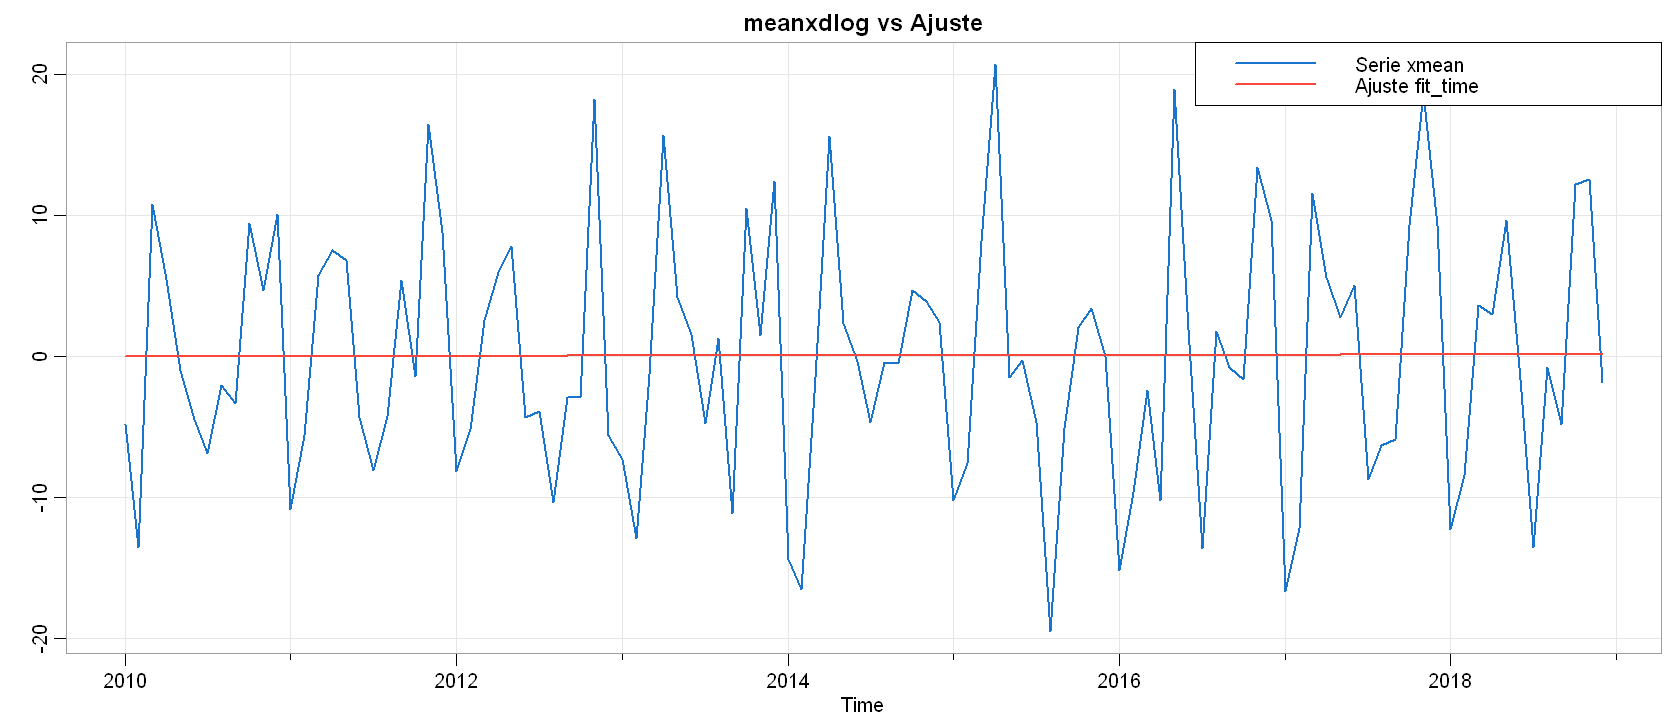

In [13]:
tsplot(xmean, main = "meanxdlog vs Ajuste", ylab = "", col = 4, lwd = 2)
ajuste_tendencia = ts(fitted(fit_time), start = 2010, frequency =12)
lines(ajuste_tendencia, col = 2, lwd = 2)

legend("topright", legend = c("Serie xmean", "Ajuste fit_time"), lwd = 2, col = c(4, 2))

El siguiente paso será analizar la autocorrelación de la serie:

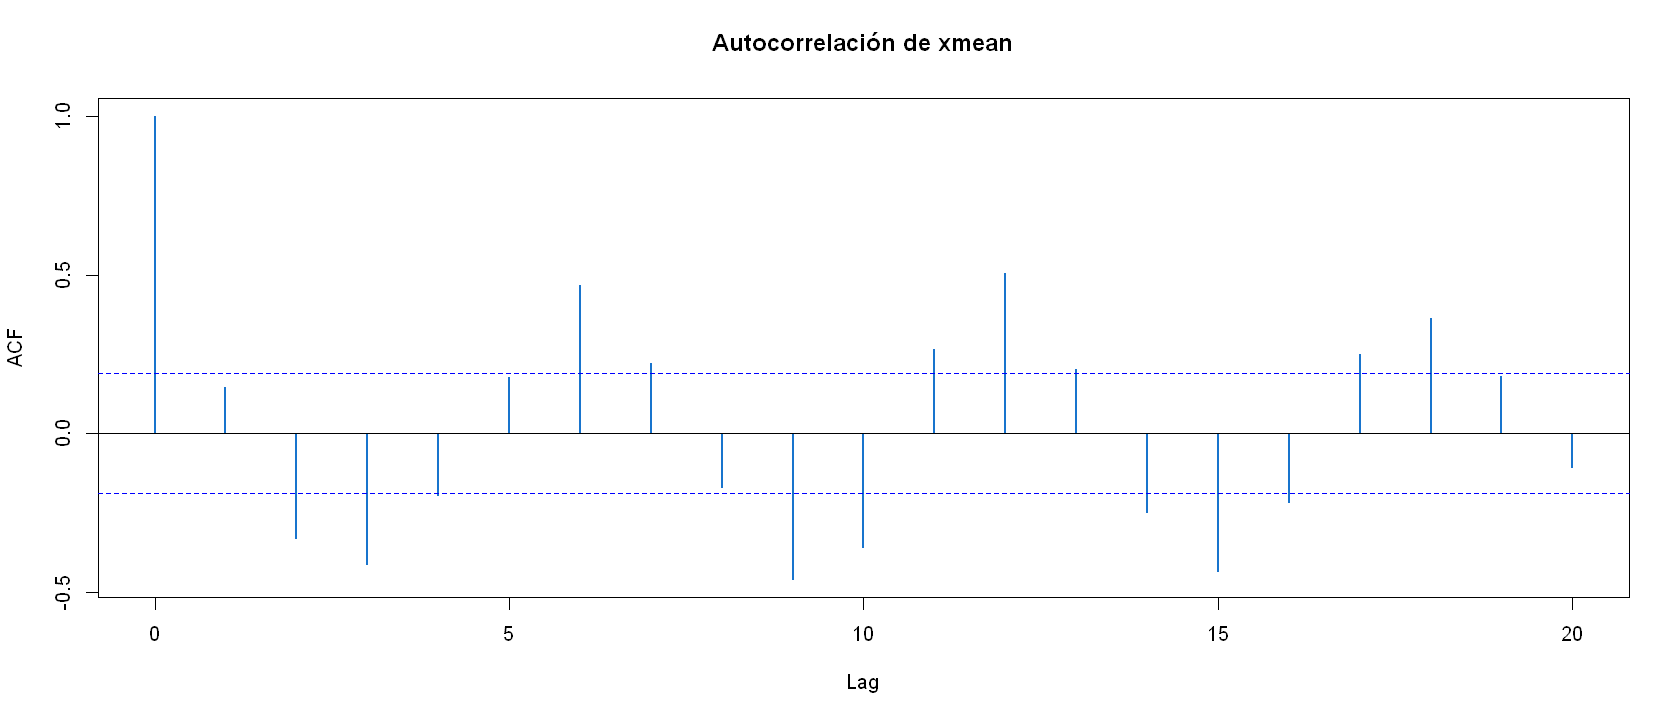

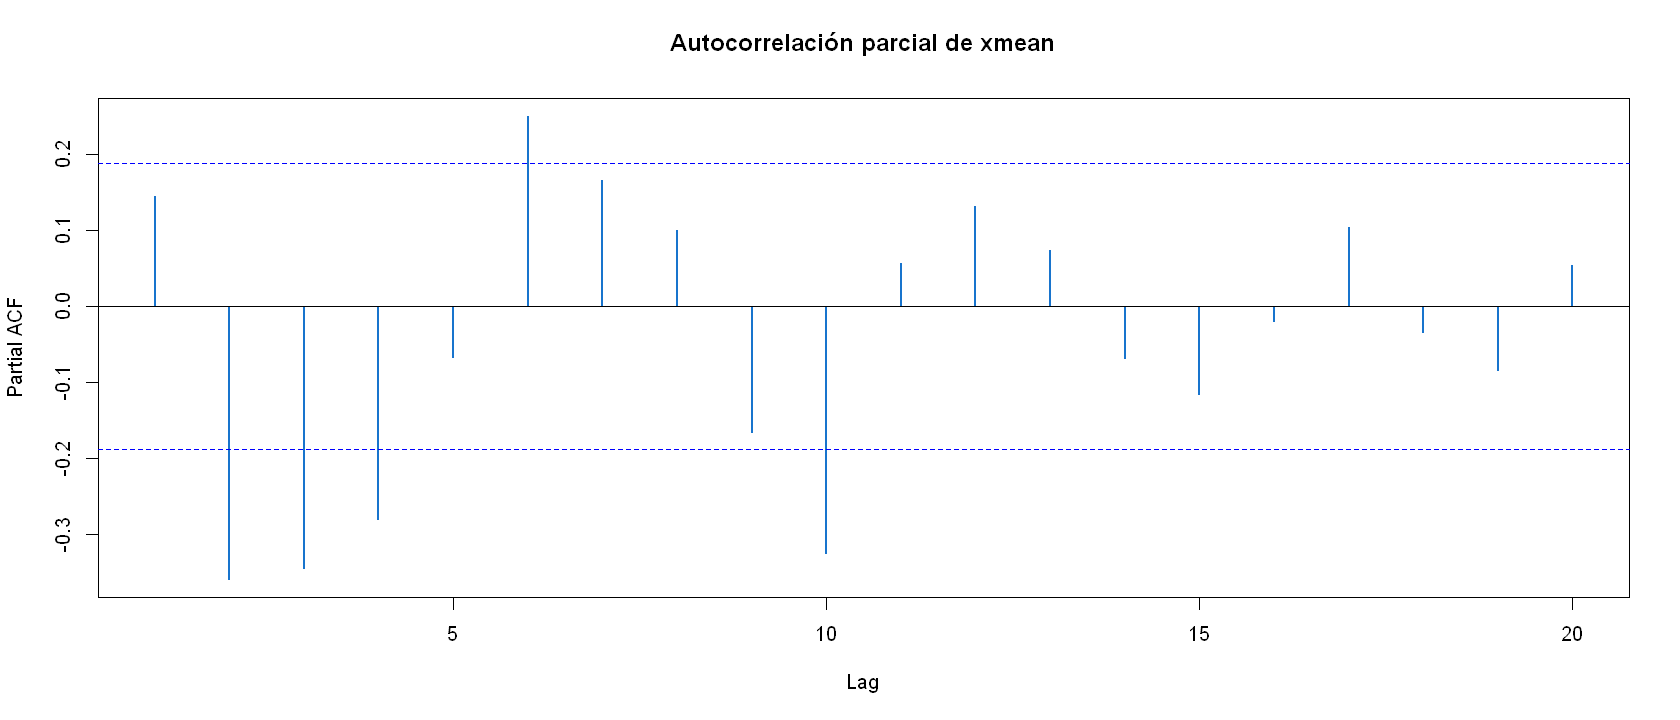

In [14]:
acf(ts(xmean), main = 'Autocorrelación de xmean', col = 4, lwd = 2)
pacf(ts(xmean), main = 'Autocorrelación parcial de xmean', col = 4, lwd = 2)

Conclusión: Observando la autocorrelación de la serie identificamos un componente sistemático de cierto período que debemos eliminar.

El estudio de la estacionalidad puede hacerse por factores, o por frecuencias conocidas de senos y cosenos.

Más específicamente, para hallar componentes periódicos en la señal, se utilizan frecuencias conocidas de senos y cosenos, mientras que para hallar componentes estacionales en la señal (cosas que ocurren cada cierto tiempo) se usan factores.

Por otro lado, el pacf de "xmean" es dificil de interpretar sin quitarle a la serie la parte oscilatoria.


Análisis de la estacionalidad mediante el uso de Factores:

In [15]:
season = factor(cycle(xmean))
t_factor = time(xmean) - 2010
fit_aux = lm(xmean ~ 0 + t_factor + season)
summary(fit_aux)


Call:
lm(formula = xmean ~ 0 + t_factor + season)

Residuals:
     Min       1Q   Median       3Q      Max 
-17.7281  -3.7319   0.0214   4.0522  13.5672 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
t_factor  -0.08255    0.21459  -0.385 0.701337    
season1  -10.76122    2.10250  -5.118 1.61e-06 ***
season2   -9.85346    2.10986  -4.670 9.89e-06 ***
season3    4.47887    2.11735   2.115 0.037019 *  
season4    8.04430    2.12496   3.786 0.000268 ***
season5    5.91985    2.13270   2.776 0.006633 ** 
season6   -0.40650    2.14056  -0.190 0.849791    
season7   -7.27662    2.14853  -3.387 0.001030 ** 
season8   -4.13385    2.15663  -1.917 0.058267 .  
season9   -2.84464    2.16484  -1.314 0.192005    
season10   5.08813    2.17317   2.341 0.021305 *  
season11  10.71812    2.18162   4.913 3.73e-06 ***
season12   5.44322    2.19017   2.485 0.014693 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.758 on 95 degrees of 

En este caso, dado que tendríamos que trabajar con muchas estaciones, optaremos por el uso de frecuencias conocidas de senos y cosenos, para lo cual se hará uso de un periodograma.


El periodograma nos dice que frecuencias correlacionan mejor. SI ponemos las frecuencias del periodograma en un linear model de senos y cosenos hará un ajuste para encontrar la componente periódica que mejor ajuste:

Utilizaremos por lo tanto frecuencias conocidas de la forma:

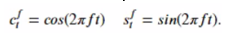

Recordamos que para que el periodograma funcione debemos realizar los siguientes pasos: 

-Centrar la serie histórica en cero: Esto lo efectuamos al restarle la media

-Quitarle cualquier tendencia que tenga: La serie original "x", ya naturalmente no presentaba ninguna tendencia

Haremos el periodograma con la serie original pero centrada, es decir, con "xmean". Por este motivo no centraremos "s". El objetivo es encontrar componentes periódicas sistemáticas.

Análisis de la estacionalidad mediante el uso de un periodograma:

In [16]:
s = as.numeric(xmean)

n = length(s)
I = 4/n*abs(fft(s))^2/n
I = I[1:floor(n/2)]
f = (0:(n/2-1))/n*12

#cantidad de muestras por año = 12

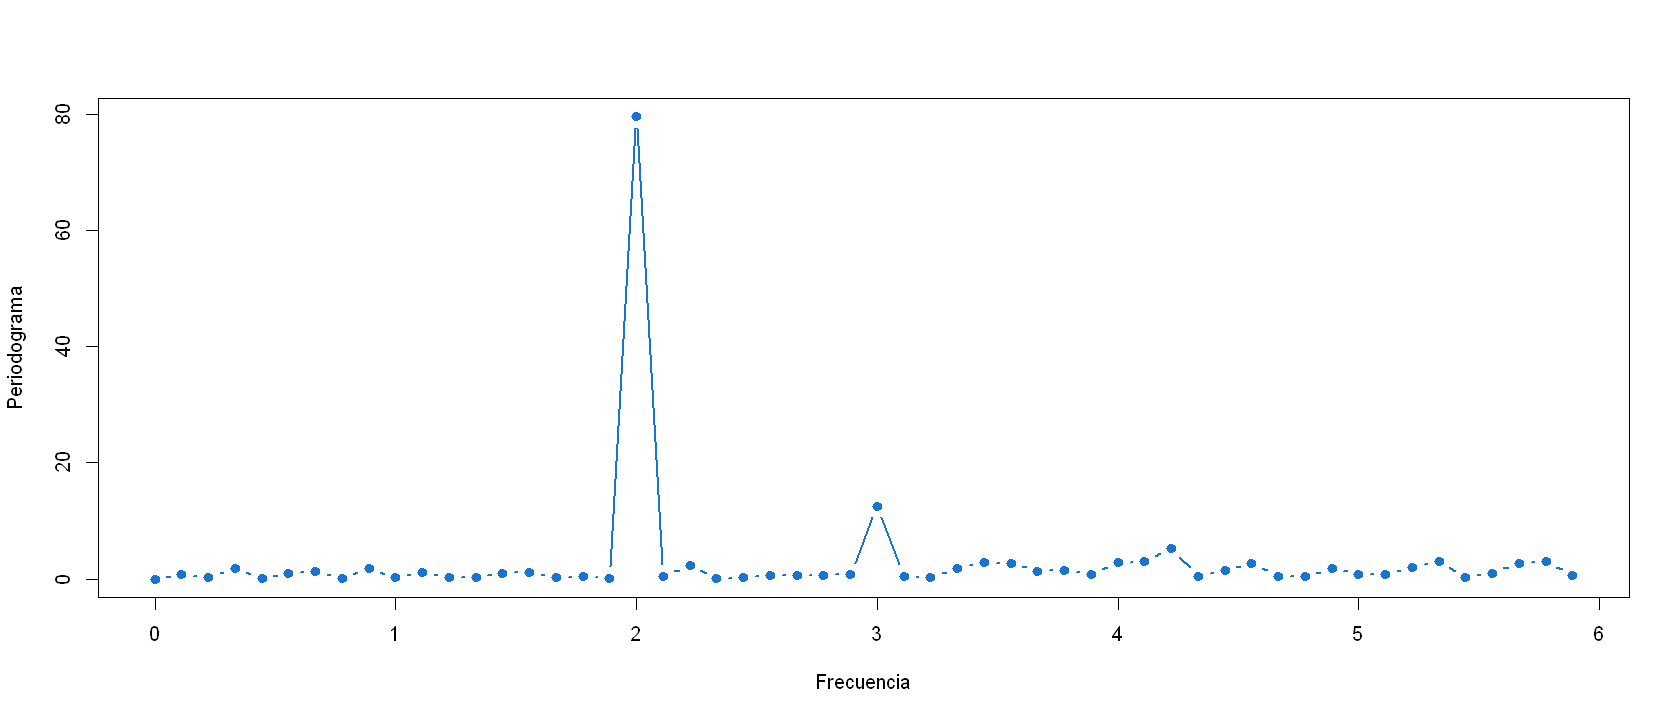

In [17]:
plot(f, I, type = "b", xlab = "Frecuencia", ylab = "Periodograma", col = 4, lwd = 2, pch = 19 )

Ajuste en base al periodograma:

In [18]:
fit_p1 = lm(xmean ~ 0 + cos(2*pi*(2)*time) + sin(2*pi*(2)*time) + cos(2*pi*(3)*time) + sin(2*pi*(3)*time))
summary(fit_p1)


Call:
lm(formula = xmean ~ 0 + cos(2 * pi * (2) * time) + sin(2 * pi * 
    (2) * time) + cos(2 * pi * (3) * time) + sin(2 * pi * (3) * 
    time))

Residuals:
     Min       1Q   Median       3Q      Max 
-20.0705  -3.6434   0.1463   4.3196  13.5869 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)    
cos(2 * pi * (2) * time)  -7.4567     0.7756  -9.614 4.91e-16 ***
sin(2 * pi * (2) * time)  -4.8996     0.7756  -6.317 6.71e-09 ***
cos(2 * pi * (3) * time)  -2.5942     0.7756  -3.345  0.00115 ** 
sin(2 * pi * (3) * time)  -2.4140     0.7756  -3.112  0.00240 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.7 on 104 degrees of freedom
Multiple R-squared:  0.5957,	Adjusted R-squared:  0.5801 
F-statistic:  38.3 on 4 and 104 DF,  p-value: < 2.2e-16


Como se puede observar, en el ajuste "fit_p1" quitamos el Intercept ya que la serie que estamos ajustando tiene restado el promedio de los datos.

Tampoco utilizamos la componente "time" porque vimos que el trend no es significativo.

Consideramos una frecuencia semestral (de dos ciclos por año) y otra cuatrimestral (de tres ciclos por año). Tales frecuencias fueron obtenidas a partir del periodograma, que nos permitió observar que dentro de la serie analizada están todos estos ciclos combinados. Estas frecuencias componen además un ciclo anual, ya que el año es un múltiplo de ambas.

Vamos a comparar este resultado, con un ajuste realizado con una única estacionalidad (o sea, con un ciclo anual o frecuencia 1), para observar el real beneficio de haber efectuado un periodograma:

In [20]:
fit_p_f1 = lm(xmean ~ 0 + cos(2*pi*(1)*time) + sin(2*pi*(1)*time))
summary(fit_p_f1)


Call:
lm(formula = xmean ~ 0 + cos(2 * pi * (1) * time) + sin(2 * pi * 
    (1) * time))

Residuals:
    Min      1Q  Median      3Q     Max 
-19.137  -5.780  -0.539   5.626  20.785 

Coefficients:
                         Estimate Std. Error t value Pr(>|t|)
cos(2 * pi * (1) * time)  0.45504    1.20736   0.377    0.707
sin(2 * pi * (1) * time) -0.08126    1.20736  -0.067    0.946

Residual standard error: 8.872 on 106 degrees of freedom
Multiple R-squared:  0.001381,	Adjusted R-squared:  -0.01746 
F-statistic: 0.07329 on 2 and 106 DF,  p-value: 0.9294


Efectivamente, al ver el ajuste anterior de un único ciclo anual, observamos que el R cuadrado es muy bajo (el obtenido en fit_p1 fue de aproximadamente 0.5957%, mientras que el obtenido en este caso fue de apenas 0.001381%), y que además ninguno de los coeficientes dio significativo

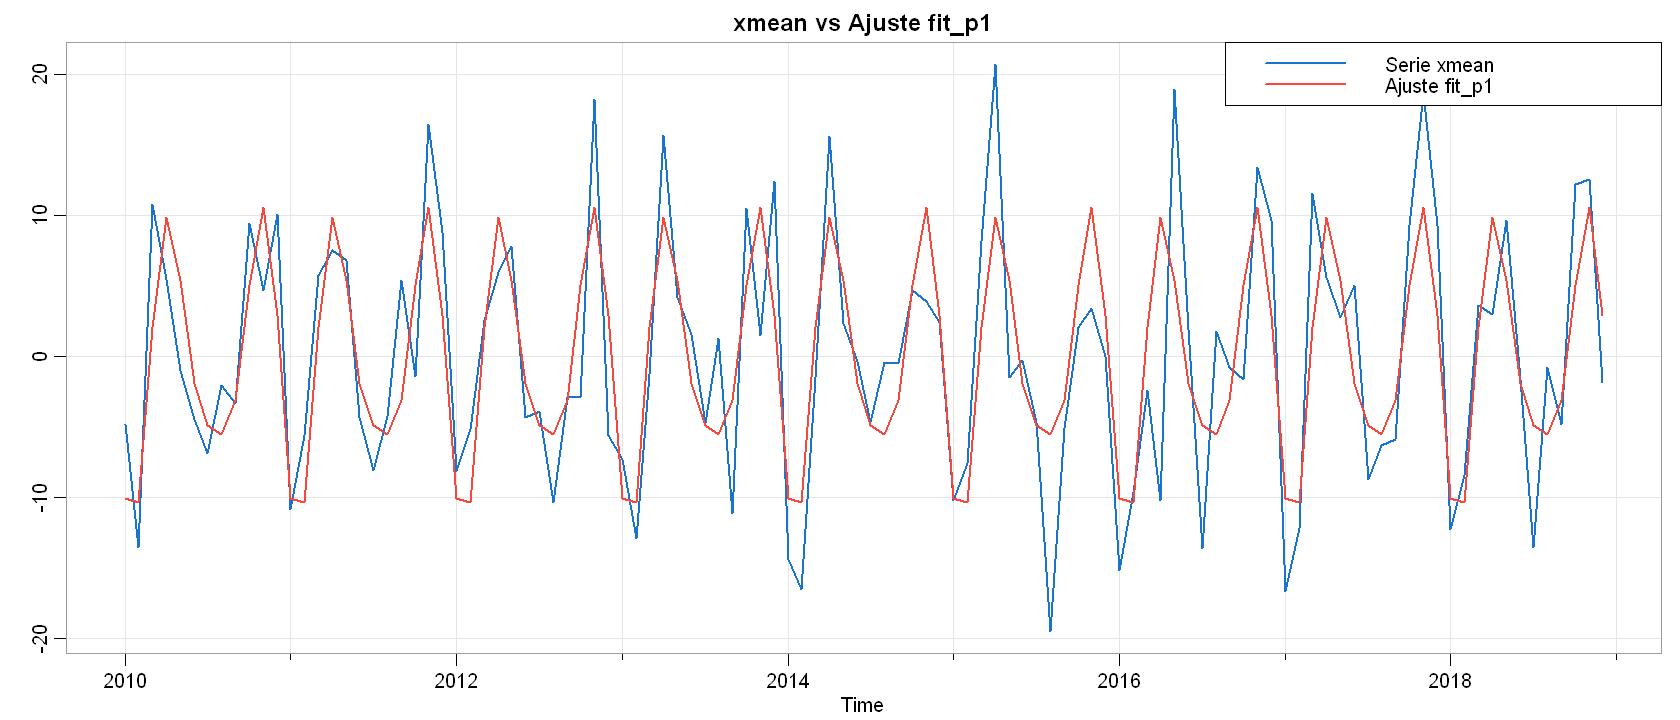

In [21]:
tsplot(ts(xmean, start = 2010, frequency = 12), col = 4, lwd = 2, main = 'xmean vs Ajuste fit_p1', ylab = "")
ajuste_estacionalidad = ts(fitted(fit_p1), start = 2010, frequency = 12)
lines(ajuste_estacionalidad, col = 2, lwd = 2)

legend("topright", legend = c("Serie xmean", "Ajuste fit_p1"), lwd = 2, col = c(4, 2))

RMSE para el ajuste fit_p1 sobre la serie "xmean":

In [22]:
RMSE_pred_deterministica = sd(residuals(fit_p1))
RMSE_pred_deterministica

# DUDA, NO DEBERIA DAR LO MISMO QUE HACER rmse(xmean, ajuste_estacionalidad)

[1] 5.619135

In [23]:
rmse(xmean, ajuste_estacionalidad)

[1] 5.59306

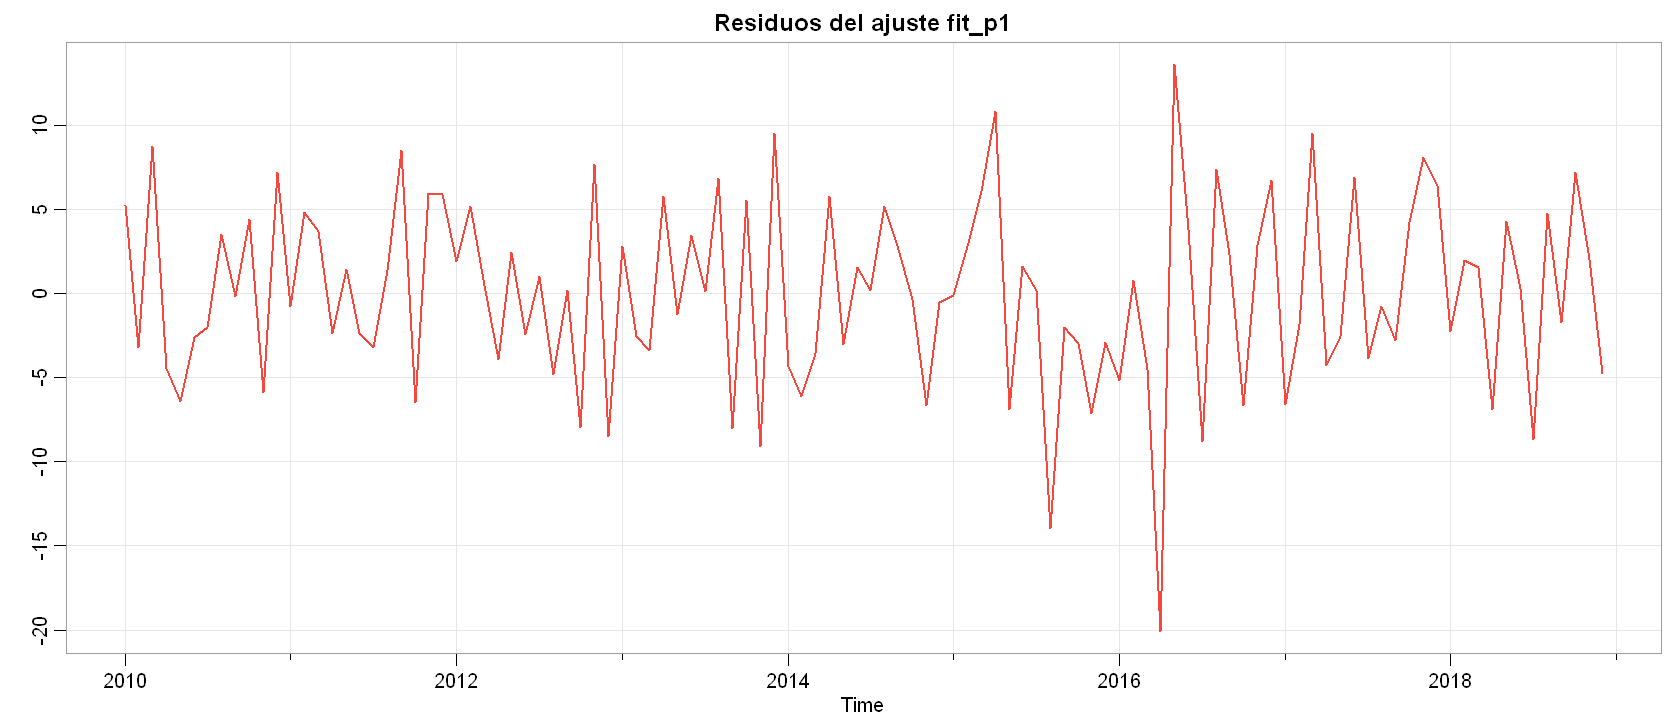

In [24]:
res_p = ts(residuals(fit_p1), start = 2010, freq = 12)
tsplot(res_p, col = 2, lwd = 2, ylab = '', main = 'Residuos del ajuste fit_p1')


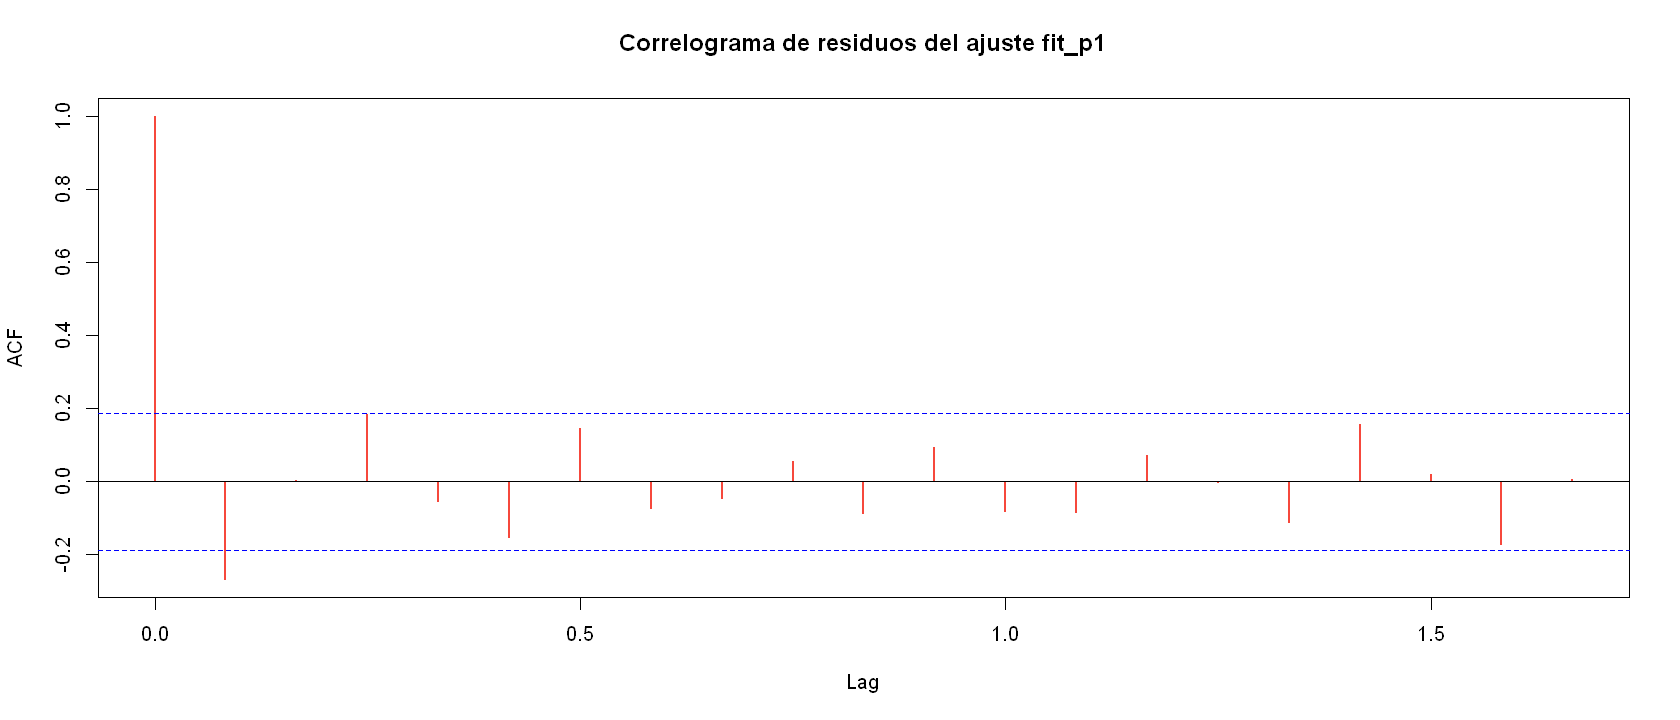

In [25]:
acf(res_p, col = 2, lwd = 2, main = 'Correlograma de residuos del ajuste fit_p1')

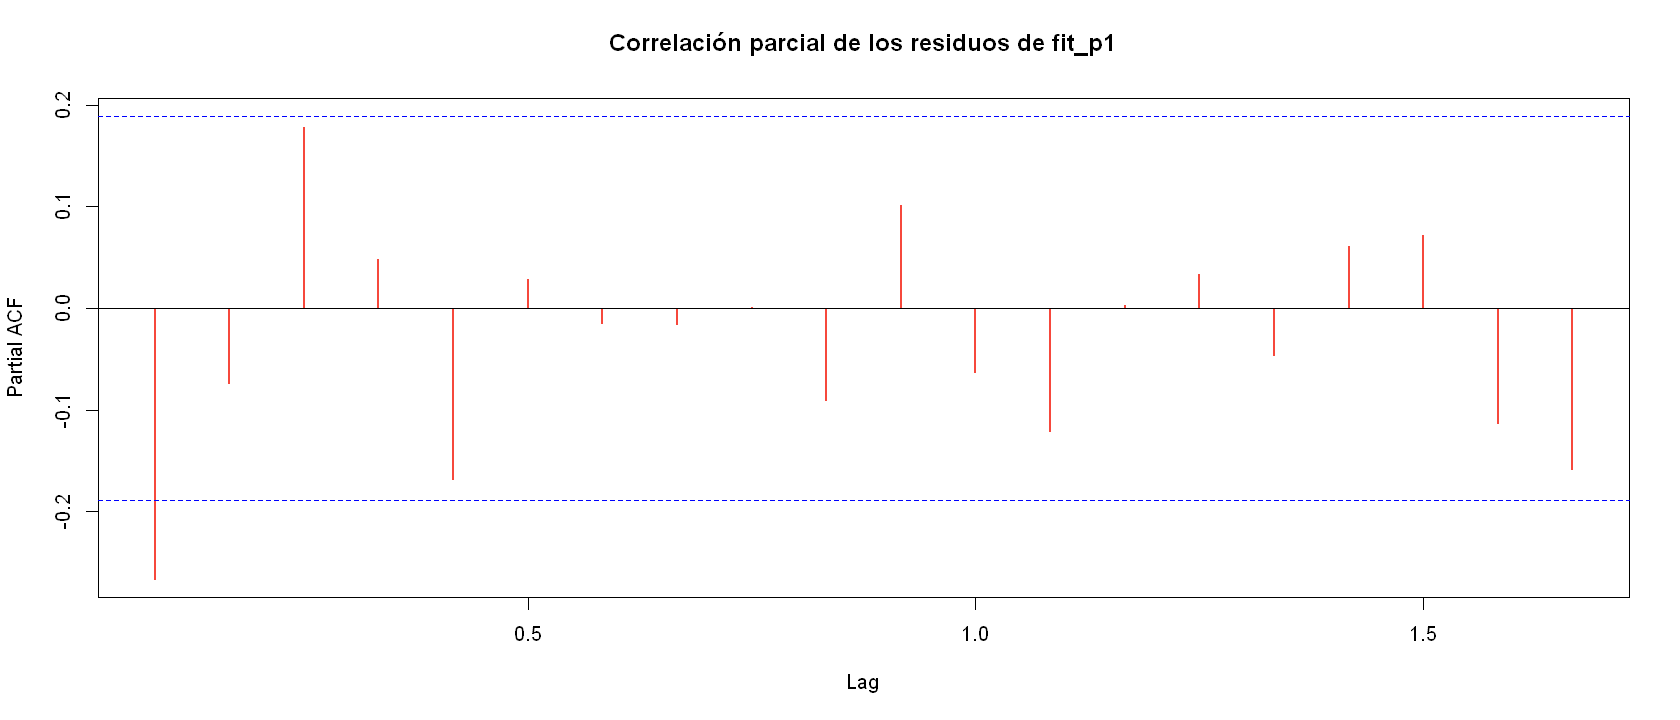

In [26]:
pacf(res_p, col = 2, lwd = 2, main = 'Correlación parcial de los residuos de fit_p1')

En el PACF de los residuos obtenidos por el ajuste fit_p1, observamos un único signo negativo en la primer barra. Lo que estamos obteniendo es casi un ruido blanco. Podemos concluir que estamos hablando de un AR (1) de coeficiente negativo y menor dependencia.

Verificaremos esto construyendo un qqplot y un histograma que debería quedar en forma de campana:

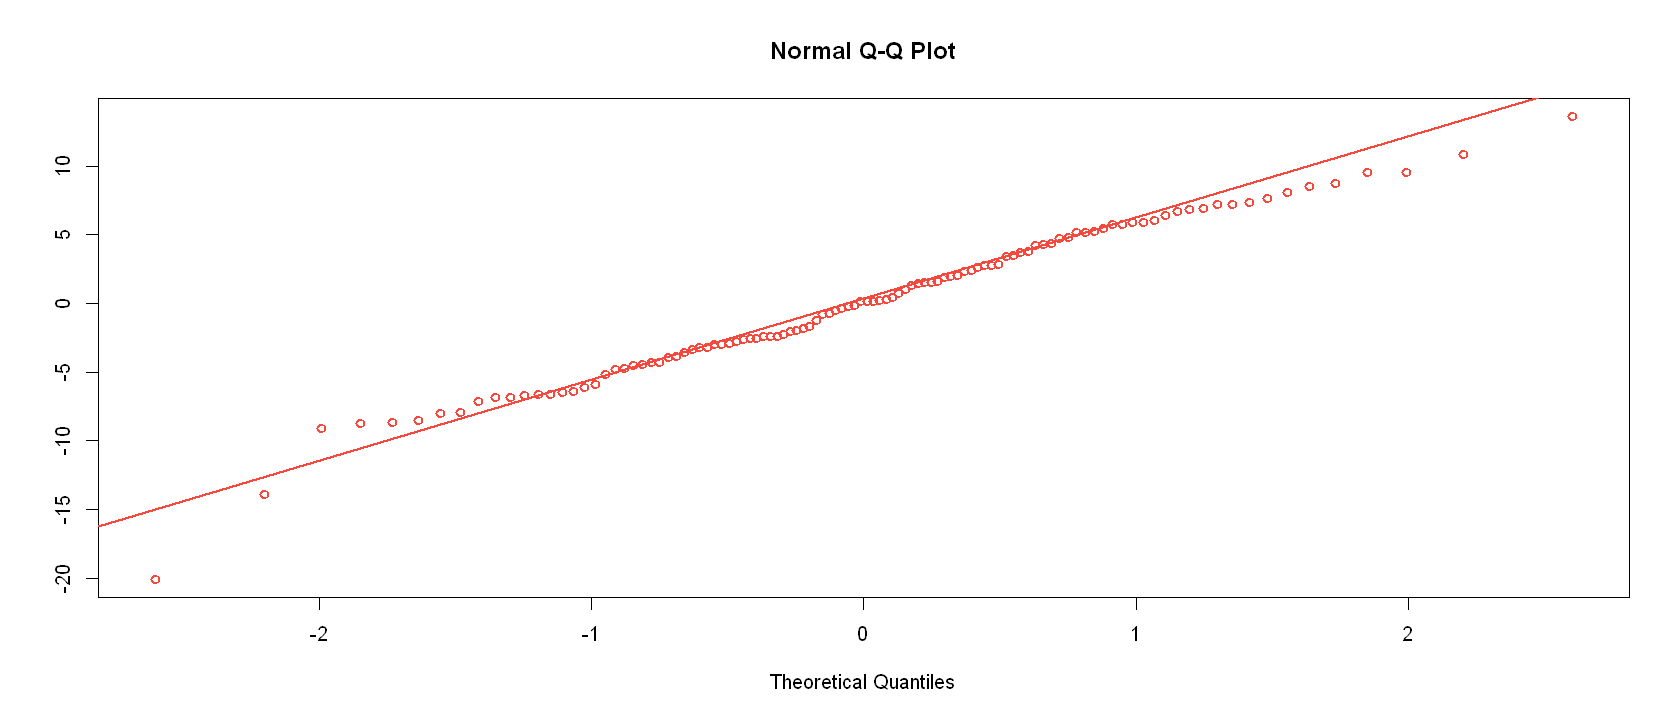

In [27]:
qqnorm(residuals(fit_p1), ylab = '', col = 2,lwd = 2)
qqline(residuals(fit_p1), col = 2,lwd = 2)

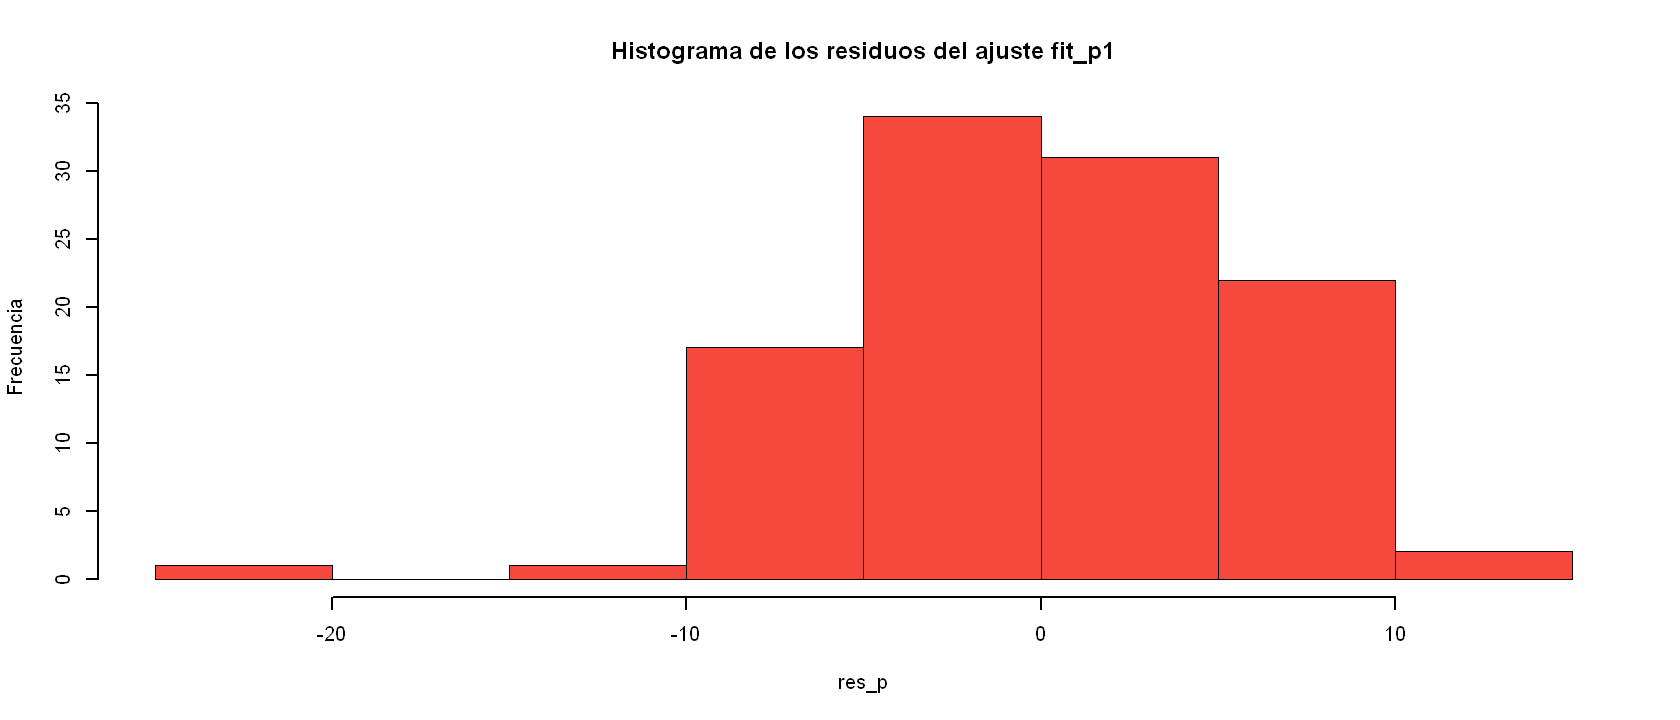

In [28]:
hist(res_p, col = 2, lwd = 2, ylab = 'Frecuencia', main = 'Histograma de los residuos del ajuste fit_p1')

CALCULO DE PREDICCIONES DETERMINISTICAS QUE CONSIDERAN LAS FRECUENCIAS DE SENOS Y COSENOS (ajuste fit_p1):

In [29]:
#Agregamos tiempos para 2 años en el futuro. Notar el -2010 para que quede igual que la que ajustamos.
new_t = seq(2019, 2020.95, by = 1/12) - 2010
new_t

[1]  9.000000  9.083333  9.166667  9.250000  9.333333  9.416667  9.500000
 [8]  9.583333  9.666667  9.750000  9.833333  9.916667 10.000000 10.083333
[15] 10.166667 10.250000 10.333333 10.416667 10.500000 10.583333 10.666667
[22] 10.750000 10.833333 10.916667

In [30]:
#Predecimos sobre los nuevos datos:
new_data = data.frame(time = new_t)
pred_sc = predict(fit_p1, new_data);
pred_sc

1          2          3          4          5          6          7 
-10.050917 -10.385556   2.079398   9.870769   5.377333  -1.899250  -4.862546 
         8          9         10         11         12         13         14 
 -5.557481  -3.108972   5.042694  10.565704   2.928824 -10.050917 -10.385556 
        15         16         17         18         19         20         21 
  2.079398   9.870769   5.377333  -1.899250  -4.862546  -5.557481  -3.108972 
        22         23         24 
  5.042694  10.565704   2.928824

In [31]:
#Convertimos el resultado en un formato de serie temporal
pred_sc = ts(pred_sc, start = 2019, freq = 12)
pred_sc

ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,-10.050917,-10.385556,2.079398,9.870769,5.377333,-1.899250,-4.862546,-5.557481,-3.108972,5.042694,10.565704,2.928824
2020,-10.050917,-10.385556,2.079398,9.870769,5.377333,-1.899250,-4.862546,-5.557481,-3.108972,5.042694,10.565704,2.928824


Observamos que las predicciones son iguales para el 2019 y 2020. Este comportamiento era esperable, y se debe a que estamos hablando de predicciones anuales periódicas de senos y cosenos que no tienen una tendencia.

A continuación veremos que el ajuste graficado en color rojo siempre llega a la misma altura todos los años. En otras palabras, estamos haciendo el ajuste por una función que se repite anualmente.

Se podría argumentar que hay alguna cambio en la varianza de la serie histórica en torno al año 2015/2016, pero luego vuelve al a normalidad. Por ende nuestro ajuste parece estar capturando toda la información de lo que pasará. El resto es ruido.

En contrapartida, como tenemos pocos datos la estimación de la varianza y los intervalos de confianza quedan un tanto grande.

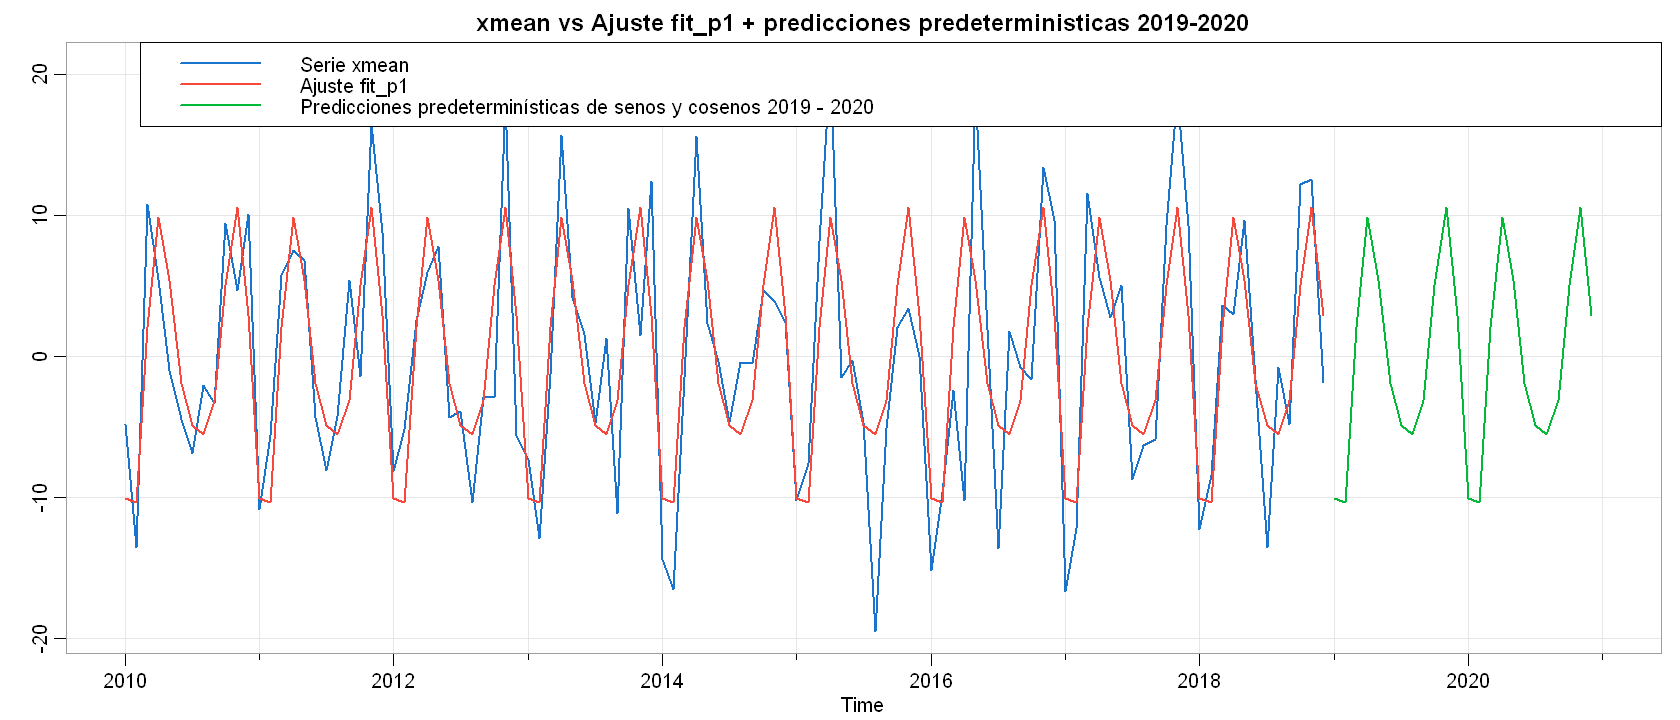

In [32]:
tsplot(ts(xmean, start = 2010, frequency = 12), xlim = c(2010,2021), ylab = '', main = 'xmean vs Ajuste fit_p1 + predicciones predeterministicas 2019-2020', lwd = 2, col = 4)
lines(ajuste_estacionalidad, col = 2, lwd = 2)
lines(pred_sc, lwd = 2, col = 3)

legend("topright", legend = c("Serie xmean", "Ajuste fit_p1", "Predicciones predeterminísticas de senos y cosenos 2019 - 2020"), lwd = 2, col = c(4, 2, 3))

RETORNO A LA VARIABLE ORIGINAL PARA LAS PREDICCIONES PREDETERMINISTICAS:

Agregamos la media al ajuste por estacionalidad y a nuestras predicciones predeterminísticas, ya que a la serie original le habiamos restado el promedio de los datos para realizar los cálculos.


In [33]:
ajuste_original = mean(x) + ajuste_estacionalidad
pred_original = mean(x) + pred_sc

ajuste_original = ts(ajuste_original, start = 2010, frequency = 12)
pred_original = ts(pred_original, start = 2019, frequency = 12)

pred_original



ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,63.65582,63.32119,75.78614,83.57751,79.08407,71.80749,68.84419,68.14926,70.59777,78.74944,84.27244,76.63556
2020,63.65582,63.32119,75.78614,83.57751,79.08407,71.80749,68.84419,68.14926,70.59777,78.74944,84.27244,76.63556


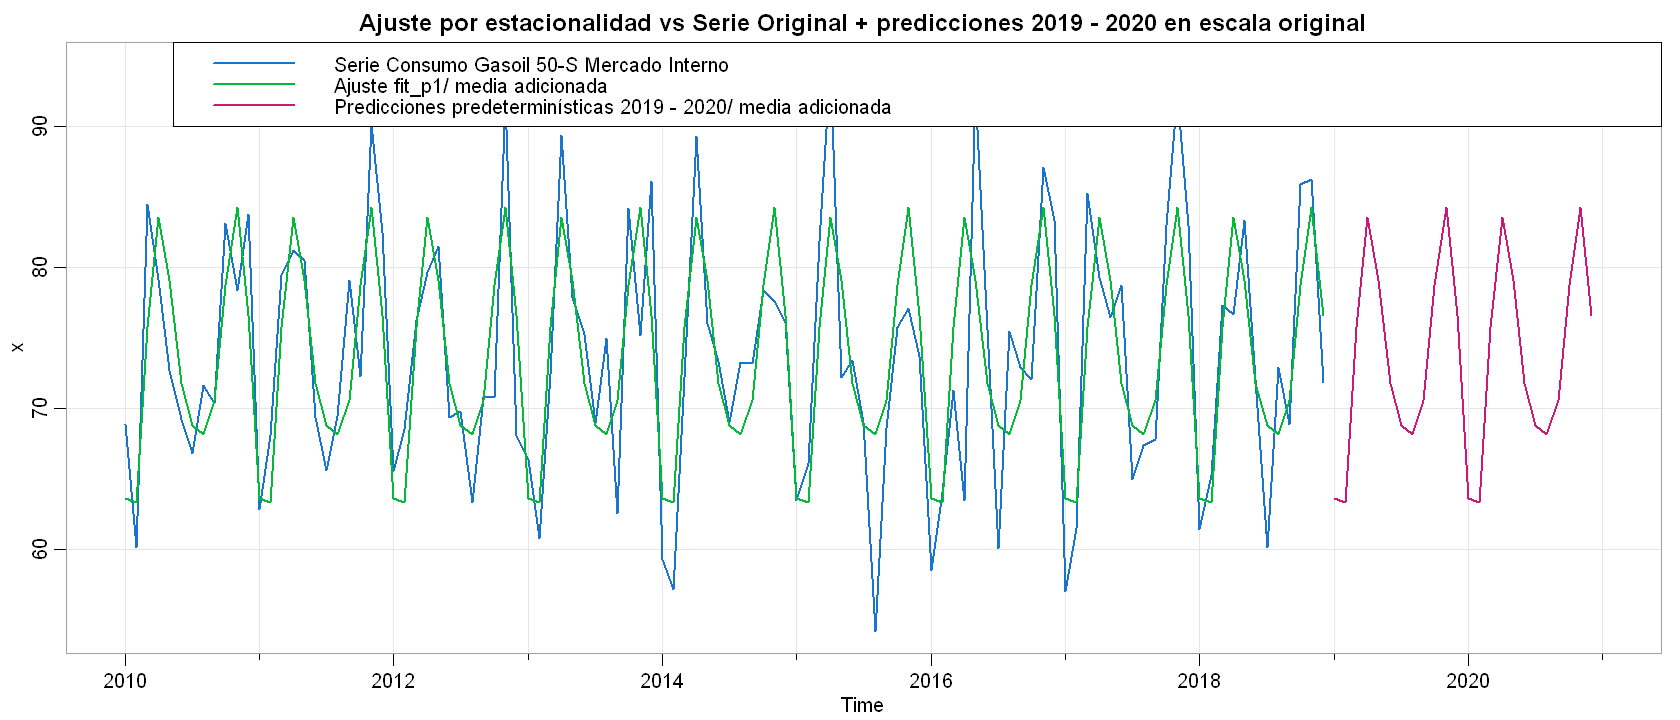

In [34]:
tsplot(x, xlim = c(2010,2021), main = 'Ajuste por estacionalidad vs Serie Original + predicciones 2019 - 2020 en escala original', col = 4, lwd = 2)
lines(ajuste_original, col = 3, lwd = 2)
lines(pred_original, col = 6, lwd = 2)

legend("topright", legend = c("Serie Consumo Gasoil 50-S Mercado Interno", "Ajuste fit_p1/ media adicionada", "Predicciones predeterminísticas 2019 - 2020/ media adicionada"), lwd = 2, col = c(4, 3, 6))


RMSE de predicciones resultantes de fit_p1 para 2019 - 2020 de nuestro modelo econométrico:

In [35]:
rmse_modelo_econometrico_estacional = rmse(valores_reales, pred_original)
rmse_modelo_econometrico_estacional

[1] 4.889905

A continuación, y basándonos en lo que observamos en el correlograma de los residuos obtenidos a partir del ajuste fit_p1, ajustaremos a tales residuos un modelo autorregresivo de orden 1, utilizando la función "Arima", que nos permitirá emplear el objeto "forecast" para realizar predicciones sobre la serie original "x".

Deseamos modelar la parte autorregresiva de nuestra serie histórica (dado que ya hemos modelado la parte estacional) con el objetivo de obtener un modelo que ajuste aún mejor:

In [36]:
fitA1 = Arima(res_p, order = c(1, 0, 0), include.mean = F)
fitA1

Series: res_p 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.2676
s.e.   0.0929

sigma^2 estimated as 29.3:  log likelihood=-335.18
AIC=674.36   AICc=674.47   BIC=679.72

Dado que la serie original no presenta tendencia, volvemos a verificar que diferenciar la serie no ayuda a mejorar el ajuste en este análisis:

In [37]:
fitA2 = Arima(res_p, order = c(1, 1, 0), include.mean = F)
fitA2

Series: res_p 
ARIMA(1,1,0) 

Coefficients:
          ar1
      -0.6035
s.e.   0.0768

sigma^2 estimated as 50.88:  log likelihood=-361.77
AIC=727.55   AICc=727.66   BIC=732.89

En ambos ajustes el coeficiente del modelo autorregresivo dio significativo, sin embargo, en el ajuste fitA1 (que no genera diferenciación), el AIC es menor, y por lo tanto es un mejor modelo. Es decir que la diferenciación NO aporta a este análisis.

Varianza original de los residuos del ajuste fit_p1 vs varianza post ajuste fitA1:

In [38]:
var(res_p) 

[1] 31.57467

Se verifica que disminuímos la varianza original de los residuos con el ajuste fitA1 a 29.3. De hecho es como si tuviesemos una señal más ruido, ya que tras el ajuste fitA1 observamos que el coeficiente del AR(1) es muy pequeño.

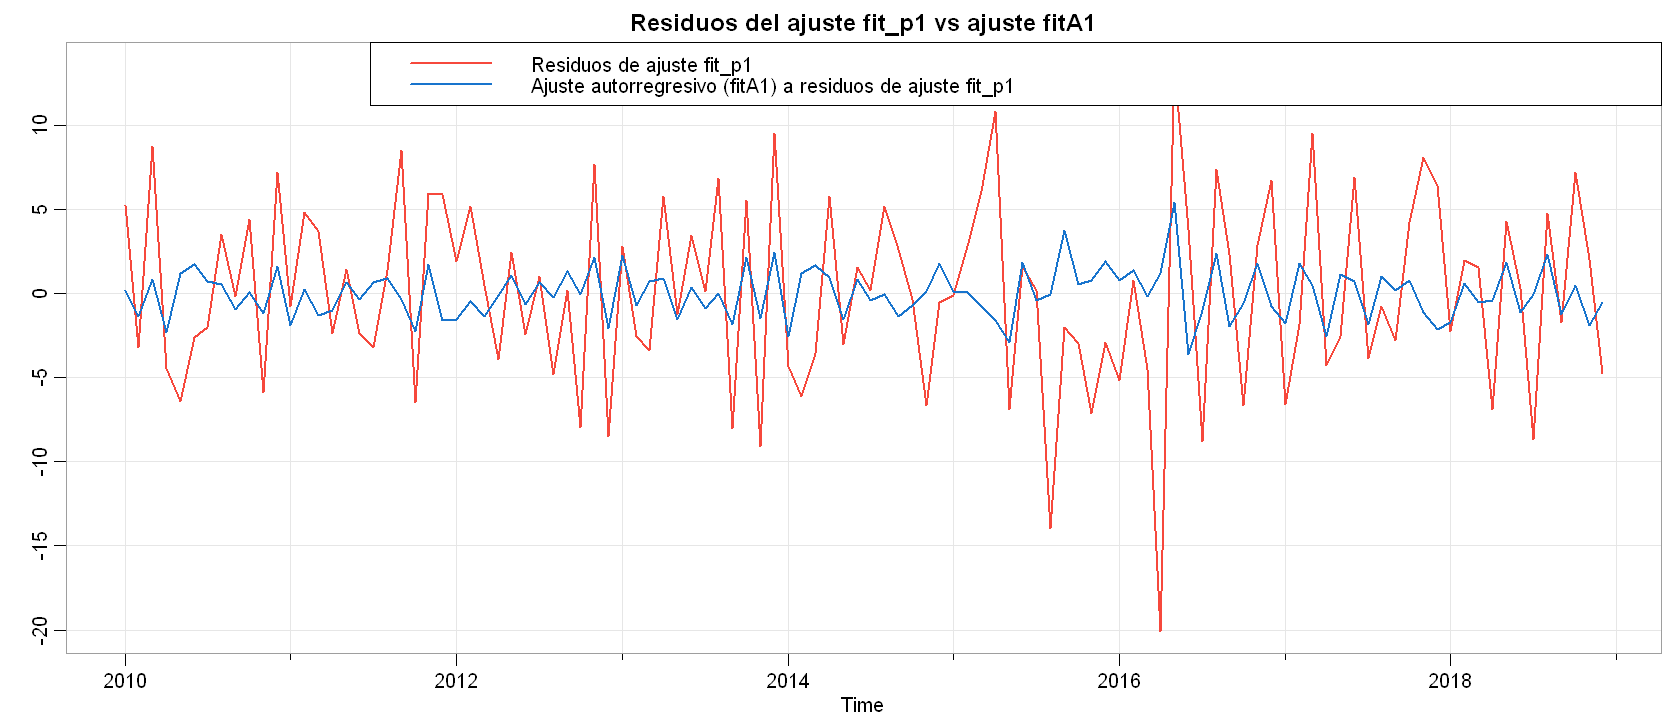

In [39]:
tsplot(ts(res_p, start = 2010, frequency = 12), col = 2, lwd = 2, ylab = '', main = 'Residuos del ajuste fit_p1 vs ajuste fitA1')
ajuste_autorregresivo = ts(fitted(fitA1), start = 2010, frequency = 12)
lines(ajuste_autorregresivo, col = 4, lwd = 2)

legend("topright", legend = c("Residuos de ajuste fit_p1", "Ajuste autorregresivo (fitA1) a residuos de ajuste fit_p1"), lwd = 2, col = c(2, 4))

La serie histórica tiene mucha varianza no explicada, por ende el ajuste fitA1 no es el mejor, pero da una idea de por donde se ubicarán los valores. Es esperable que si calcularamos intervalos de confianza, estos ocuparían casi toda la parte roja del gráfico anterior.

RMSE del ajuste autorregresivo fitA1 sobre los residuos del ajuste fit_p1:

In [40]:
rmse(res_p, ajuste_autorregresivo)

[1] 5.38823

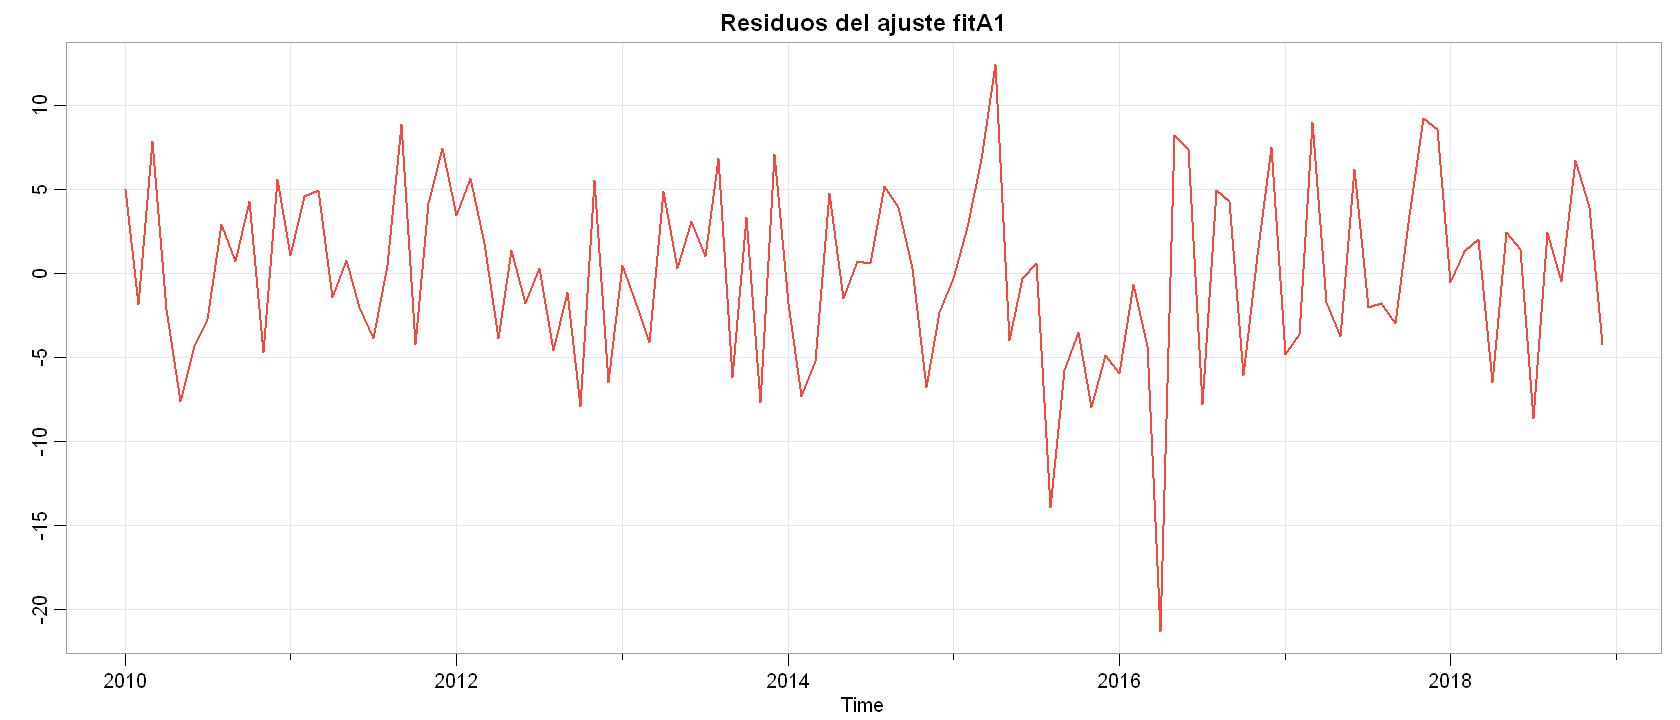

In [41]:
res_autorregresivos = residuals(fitA1)
tsplot(res_autorregresivos, ylab = '', main = 'Residuos del ajuste fitA1', col = 2, lwd =2)

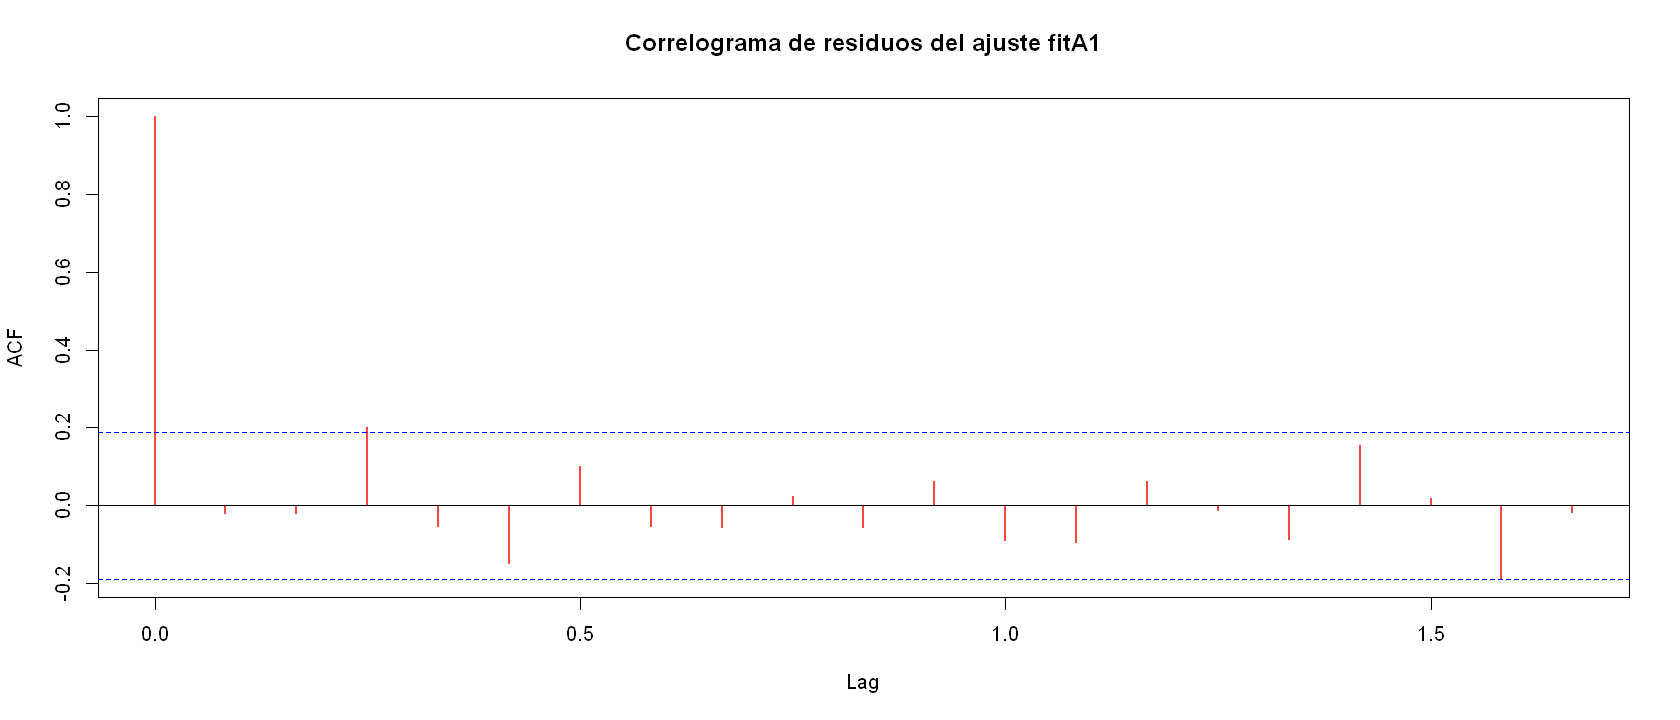

In [42]:
acf(res_autorregresivos, main = 'Correlograma de residuos del ajuste fitA1', col = 2, lwd = 2)

Ahora observamos que una vez que hicimos el tratamiento conjunto de la parte estacional y de la parte autorregresiva de la serie histórica, los residuos obtenidos parecen ser bastante ruido blanco y además, el RMSE del ajuste fitA1 mejoró ligeramente respecto al RMSE del ajuste fit_p1 que considera únicamente la parte estacional (5.41334111914591 < 5.61913465603263).

Ya considerando únicamente el ajuste de estacionalidad los residuos obtenidos eran bastante ruido blanco, por lo cual esperabamos que el agregado del ajuste autorregresivo no aportara un cambio sustancial en los resultados.


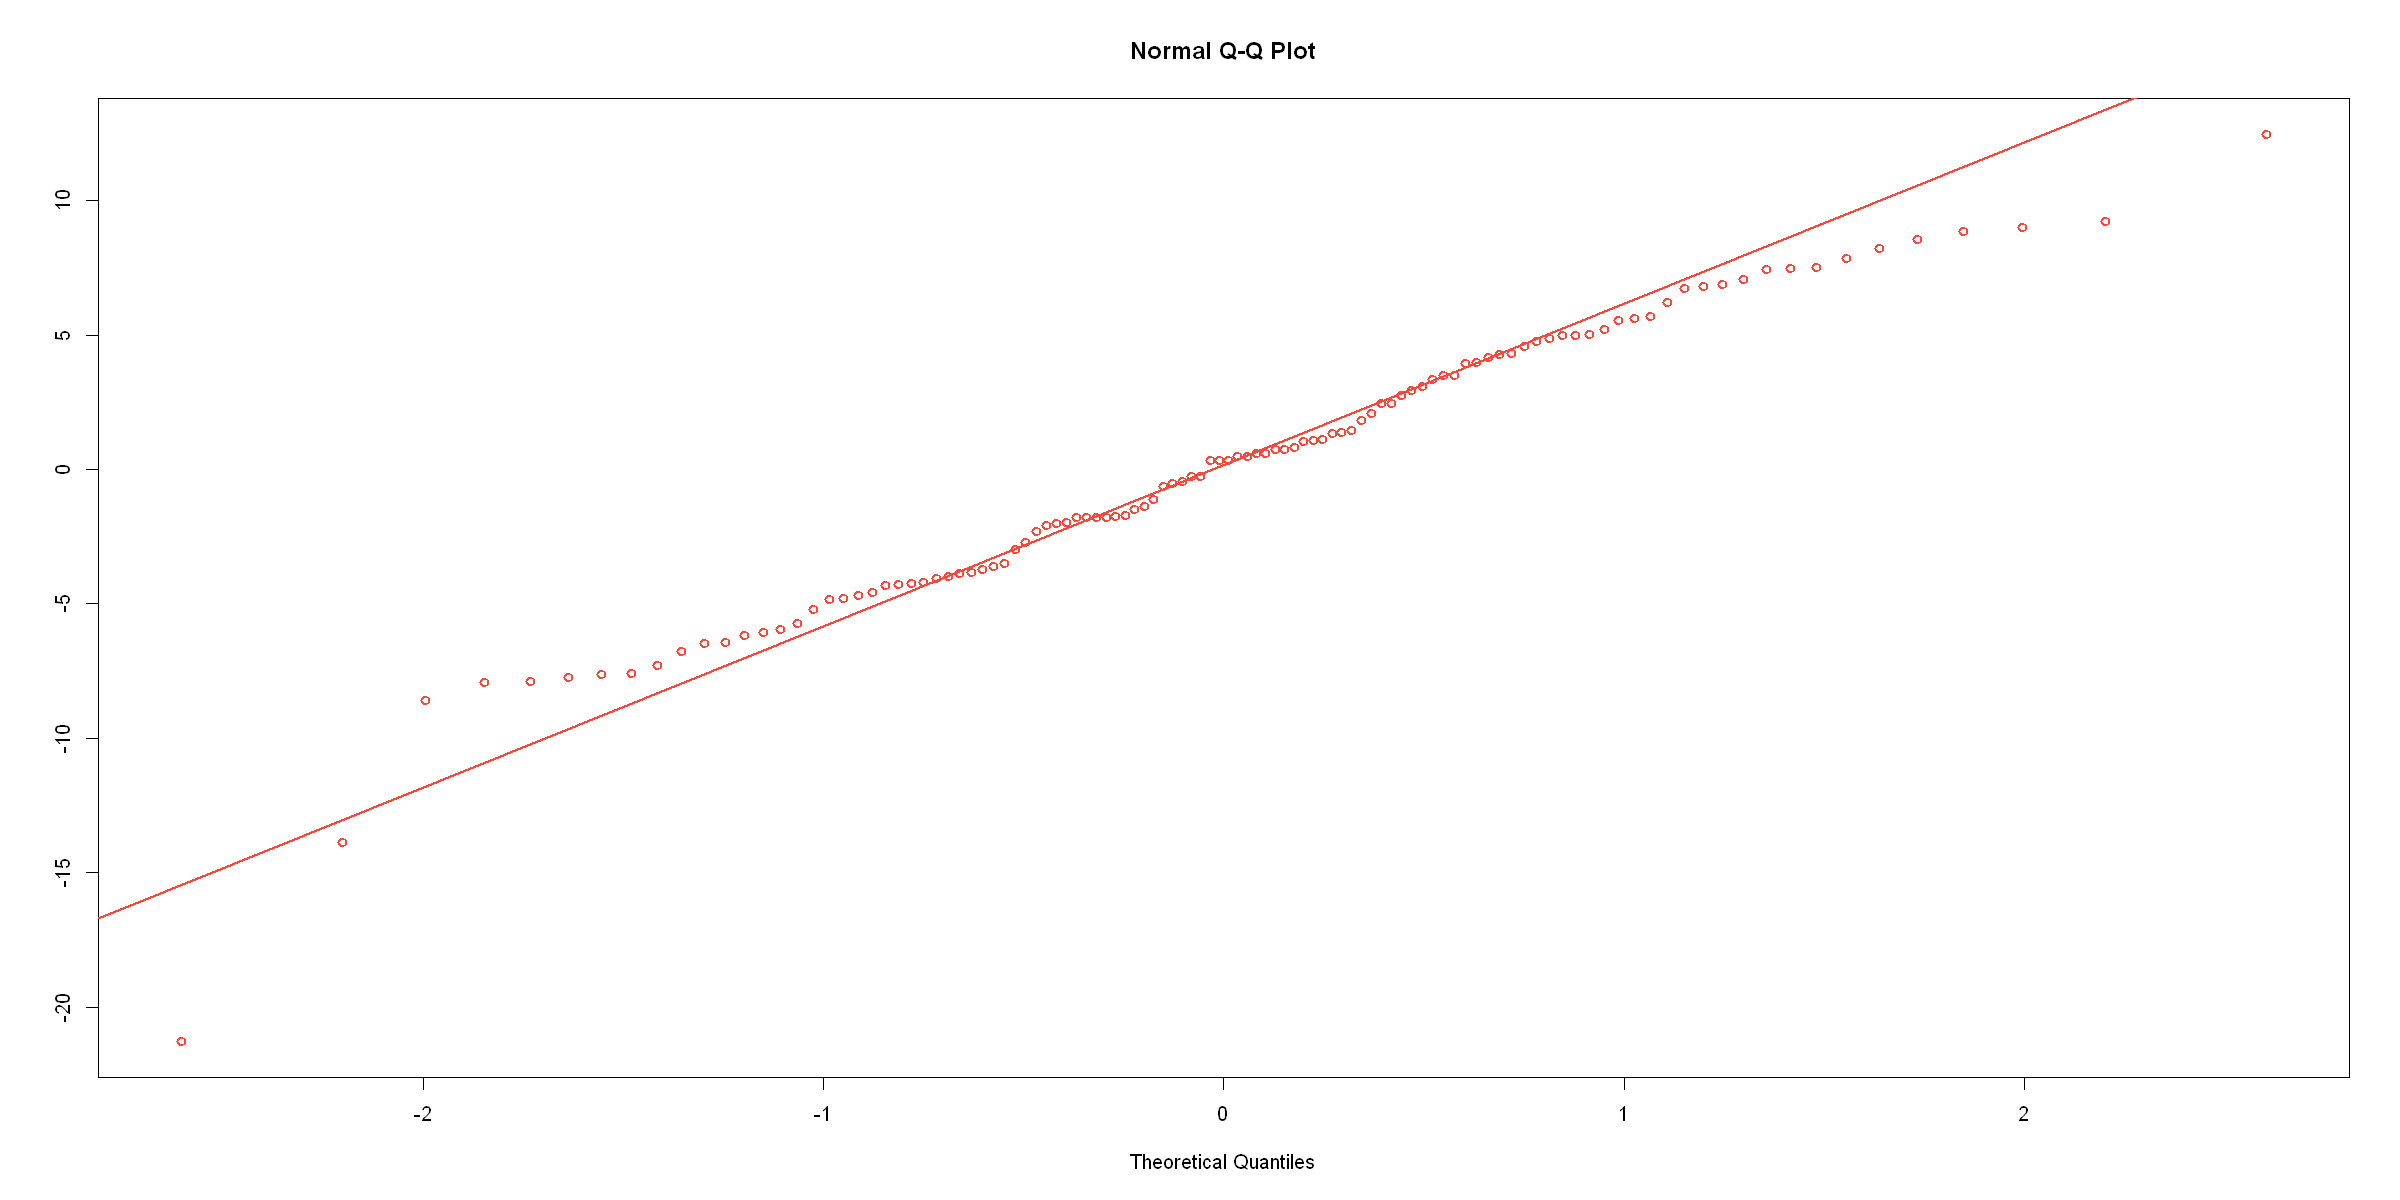

In [101]:
qqnorm(residuals(fitA1), ylab = '', col = 2,lwd = 2)
qqline(residuals(fitA1), col = 2,lwd = 2)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with zero mean
Q* = 23.552, df = 21, p-value = 0.3152

Model df: 1.   Total lags used: 22



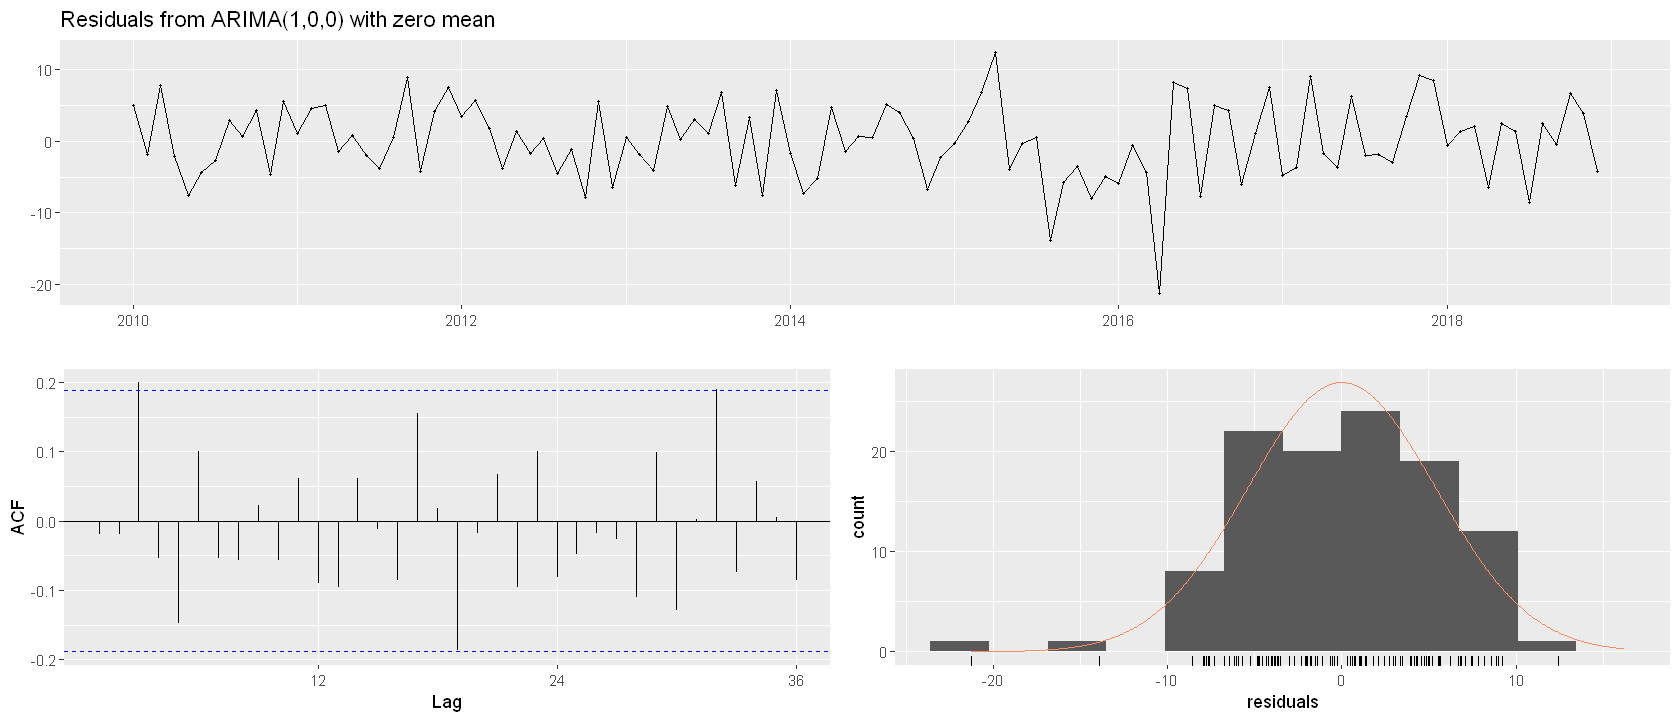

In [43]:
checkresiduals(fitA1)

PREDICCIONES DEL MODELO ECONOMÉTRICO AUTORREGRESIVO:

         Point Forecast     Lo 80    Hi 80      Lo 95    Hi 95
Jan 2019   1.276034e+00 -5.661454 8.213522  -9.333938 11.88601
Feb 2019  -3.415293e-01 -7.523207 6.840148 -11.324957 10.64190
Mar 2019   9.141000e-02 -7.107442 7.290262 -10.918284 11.10110
Apr 2019  -2.446580e-02 -7.224547 7.175615 -11.036039 10.98711
May 2019   6.548248e-03 -7.193621 7.206717 -11.005160 11.01826
Jun 2019  -1.752632e-03 -7.201928 7.198423 -11.013470 11.00997
Jul 2019   4.690904e-04 -7.199707 7.200645 -11.011249 11.01219
Aug 2019  -1.255516e-04 -7.200301 7.200050 -11.011844 11.01159
Sep 2019   3.360377e-05 -7.200142 7.200209 -11.011685 11.01175
Oct 2019  -8.994017e-06 -7.200185 7.200167 -11.011727 11.01171
Nov 2019   2.407240e-06 -7.200173 7.200178 -11.011716 11.01172
Dec 2019  -6.442955e-07 -7.200176 7.200175 -11.011719 11.01172
Jan 2020   1.724451e-07 -7.200176 7.200176 -11.011718 11.01172
Feb 2020  -4.615476e-08 -7.200176 7.200176 -11.011719 11.01172
Mar 2020   1.235328e-08 -7.200176 7.200176 -11.011718 1

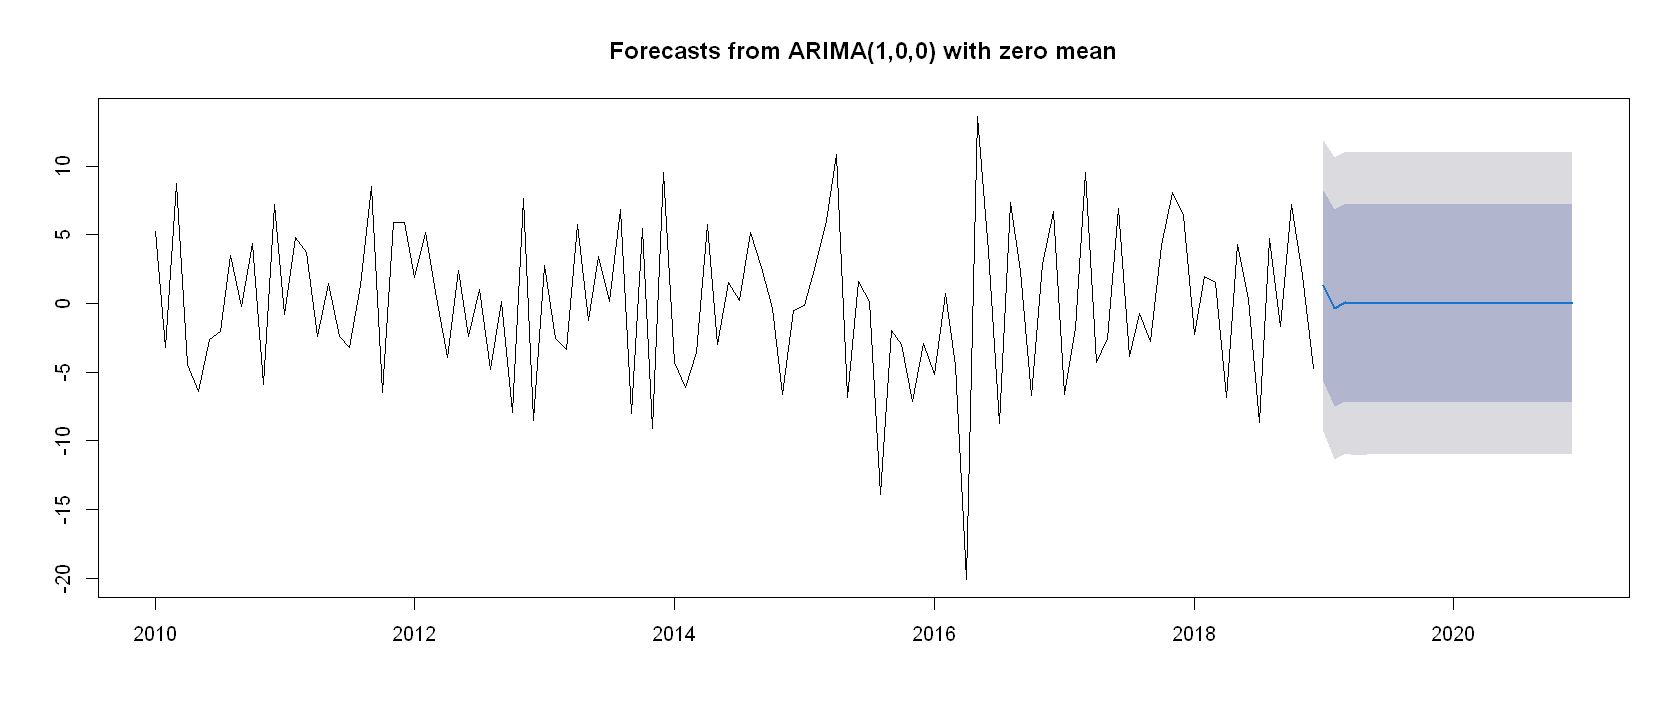

In [44]:
# Prediccion de dos años para adelante
predA = forecast(fitA1, h = 24)
predA
plot(forecast(fitA1, h = 24))

Podemos concluir que como el AR(1) tiene un coeficiente tan bajo, el modelo pierde la memoria enseguida y las predicciones tienden a la media. Es decir que podriamos afirmar que la única información nueva que obtuvimos con el objeto forecast son los intervalos de confianza al 80% y al 95%. 

Continuaremos el análisis utilizando los intervalos de confianza al 95%.

In [45]:
# Tratamiento de la información contenida en el objeto "forecast":

predA_media = predA$mean         # Predicciones
predA_lower = predA$lower[,2]    # Intervalo de confianza inferior al 95%
predA_upper = predA$upper[,2]    # Intervalo de confianza superior al 95%

RMSE de predicciones resultantes de fitA1 para 2019 - 2020 de nuestro modelo econométrico:

In [46]:
auxiliar1 = mean(x) + predA$mean
auxiliar2 = ts(auxiliar1, start = 2019, freq = 12)
rmse_parte_autorregresiva = rmse(valores_reales, auxiliar2)
rmse_parte_autorregresiva

[1] 7.034887

PREDICCIONES COMPLETAS: SUMA DE PREDICCIONES PREDETERMINISTICAS DE SENOS Y COSENOS CON PREDICCIONES DE LA PARTE AUTORREGRESIVA:

In [47]:
predA_media = pred_sc + predA_media
predA_lower = pred_sc + predA_lower
predA_upper = pred_sc + predA_upper

predA_media 
predA_lower 
predA_upper 

ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,-8.774882,-10.727085,2.170808,9.846303,5.383882,-1.901003,-4.862077,-5.557607,-3.108939,5.042685,10.565706,2.928823
2020,-10.050916,-10.385556,2.079398,9.870769,5.377333,-1.899250,-4.862546,-5.557481,-3.108972,5.042694,10.565704,2.928824


ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,-19.3848546,-21.7105125,-8.8388861,-1.1652708,-5.6278265,-12.9127204,-15.8737956,-16.5693255,-14.1206571,-5.9690330,-0.4460124,-8.0828950
2020,-21.0626350,-21.3972741,-8.9323203,-1.1409500,-5.6343851,-12.9109685,-15.8742648,-16.5692000,-14.1206907,-5.9690240,-0.4460148,-8.0828944


ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,1.8350896,0.2563427,13.1805024,20.8578762,16.3955897,9.1107151,6.1496412,5.4541114,7.9027799,16.0544039,21.5774246,13.9405419
2020,0.9608020,0.6261629,13.0911166,20.8824870,16.3890518,9.1124685,6.1491722,5.4542370,7.9027462,16.0544129,21.5774222,13.9405425


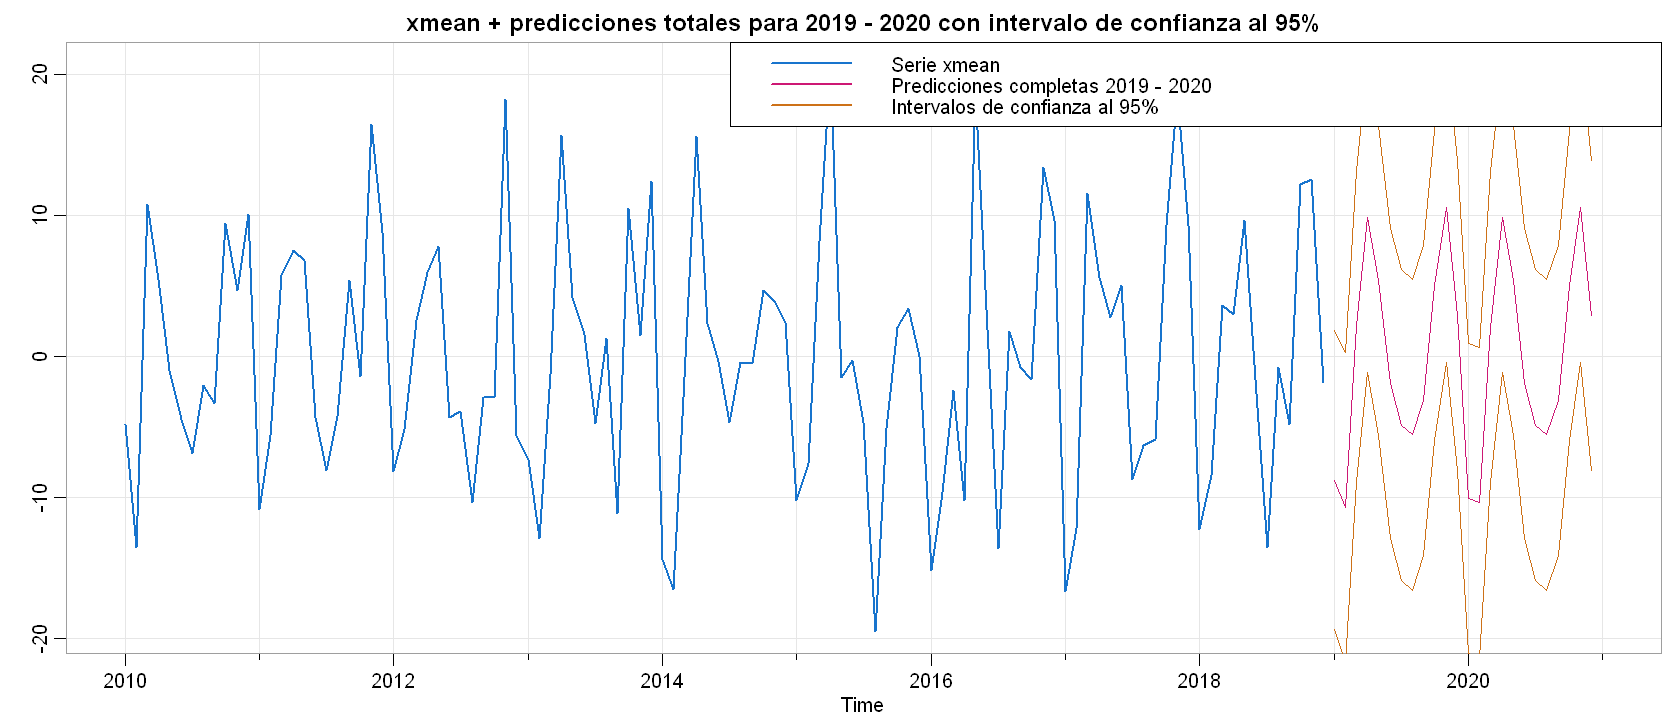

In [48]:
tsplot(xmean, xlim = c(2010, 2021), ylab = '', main = 'xmean + predicciones totales para 2019 - 2020 con intervalo de confianza al 95%', lwd = 2, col = 4)
lines(predA_media, col = 6)
lines(predA_lower, col = 7)
lines(predA_upper, col = 7)


legend("topright", legend = c("Serie xmean", "Predicciones completas 2019 - 2020", "Intervalos de confianza al 95%"), lwd = 2, col = c(4, 6, 7))

RETORNO A LA VARIABLE ORIGINAL de LAS PREDICCIONES SUMADAS:

In [49]:
# v_final_real = consumo$consumo_miles_m3[108] EN CASO DE HABER TRABAJADO CON UNA SERIE DIFERENCIADA

predA_media_f = mean(x) + predA_media
predA_lower_f = mean(x) + predA_lower
predA_upper_f = mean(x) + predA_upper

predA_media_f 
predA_lower_f
predA_upper_f 

ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,64.93186,62.97966,75.87755,83.55304,79.09062,71.80574,68.84466,68.14913,70.59780,78.74943,84.27245,76.63556
2020,63.65582,63.32119,75.78614,83.57751,79.08407,71.80749,68.84419,68.14926,70.59777,78.74944,84.27244,76.63556


ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,54.32189,51.99623,64.86785,72.54147,68.07891,60.79402,57.83295,57.13742,59.58608,67.73771,73.26073,65.62385
2020,52.64411,52.30947,64.77442,72.56579,68.07236,60.79577,57.83248,57.13754,59.58605,67.73772,73.26073,65.62385


ERROR while rich displaying an object: Error in repr_matrix_generic(obj, "\n%s%s\n", sprintf("|%%s\n|%s|\n", : el argumento formal "cols" concuerda con múltiples argumentos especificados

Traceback:
1. FUN(X[[i]], ...)
2. tryCatch(withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 . }, error = error_handler), error = outer_handler)
3. tryCatchList(expr, classes, parentenv, handlers)
4. tryCatchOne(expr, names, parentenv, handlers[[1L]])
5. doTryCatch(return(expr), name, parentenv, handler)
6. withCallingHandlers({
 .     if (!mime %in% names(repr::mime2repr)) 
 .         stop("No repr_* for mimetype ", mime, " in repr::mime2repr")
 .     rpr <- repr::mime2repr[[mime]](obj)
 .     if (is.null(rpr)) 
 .         return(NULL)
 .     prepare_content(is.raw(rpr), rpr)
 .

,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
2019,75.54183,73.96308,86.88724,94.56462,90.10233,82.81746,79.85638,79.16085,81.60952,89.76114,95.28417,87.64728
2020,74.66754,74.33290,86.79786,94.58923,90.09579,82.81921,79.85591,79.16098,81.60949,89.76115,95.28416,87.64728


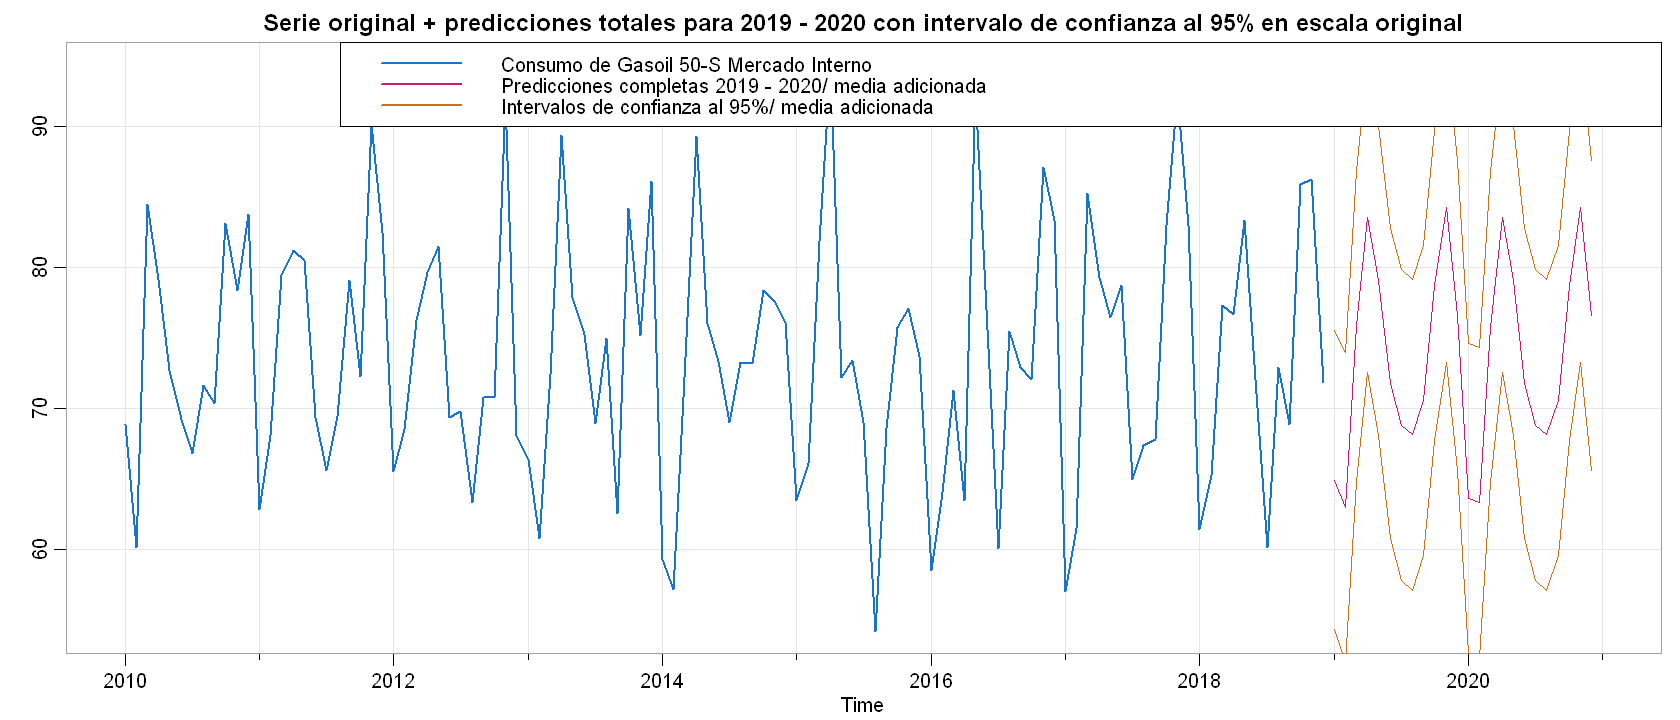

In [50]:
tsplot(x,xlim = c(2010,2021), ylab = '', main = 'Serie original + predicciones totales para 2019 - 2020 con intervalo de confianza al 95% en escala original', lwd = 2, col = 4)
lines(ts(predA_media_f, start = 2019, frequency = 12), col = 6)
lines(ts(predA_lower_f, start = 2019, frequency = 12), col = 7)
lines(ts(predA_upper_f, start = 2019, frequency = 12), col = 7)

legend("topright", legend = c("Consumo de Gasoil 50-S Mercado Interno", "Predicciones completas 2019 - 2020/ media adicionada", "Intervalos de confianza al 95%/ media adicionada"), lwd = 2, col = c(4, 6, 7))

EVALUACION VALORES REALES 2019 - 2020 VS PREDICCIONES COMPLETAS

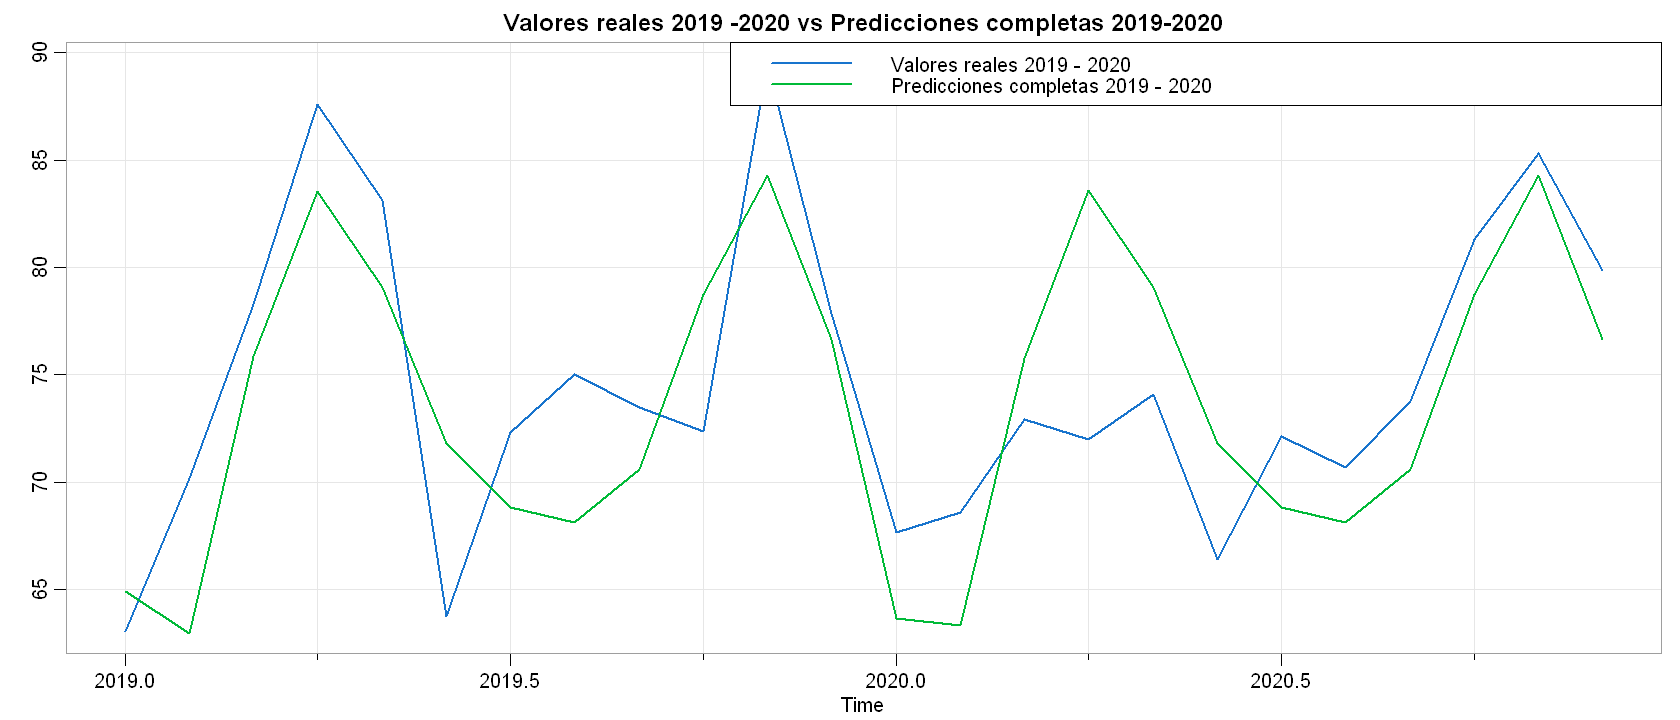

In [51]:
tsplot(ts(valores_reales, start = 2019, freq = 12), ylab = '', main = "Valores reales 2019 -2020 vs Predicciones completas 2019-2020", col = 4, lwd = 2)
lines(ts(predA_media_f, start = 2019, freq = 12), col = 3, lwd = 2)

legend("topright", legend = c("Valores reales 2019 - 2020", "Predicciones completas 2019 - 2020"), lwd = 2, col = c(4, 3))

RMSE de predicciones completas 2019 - 2020 de nuestro modelo econométrico:

In [52]:
rmse_modelo_econometrico_completo = rmse(valores_reales, predA_media_f)
rmse_modelo_econometrico_completo

[1] 4.922196

Se observa que "rmse_modelo_econometrico_completo" es ligeramente superior a "rmse_modelo_econometrico_estacional" pero son practicamente iguales. Si bien no esperabamos esto ya que el "rmse_modelo_econometrico_completo" corresponde a un modelo que contempla tanto la parte estacional como la parte autorregresiva de la serie histórica, creemos que la diferencia es mínima. Esto último era esperable ya que nuestro modelo que contempla la parte estacional únicamente, había arrojado residuos que ya eran bastante ruido blanco.

4.88990509641538 < 4.92219603883863

CALCULO DE PREDICCIONES RECURSIVAS

Usamos un “arima.sim” para simular este AR puro y trabajaremos con el para efectuar predicciones recursivas:

La diferencia entre el modo empleado para obtener las predicciones de la parte autorregresiva mediante el objeto forecast (o prediccion hacia el futuro) y la predicción recursiva, es que el modo de predicción anterior busca predecir mucho tiempo más hacia adelante y por ende hace predicciones sobre predicciones. En cambio, la predicción recursiva siempre predice un único valor hacia adelante, basándose en el último dato observado (siempre serán predicciones a un paso). 

Como el los residuos obtenidos a partir del ajuste fit_p1 daban cuenta de un modelo autorregresivo de orden 1 con poca correlación hacia atrás, entonces era de esperarse que las predicciones a largo plazo tendieran a la media. En consecuencia, la poca memoria de este proceso generaba un RMSE muy pobre (muy superior, por ejemplo, al obtenido a partir de las predicciones que resultaban del modelo de contemplaba únicamente la parte estacional).



In [132]:
summary(fitA1)
phi1 = fitA1$coef
phi1
x_train = ts(head(res_p, 108), start = 2010, freq = 12)

Series: res_p 
ARIMA(1,0,0) with zero mean 

Coefficients:
          ar1
      -0.2676
s.e.   0.0929

sigma^2 estimated as 29.3:  log likelihood=-335.18
AIC=674.36   AICc=674.47   BIC=679.72

Training set error measures:
                     ME    RMSE      MAE      MPE     MAPE      MASE
Training set 0.01005238 5.38823 4.304925 100.7443 125.6264 0.6913864
                    ACF1
Training set -0.01976447


ar1 
-0.2676491

In [133]:
#x_hat[1] = mean(x) + x_hat[1]
#x_hat[1]

In [134]:
vaux = valores_reales - mean(x)

A continuación: en lugar de usar x_hat[i-1] usamos valores_reales[i-1], porque así en cada paso predecimos utilizando los valores cerrados hasta el mes anterior inclusive en cada paso

In [139]:
x_hat <- vector()

x_hat[1] = phi1*x_train[108]

for (i in 2:24)
{
    x_hat[i] = phi1*vaux[i-1] 
}

In [136]:
# Vuelta a la variable original para las predicciones obtenidas recursivamente
#x_hat = mean(x) + x_hat

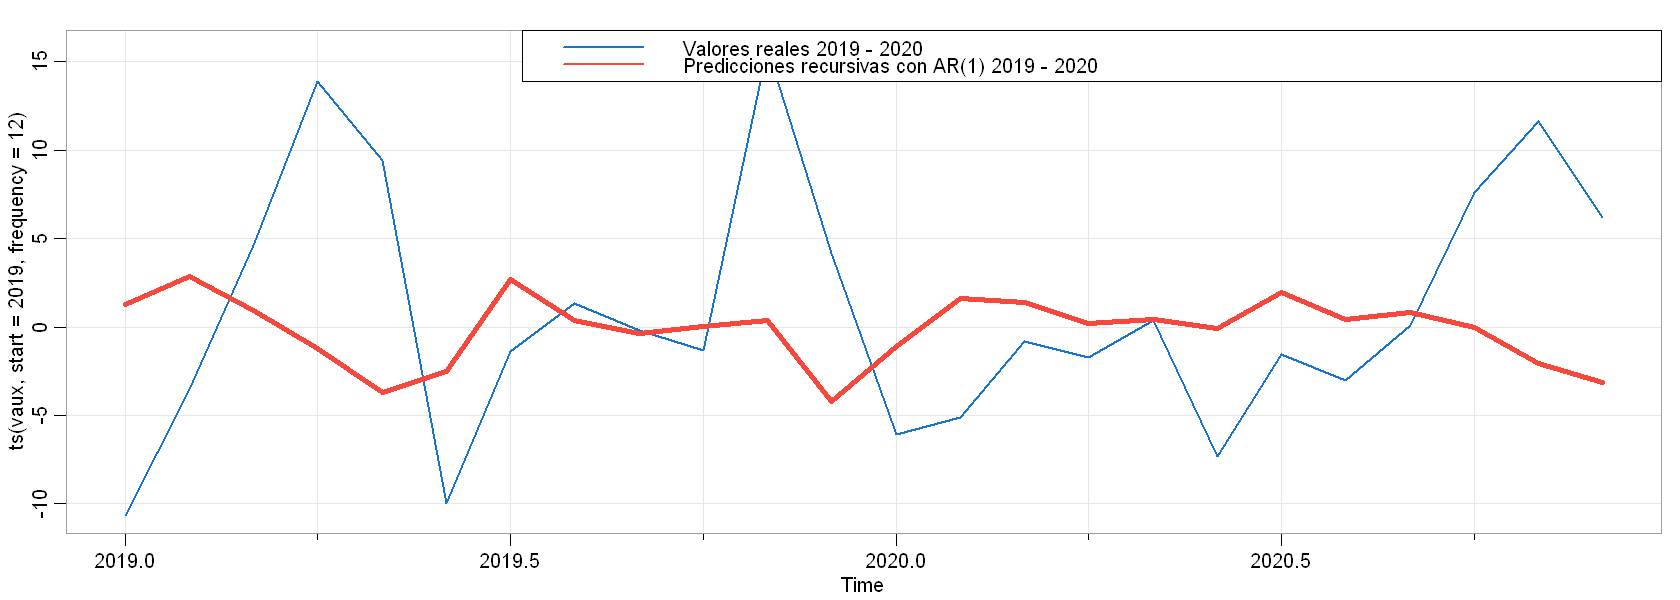

In [137]:
options(repr.plot.width = 14, repr.plot.height = 5)
tsplot(ts(vaux, start= 2019, frequency = 12), col = 4, lwd = 2) # lo que queremos predecir
lines(ts(x_hat, start= 2019, frequency = 12), col = 2, lwd = 4) # lo que estamos prediciendo

legend("topright", legend = c("Valores reales 2019 - 2020", "Predicciones recursivas con AR(1) 2019 - 2020"), lwd = 2, col = c(4,2))

In [138]:
rmse(vaux, x_hat)

[1] 7.813886

In [56]:
7.03488704591037


[1] 7.034887

CONCLUSIONES DE NUESTRO ANÁLISIS:

Bajo este análisis podemos concluir que el consumo de gasoil 50-S en Uruguay está estable y que posee un ciclo anual que está compuesto a su vez de dos subciclos, uno semestral y otro cuatrimestral, con variaciones alrededor que son básicamente ruido con una pequeña correlación dada por el AR(1), a partir de lo cual obtuvimos los intervalos de confianza.

ANÁLISIS MEDIANTE LA UTILIZACIÓN DE UNA RED NEURONAL:

A continuación mostraremos las predicciones del consumo de Gasoil 50-S para el mismo período temporal (2019 - 2020), obtenidas a partir de la utilización de técnicas de deep learning. 

La arquitectura que se muestra a continuación pertenece a una red neuronal desarrollada en Python, que combina capas LSTM (Long-Short Term Memory) y capas densas, y que es el resultado de múltiples iteraciones de modelos no documentados que se fueron modificando en función de los resultados obtenidos:

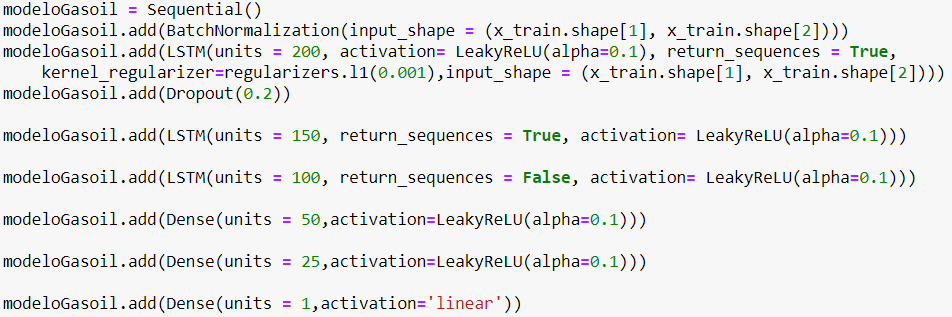

Los parámetros de dicha arquitectura son los siguientes:

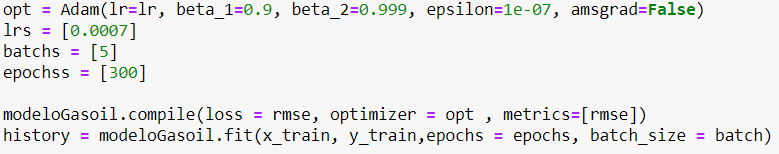


Las LSTM son una extensión de las redes neuronales recurrentes, las cuales son capaces de persistir la información mediante la introducción de bucles en el diagrama de la red, y por lo tanto "recordar" estados previos, para determinar cual será el siguiente. Mientras que las redes neuronales recurrentes son útiles para modelar tendencias a corto plazo, las LSTM pueden aprender relaciones lejanas en una serie histórica. 

Si bien nos referiremos a ellos como "neuronas", en realidad las LSTM poseen bloques de memoria (o unidades de memoria) que están conectados mediante capas, y cada uno de ellos hace uso de puertas que administran el estado y la salida de cada bloque. A saber, existen tres tipos de puertas, cada una de ellas con funciones claramente diferenciadas:

-Forget Gate: decide condicionalmente qué información desechar del bloque.

-Puerta de entrada: decide condicionalmente qué valores de la entrada actualizar el estado de la memoria.

-Puerta de salida: decide condicionalmente qué generar en función de la entrada y la memoria del bloque.


El dataset empleado para trabajar con la red neuronal está compuesto de tres variables: 

-Fecha: Como ya sabemos, la serie temporal es mensual

-Días de Venta Teoricos: Son los días de venta del producto cuyo consumo buscamos predecir. Como son teóricos, simplemente se toman los días hábiles de cada mes (en la práctica se deberían considerar también los sabados como la mitad de un día, así como feriados, paros y demás casos excepcionales)

-Consumo de Gasoil 50-S: Variable a predecir

Por este motivo, decimos que estamos implementando un modelo multivariado para predicción de series temporales mediante uso de redes neuronales LSTM.

Como ya sabemos que nuestra serie histórica es bastante estacionaria, lo único que hicimos fue escalar los dias de venta teóricos y los meses entre 0 y 1. Una vez hecho esto, nuestro primer paso para poder trabajar con la red neuronal fue transformar nuestros datos de serie temporal en un formato de aprendizaje supervisado que sirviera de input a la red. Esto es, convertir el dataset que está en formato de serie histórica en un dataset que posea para cada variable predictora los resagos en el tiempo que nosotros consideremos necesarios (es decir la ventana temporal elegida).

Para este caso puntual y luego de varias pruebas efectuadas, decidimos que las predicciones ajustaban mejor para una ventana temporal de 24 meses, por lo cual tomamos las variables predictoras desde "t - 1" hasta "t - 24", mientras que la variable a predecir se dispuso en el dataset para el momento "t". 

Esto es necesario ya que la LSTM asume que nuestros datos se dividen en datos de entrada (variables predictoras) y datos de salida (variables a predecir o etiqueta).

A continuación vemos una muestra de como queda nuestro dataset una vez que fue adaptado como un problema de aprendizaje supervisado:

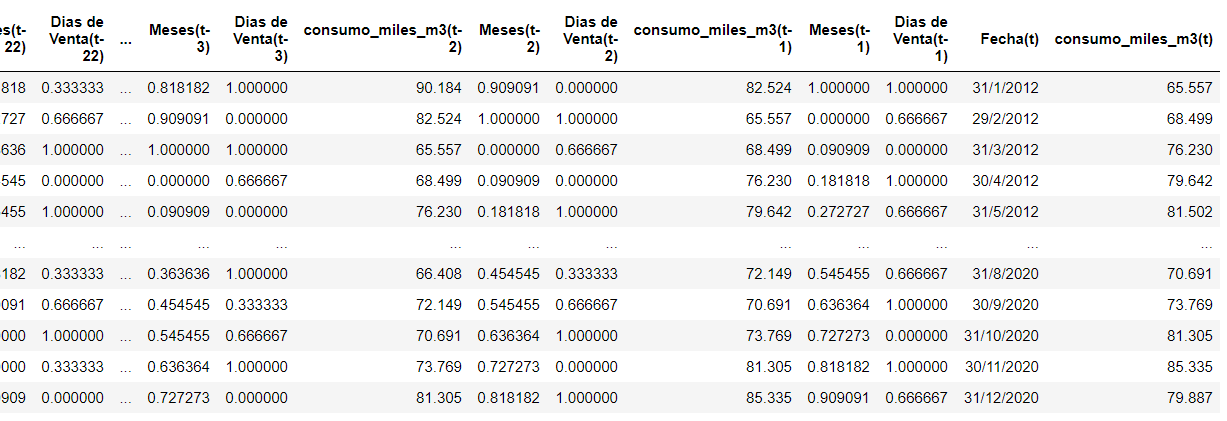


La LSTM recibe como input de entrada una matriz con las dimensiones: muestras, resagos de tiempo y features (variables). 



Como conjunto de datos de test tomamos los correspondientes al período a predecir, es decir: 2019 - 2020, de forma tal de poder evaluar nuestras predicciónes con dicho conjunto. Por lo tanto, como nuestra serie temporal es mensual, la cantidad de datos de test es 24. 

Cómo función de costo a minimizar elegimos el RMSE, con el objetivo de hacer que esta aproximación al cálculo de predicciones fuese comparable a la del modelo econométrico. Por otro lado, utilizamos el optimizador Adam, ya que es el más aceptado actualmente en el uso de redes neuronales aplicadas a predicciones de series temporales.

Para todas las capas (tanto LSTMs como densas) se empleó la función de activación leaky relu, con la intención de identificar relaciones no lineales entre los datos. La excepción viene dada por la última capa de la red, que en este problema de regresión deber ser una capa densa con una función de activación linear y una única neurona.

Las predicciones efectuadas fueron realizadas en la modalidad "predicción sobre predicción" para todo el periodo 2019 - 2020. Es decir, no tomamos un enfoque dinámico, en donde los datos de entrenamiento se fueran ajustando a medida se hacían visibles nuevas observaciones en el tiempo, para luego predecir la siguiente observación en cada paso. Este último es otra posible aproximación a nuestro problema que decidimos no considerar en el presente trabajo por motivos de simplicidad.

Debido a que la aleatoriedad en el conjunto de los datos durante el entrenamiento hace que esta aproximación al problema tenga mayor variabilidad en los resultados obtenidos que con respecto al modelo econométrico, decidimos realizar 10 ejecuciones de la red neuronal para promediar el RMSE de cada ejecución, y poder tener una idea de que tan robusta es.

El RMSE promedio es de: 

A continuación seleccionamos la peor y la mejor ejecución de la red neuroal, y comparamos los RMSEs de cada caso, con el RMSE obtenido a partir del modelo econométrico:

In [57]:
peor_ejecucion_red <- read.csv("red_peor_prediccion.csv")
mejor_ejecucion_red <- read.csv("red_mejor_prediccion.csv")

In [58]:
peor_ejecucion_red = ts(peor_ejecucion_red$Prediccion, start = 2019, freq = 12)
mejor_ejecucion_red = ts(mejor_ejecucion_red$Prediccion, start = 2019, freq = 12)

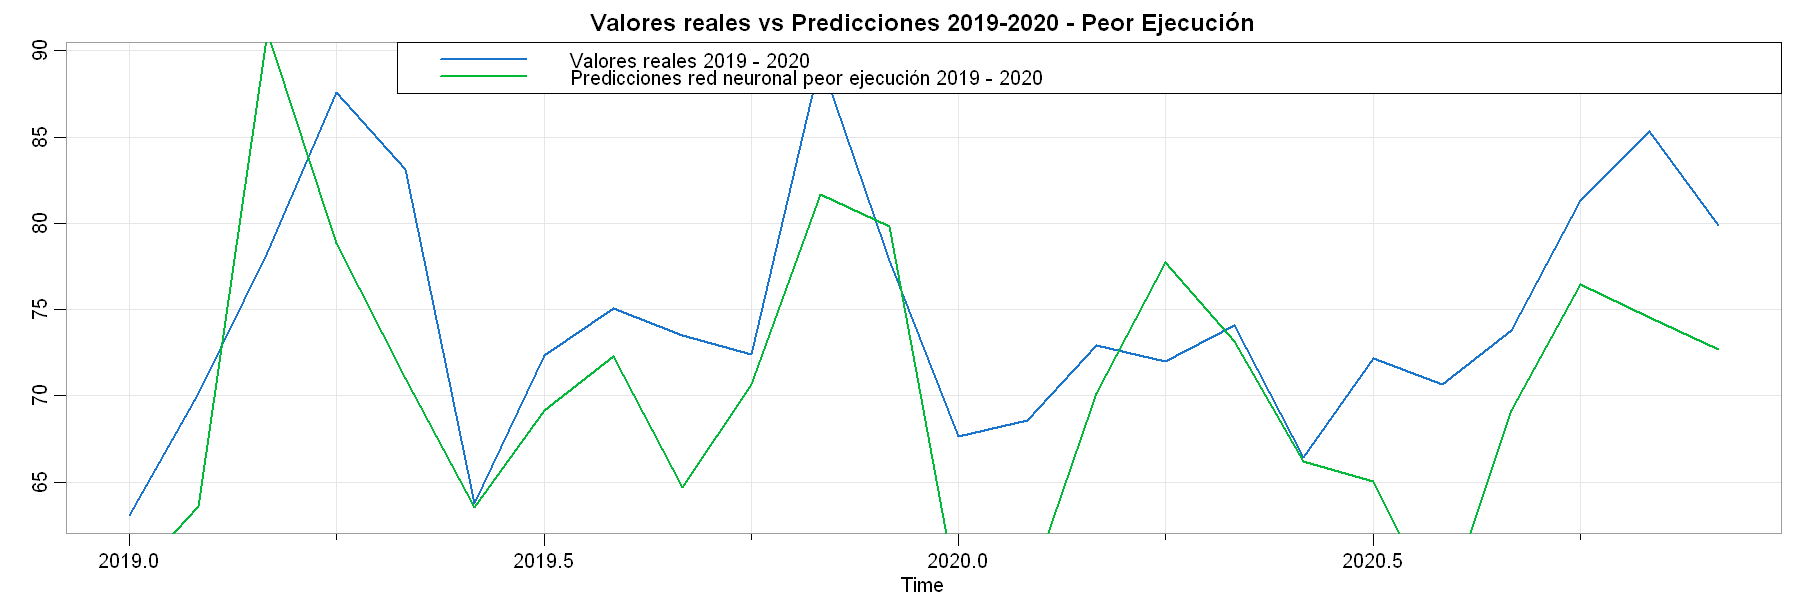

In [59]:
options(repr.plot.width = 15, repr.plot.height = 5)
tsplot(ts(consumo_2019_2020$consumo_miles_m3, start = 2019, freq = 12), ylab = '', main = "Valores reales vs Predicciones 2019-2020 - Peor Ejecución", col = 4, lwd = 2)
lines(ts(peor_ejecucion_red, start = 2019, freq = 12), col = 3, lwd = 2)

legend("topright", legend = c("Valores reales 2019 - 2020", "Predicciones red neuronal peor ejecución 2019 - 2020"), lwd = 2, col = c(4, 3))

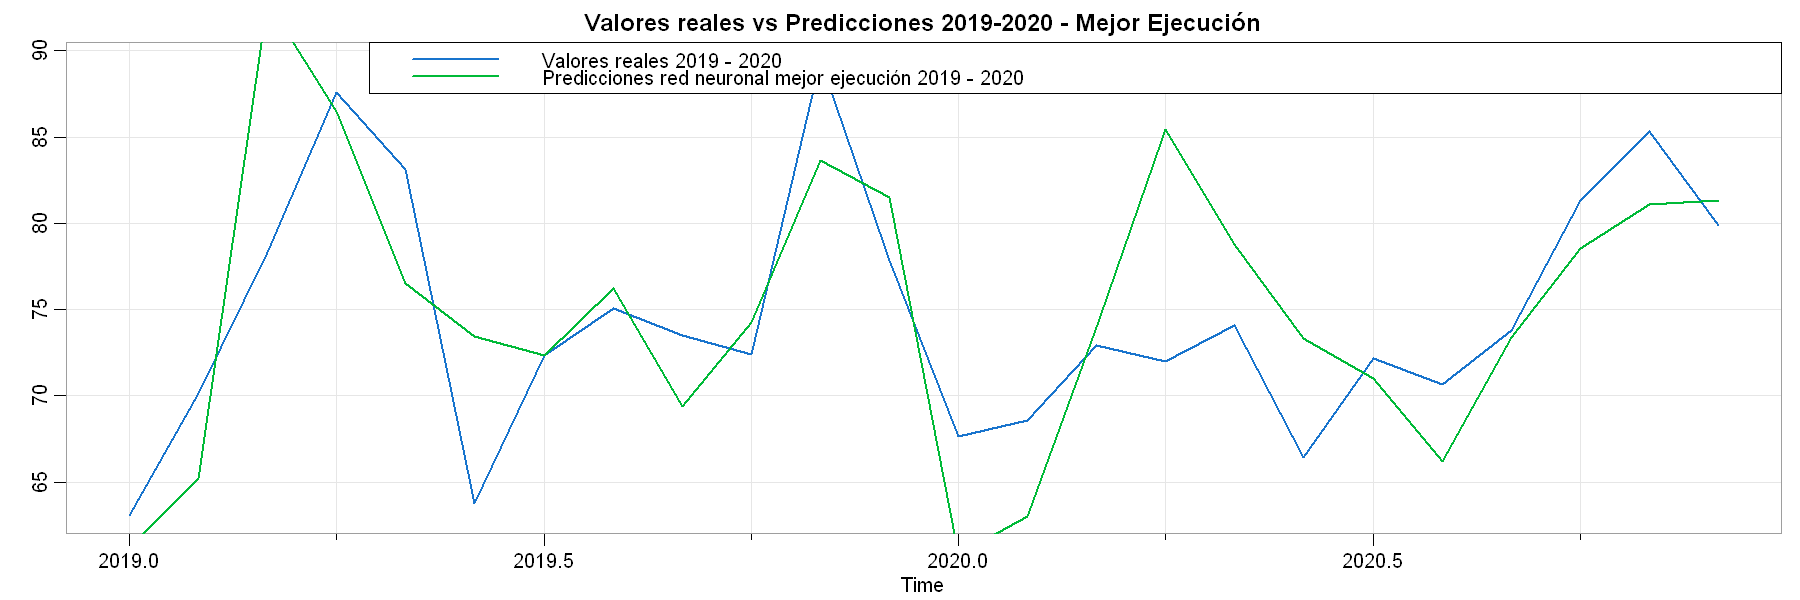

In [60]:
tsplot(ts(consumo_2019_2020$consumo_miles_m3, start = 2019, freq = 12), ylab = '', main = "Valores reales vs Predicciones 2019-2020 - Mejor Ejecución", col = 4, lwd = 2)
lines(ts(mejor_ejecucion_red, start = 2019, freq = 12), col = 3, lwd = 2)

legend("topright", legend = c("Valores reales 2019 - 2020", "Predicciones red neuronal mejor ejecución 2019 - 2020"), lwd = 2, col = c(4, 3))

RMSE entre modelo econométrico vs RMSE de la Mejor y Peor ejecución de la Red Neuronal:

In [61]:
rmse_red_neuronal_peor_ejecucion = rmse(valores_reales, peor_ejecucion_red)
rmse_red_neuronal_mejor_ejecucion = rmse(valores_reales, mejor_ejecucion_red)

In [62]:
rmse_red_neuronal_peor_ejecucion
rmse_red_neuronal_mejor_ejecucion

[1] 7.332472

[1] 5.864574

In [63]:
rmse_modelo_econometrico_completo

[1] 4.922196

CONCLUSIONES:

Observamos que incluso en su mejor ejecución, la red neuronal ajusta peor que con respecto al modelo econométrico. Quizás puedan mejorarse los resultados de la red neuronal con las siguientes opciones:

-Modificación de sus parámetros: Por ejemplo, reduciendo su ritmo de aprendizaje (learning rate), y en consecuencia, aumentando la cantidad de epochs para que tenga tiempo de entrenar correctamente. Otra opción podría ser modificar el batch size (cuanto mayor sea este, más rápido entrenará la red, pero es más probable que los resultados no sean tan buenos), recordando que estaríamos modificando el número de filas de tamaño fijo del conjunto de datos de entrenamiento que determina la cantidad de patrones a ser procesados previamente a la actualización de los pesos de la red (o fuerza de conexión entre las neuronas/bloques de la LSTM). La velocidad de actualización de estos pesos queda fijada por la magnitud del learning rate.

Se empleó un DropOut del 20% en la primera capa LSTM, y un regularizador L1 estándar (0.001) para evitar sobreajustar a los datos de entrenamiento, pero estos son parámetros que también podrían tener que ajustarse. 

-Considerar como variables predictoras a los "días de venta" y "meses" en el momento "t" (momento de predicción) y no solo en sus resagos desde "t - 1" hasta "t - 24": Esto podría generar mayor información a la red que el permitiera establecer relaciones de largo plazo más fácilmente. Tiene sentido plantear esta opción, ya que si vamos a predecir el consumo de gasoil 50-S en un determinado mes (o meses) en el futuro, nosotros conocemos que número de mes será y por ende cuantos días hábiles tendrá. Este paso implica mayor desarrollo de nuestros algoritmos que decidimos no emprender en este trabajo (en el caso de hacerlo, deberíamos además desescalar las predicciones para "retornarlas a la variable original").

-Considerar otra ventana de tiempo más representativa del comportamiento de la serie histórica: Esto podría mejorar las predicciones, por ejemplo, tomando 12 resagos, o incluso 36, por citar algunos ejemplos. El problema de esta última opción es que carecemos de flexibilidad en la elección del tamaño de la ventana de tiempo. Esto es así porque que disponemos de una cantidad de datos reducida (en términos de lo que implica el entrenamiento de una red neuronal).

-Escalar los datos: Los valores numéricos de las variables predictoras fueron escalados entre 0 y 1, mientras que la variable a predecir (o etiqueta) no fue escalada. Quizás se podrían obtener mejores resultados si previamente al entrenamiento de la red probaramos escalar también esta última variable. En este caso, las predicciones deberían ser desescaladas.

-Llevar a cabo un enfoque dinámico en el cálculo de las predicciones: Esto significa actualizar los valores en el tiempo a medida estos se hacen disponibles para predecir cada siguiente observación. Se supone que al efectuar predicciones sobre predicciones, a medida nos alejamos en el tiempo, la calidad de las predicciones comienza a reducirse ya que la correlación entre los datos comienza a ser menor. 

-Agregar a la red neuronal las frecuencias de senos y cosenos encontradas en el periodograma como variables predictoras.

Finalmente, consideramos que es difícil mejorar el resultado obtenido con el modelo econométrico, ya que a partir de los ajustes realizados habíamos comprobado que los residuos obtenidos eran ruido blanco, y es muy difícil poder obtener mayor información de algo a lo que ya se le extrajo todo lo que puede ser explicado. Es decir que un modelo de caja negra no debería (en teoría), poder lograr algo más. De todos modos, la diferencia entre ambas aproximaciones no fue muy significativa (si bien podría argumentarse que esto es una afirmación relativa).

Por este motivo entendemos que los resultados obtenidos con la red neuronal podrían mejorarse mediante algunas de las opciones descritas anteriormente, pero dudosamente podrían superar a los resultados obtenidos con el modelo econométrico.

ANÁLISIS APARTADO 1:

A continuación realizamos un análisis diferente ajustando un modelo autorregresivo sobre la serie "xmean" (que es estacionaria) con coeficientes únicamente en el cuarto y sexto lugar (ya que nuestras frecuencias elegidas son cuatrimestrales y semestrales respectivamente). Haremos esto porque consideramos la posibilidad de que el valor actual de la serie observada tenga una correlación con el valor de la serie en cuatro y seis meses antes.

Lo que estaremos haciendo en este análisis es forzar algunos coeficientes del modelo a que den cero, dejando únicamente aquellos que nos interesan. Esto no lo podemos hacer con la función "Arima", por ende, lo haremos del siguiente modo:


In [64]:
# Quitamos el Intercept porque la serie ya está centrada
df_aux = ts.intersect(x = xmean, xt1 = lag(xmean,-4), xt2 = lag(xmean, -6))
fit_autorregresivo_estacional1 = lm(x ~ 0 + xt1 + xt2 , data = df_aux)
summary(fit_autorregresivo_estacional1)
phi1<- fit_autorregresivo_estacional1$coef["xt1"]
phi2<- fit_autorregresivo_estacional1$coef["xt2"]

phi1
phi2



Call:
lm(formula = x ~ 0 + xt1 + xt2, data = df_aux)

Residuals:
     Min       1Q   Median       3Q      Max 
-16.6200  -5.8685  -0.1096   4.8196  18.5584 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt1 -0.04853    0.09355  -0.519    0.605    
xt2  0.48288    0.09341   5.169 1.21e-06 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.75 on 100 degrees of freedom
Multiple R-squared:  0.2473,	Adjusted R-squared:  0.2323 
F-statistic: 16.43 on 2 and 100 DF,  p-value: 6.768e-07


xt1 
-0.04853414

xt2 
0.4828849

In [65]:
fit_autorregresivo_estacional2 = lm(x ~ 0 + xt2, data = df_aux)
summary(fit_autorregresivo_estacional2)

phi2<- fit_autorregresivo_estacional2$coef["xt2"]

phi2


Call:
lm(formula = x ~ 0 + xt2, data = df_aux)

Residuals:
    Min      1Q  Median      3Q     Max 
-17.153  -5.735   0.120   5.075  18.362 

Coefficients:
    Estimate Std. Error t value Pr(>|t|)    
xt2  0.49978    0.08723    5.73 1.05e-07 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 7.722 on 101 degrees of freedom
Multiple R-squared:  0.2453,	Adjusted R-squared:  0.2378 
F-statistic: 32.83 on 1 and 101 DF,  p-value: 1.046e-07


xt2 
0.4997845

Nos quedamos con el ajuste fit_autorregresivo_estacional2, ya que entre este y el fit_autorregresivo_estacional1, el R cuadrado se mantiene prácticamente invariante.

A continuación graficamos los residuos de dicho ajuste:

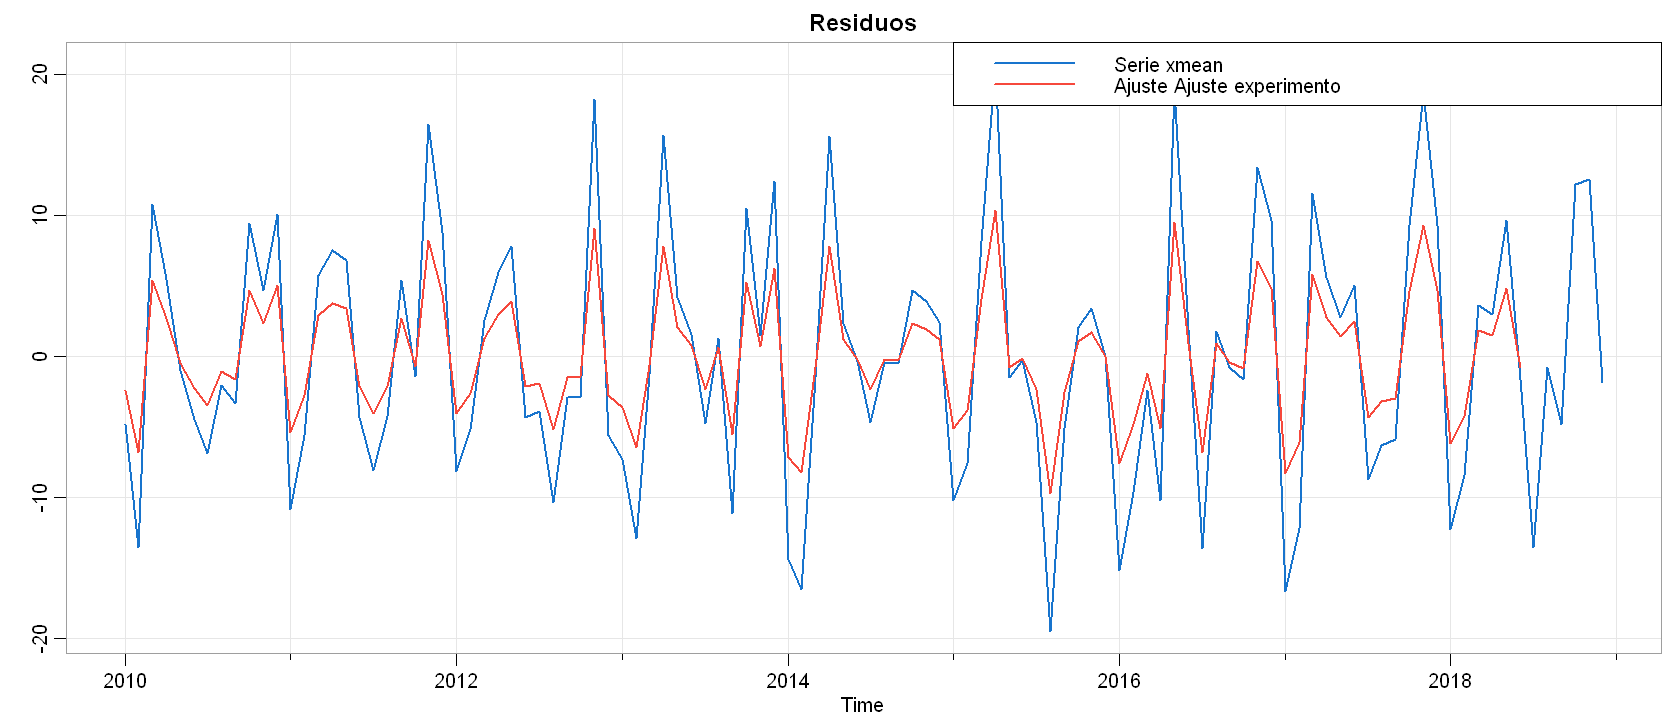

In [66]:
options(repr.plot.width = 14, repr.plot.height = 6)

tsplot(ts(xmean, start = 2010, frequency = 12), ylab = '', col = 4, lwd = 2, main = 'Residuos')
ajuste_experimento = ts(fitted(fit_autorregresivo_estacional2), start = 2010, frequency = 12)
lines(ajuste_experimento, col = 2, lwd = 2)

legend("topright", legend = c("Serie xmean", "Ajuste Ajuste experimento"), lwd = 2, col = c(4, 2))

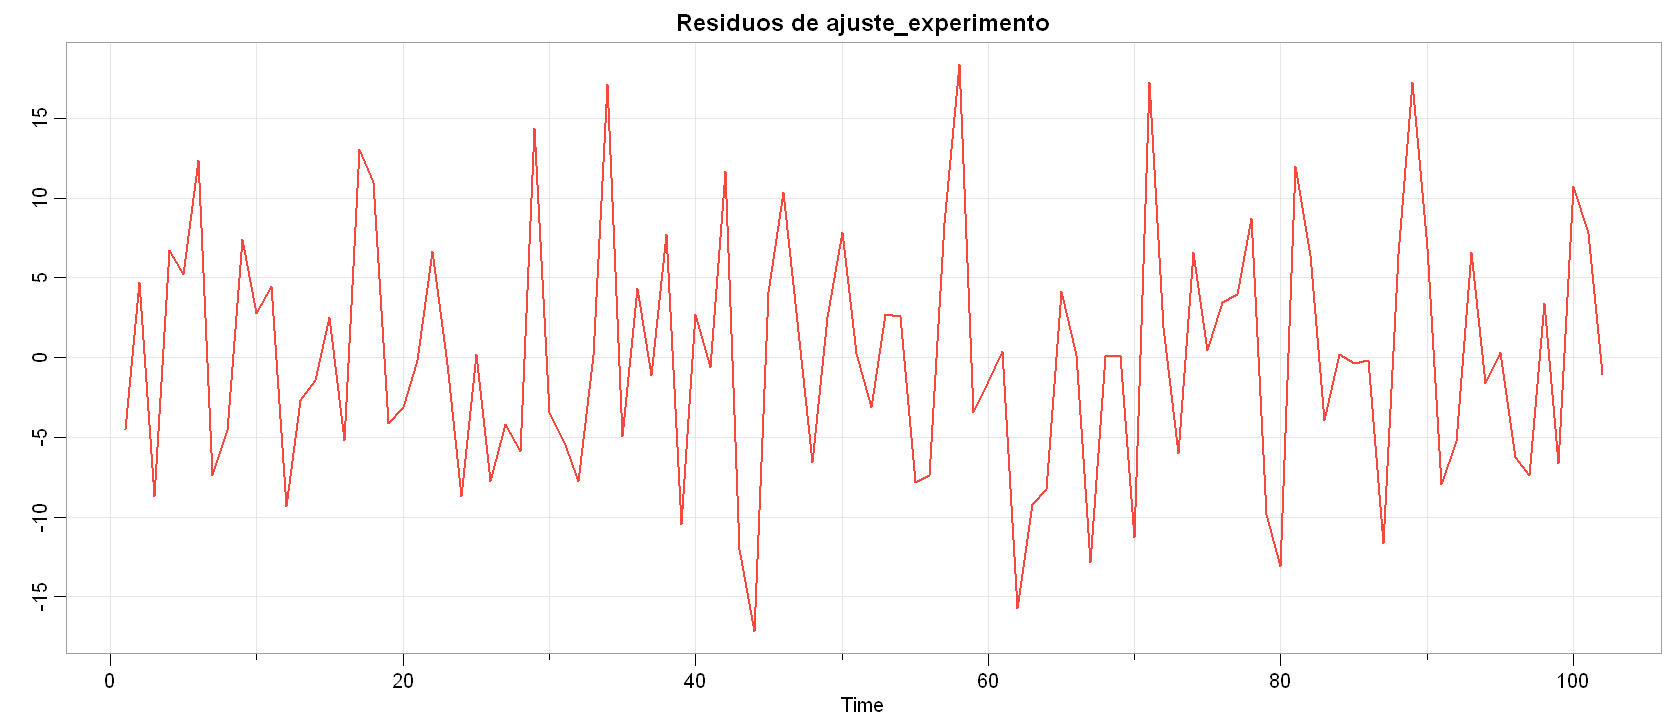

In [67]:
res_experimento = residuals(fit_autorregresivo_estacional2)
tsplot(res_experimento, ylab = '', main = 'Residuos de ajuste_experimento',col = 2, lwd = 2)

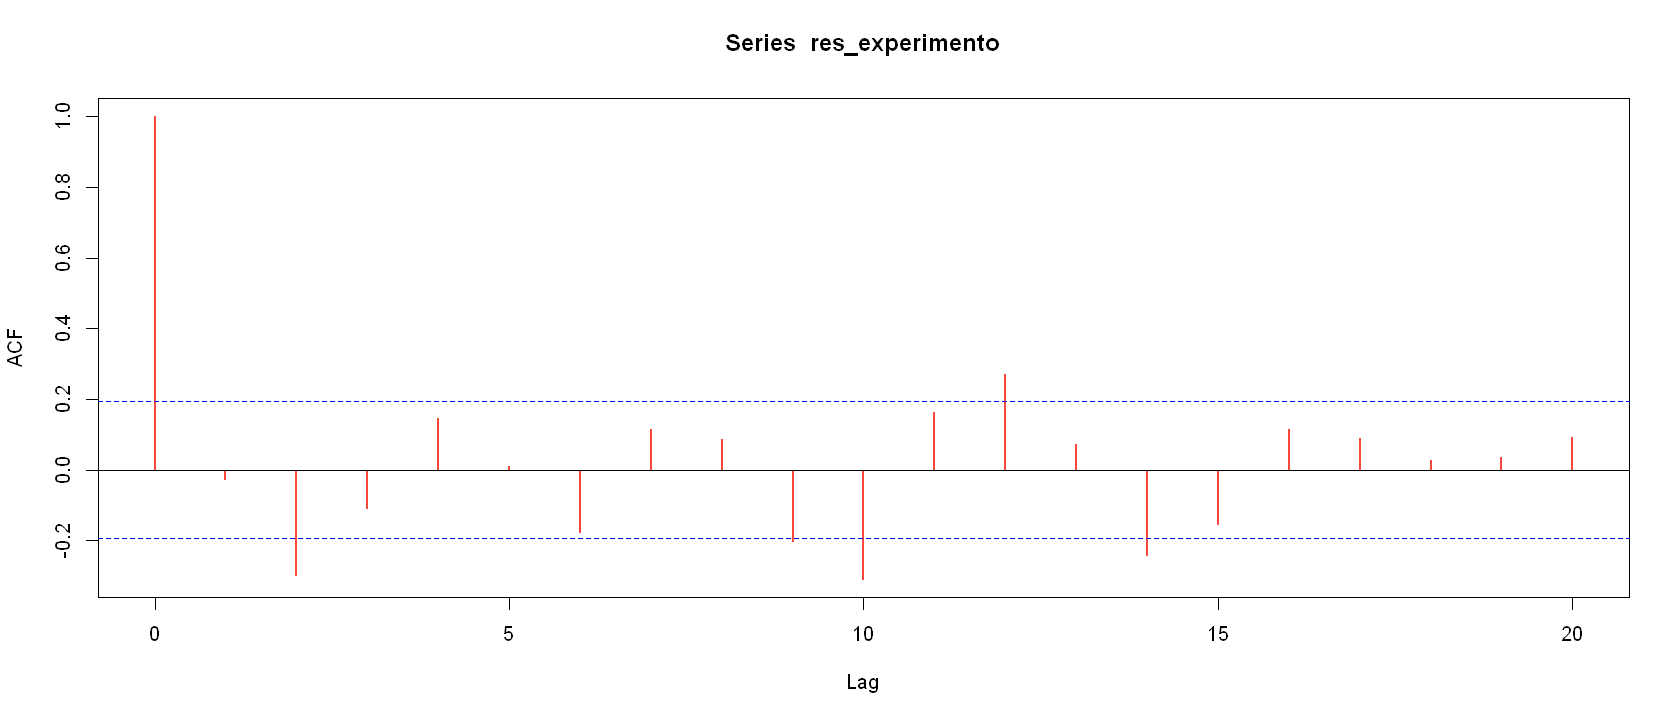

In [68]:
acf(res_experimento, col = 2, lwd = 2)

Se observa en el correlograma de los residuos de "fit_autorregresivo_estacional2" que estos no son enteramente ruido blanco.

In [69]:
RMSE_autor_estacional = sd(residuals(fit_autorregresivo_estacional2))
RMSE_autor_estacional

[1] 7.721679

Este RMSE dio más alto que el obtenido para el ajuste fit_p1 del principio, en donde trabajamos la parte estacional sobre la serie histórica, por lo cual descartamos este análisis.

ANÁLISIS APARTADO 2:

In [70]:
# PREGUNTAR ESTE APARTADO AR(6) POR LA SIGNIFICACION DE SUS COEFICIENTES Y EL SENTIDO DE HACERLO EN SÍ MISMO
fit_autorregresivo_estacional3 = Arima(xmean, order = c(6,0,0), include.mean = F)
fit_autorregresivo_estacional3

Series: xmean 
ARIMA(6,0,0) with zero mean 

Coefficients:
          ar1      ar2      ar3      ar4      ar5     ar6
      -0.0403  -0.3292  -0.2764  -0.1848  -0.0696  0.2696
s.e.   0.0923   0.0935   0.0968   0.0975   0.0941  0.0942

sigma^2 estimated as 50.77:  log likelihood=-363.03
AIC=740.06   AICc=741.18   BIC=758.83

ANÁLISIS APARTADO 3:

Efectuamos un AUTO ARIMA sobre la serie original "x".
La función auto.arima() usa nsdiffs() para determinar "D" (el número de diferencias estacionales a usar) y ndiffs() para determinar "d" (el número de diferencias ordinarias a utilizar):


In [71]:
fit_autoarima = auto.arima(x)
fit_autoarima

Series: x 
ARIMA(1,0,0)(2,1,0)[12] 

Coefficients:
          ar1     sar1     sar2
      -0.2643  -0.6856  -0.3571
s.e.   0.0994   0.0974   0.0990

sigma^2 estimated as 42.99:  log likelihood=-318.66
AIC=645.33   AICc=645.77   BIC=655.58

El resultado es un Seasonal Arima (o Sarima)

El Sarima es una extensión del Arima y agrega tres nuevos hiperparámetros para especificar la autorregresión (AR), diferenciación (I) y promedio móvil (MA) para el componente estacional de la serie, así como un parámetro adicional para el período de la estacionalidad "s". En este caso el Sarima tiene s = 12 datos mensuales.

Observamos que para la parte autorregresiva, la función auto.arima NO consideró ningún orden de integración, lo cual verifica que hicimos correcto en trabajar nuestra serie histórica sin diferenciarla.


HABLEN ALGO SARIMA!!!!


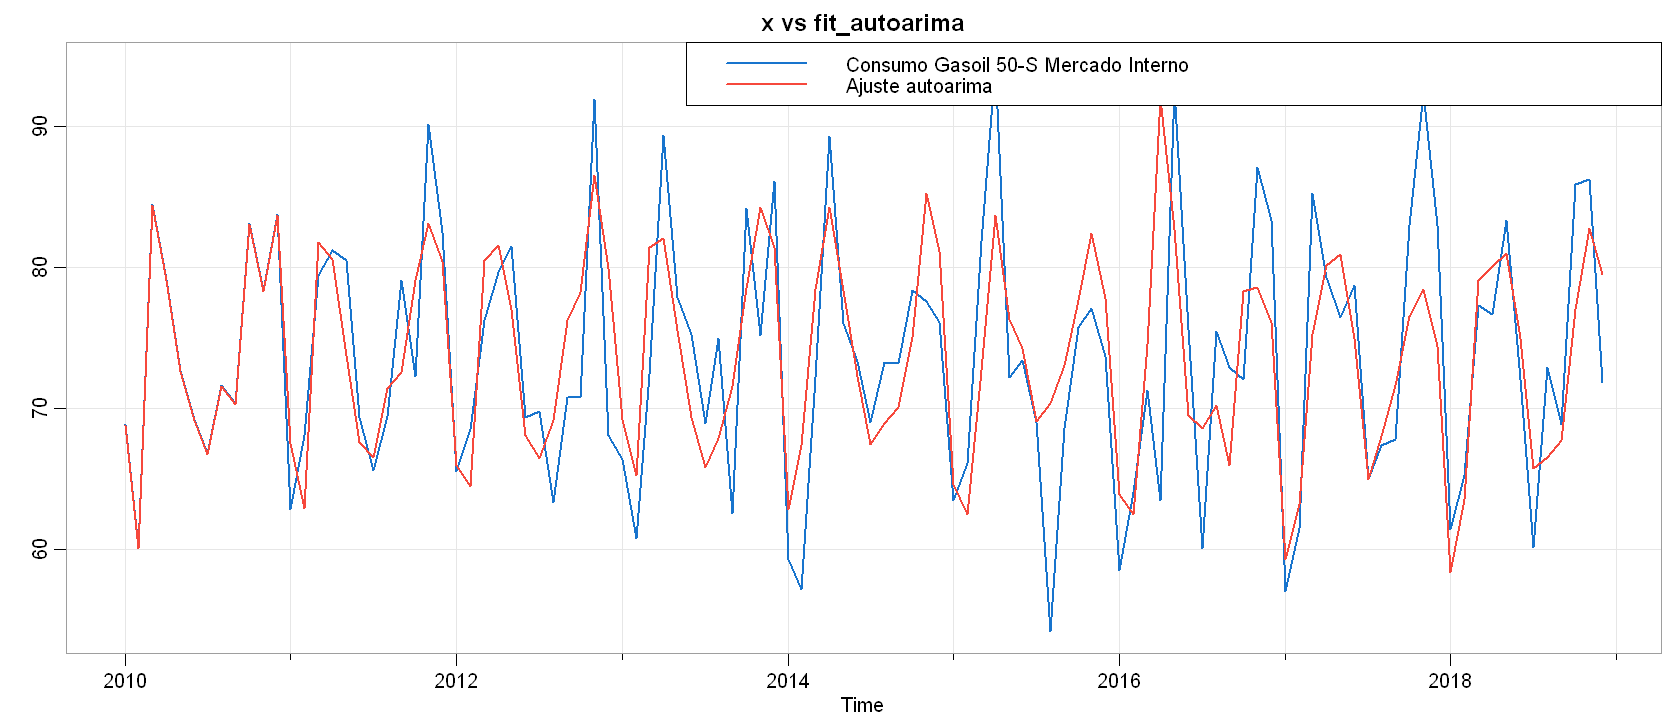

In [72]:
tsplot(x, main = "x vs fit_autoarima", ylab = '', col = 4, lwd = 2)
ajuste_autorima = ts(fitted(fit_autoarima), start = 2010, frequency =12)
lines(ajuste_autorima, col = 2, lwd = 2)

legend("topright", legend = c("Consumo Gasoil 50-S Mercado Interno", "Ajuste autoarima"), lwd = 2, col = c(4, 2))
# PORQUE NO EMPIEZA EN 2010 EL PLOT DE X???

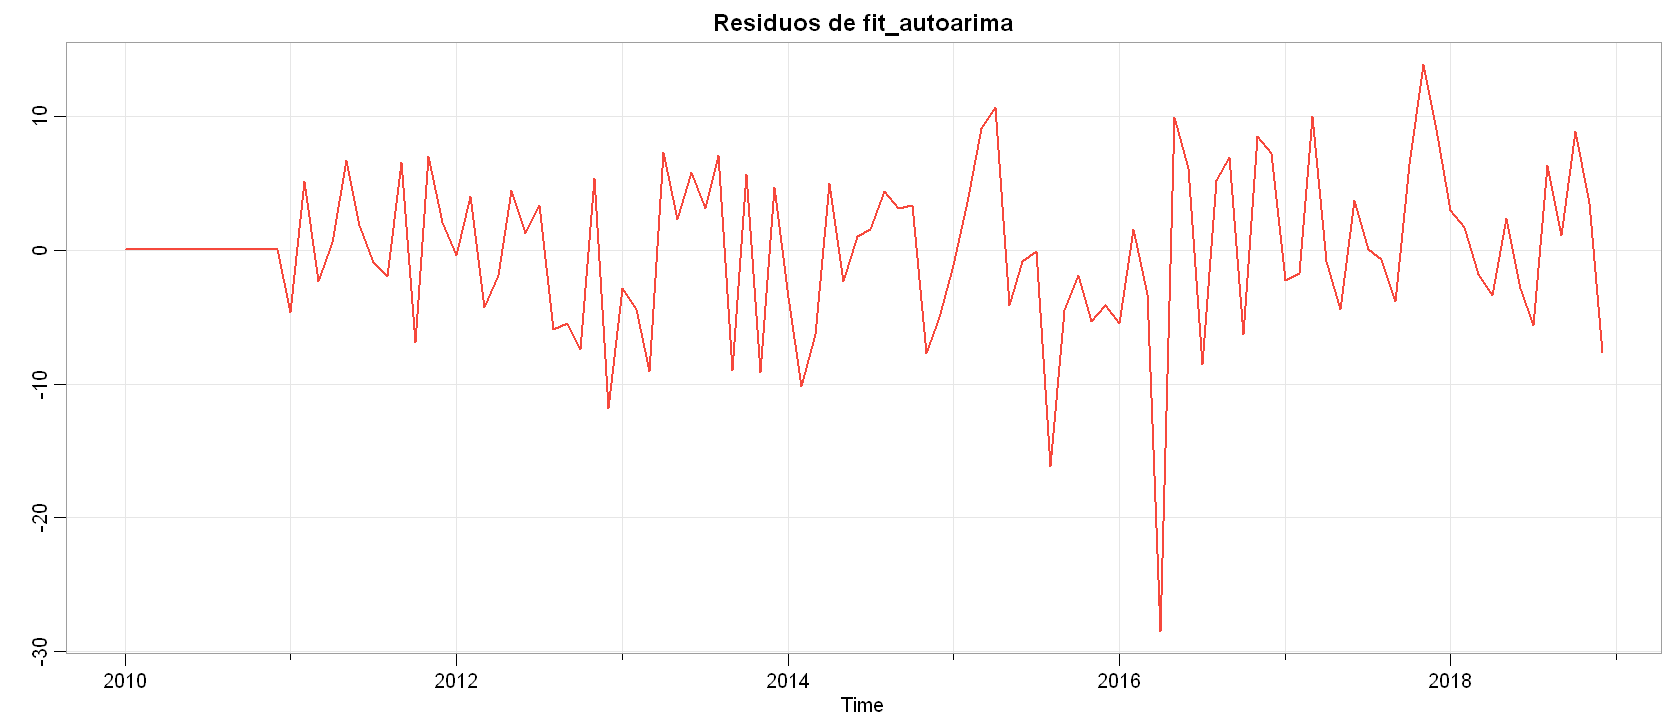

In [73]:
tsplot(residuals(fit_autoarima), ylab = '', main = 'Residuos de fit_autoarima', col = 2, lwd = 2)

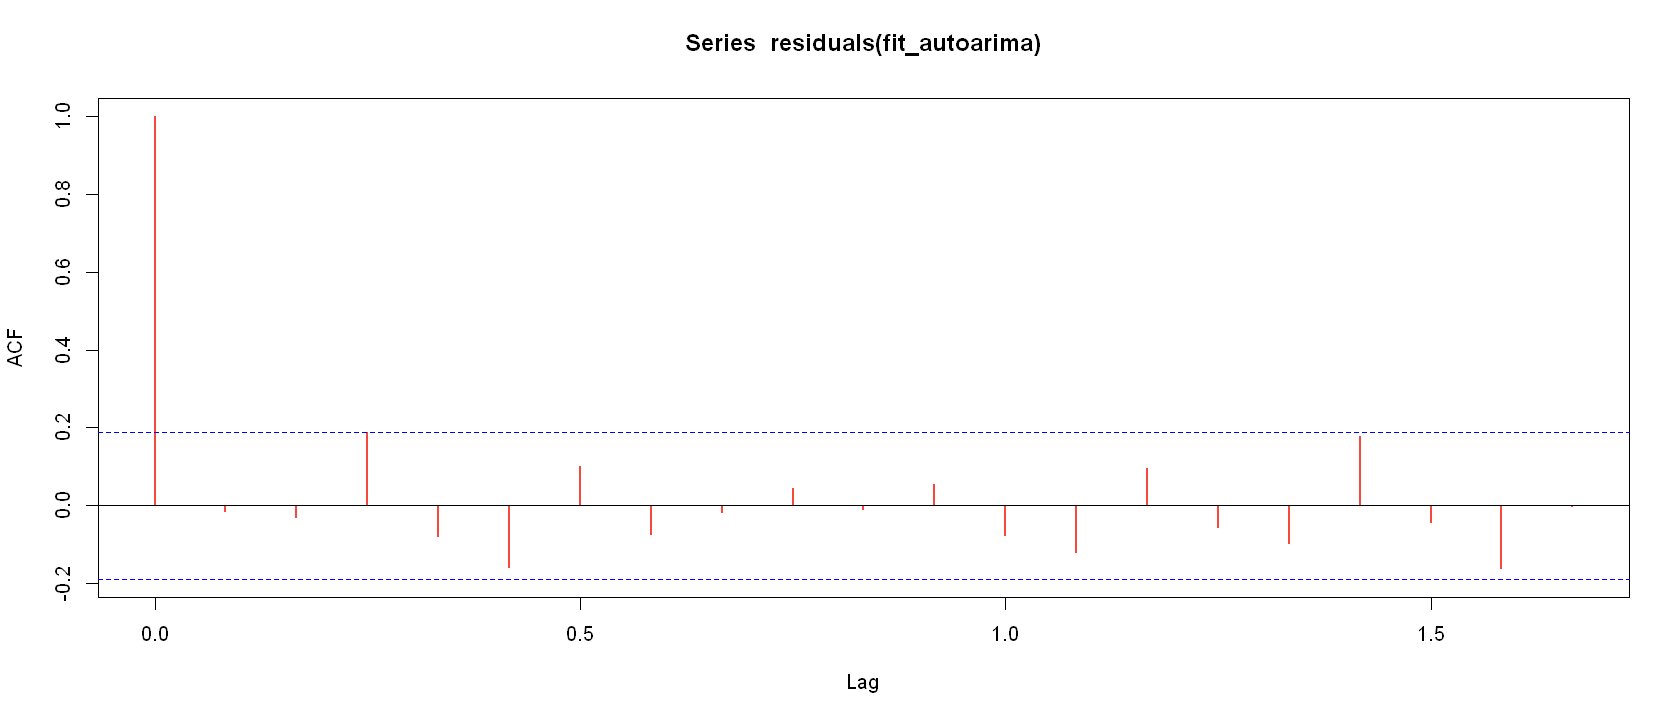

In [74]:
acf(residuals(fit_autoarima), col = 2, lwd = 2)


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0)(2,1,0)[12]
Q* = 25.341, df = 19, p-value = 0.1496

Model df: 3.   Total lags used: 22



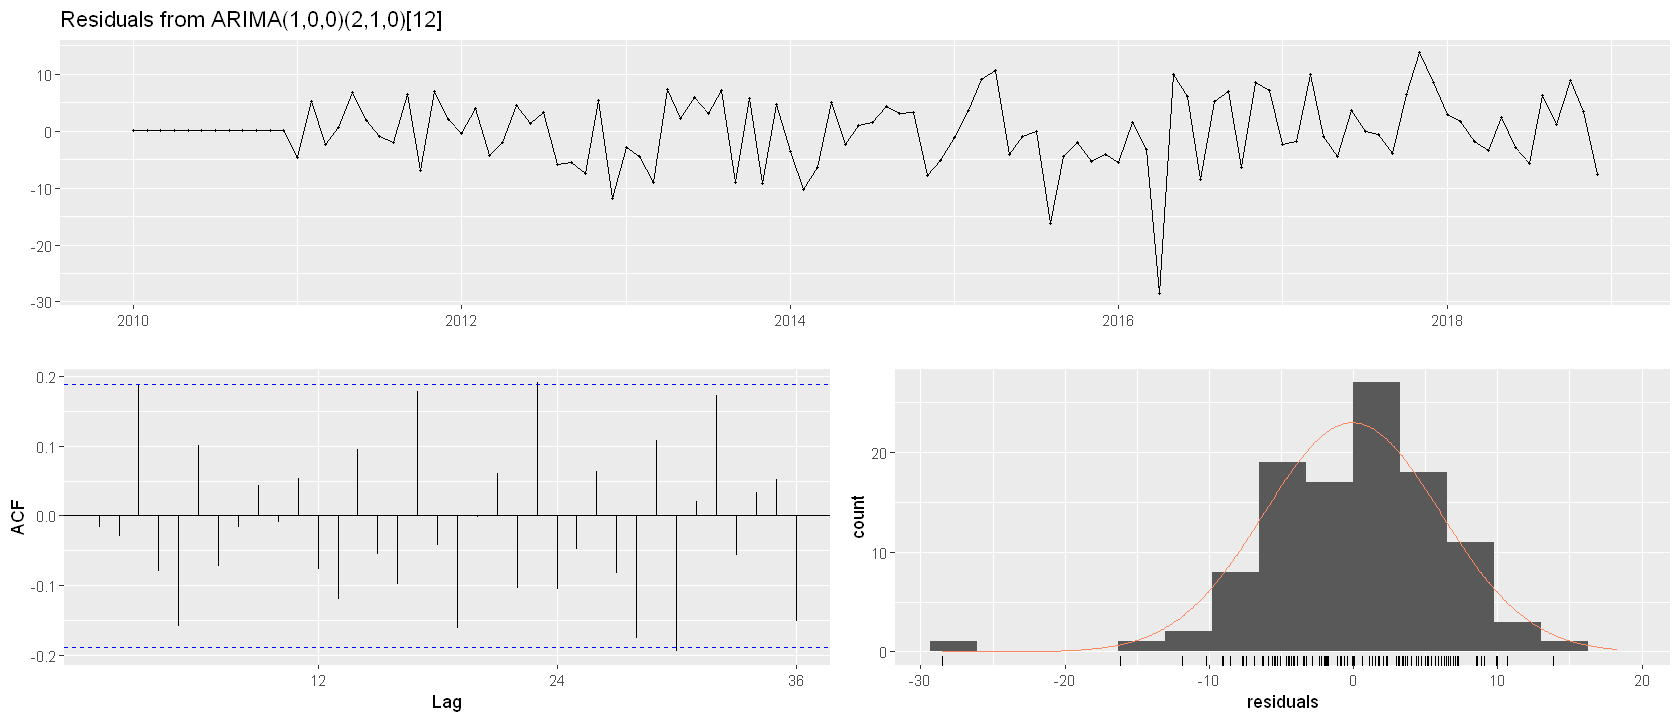

In [75]:
checkresiduals(fit_autoarima)

         Point Forecast    Lo 80    Hi 80    Lo 95     Hi 95
Jan 2019       61.03802 52.63507 69.44097 48.18682  73.88922
Feb 2019       63.03977 54.34825 71.73130 49.74723  76.33231
Mar 2019       77.94230 69.23097 86.65363 64.61947  91.26513
Apr 2019       72.81009 64.09738 81.52280 59.48515  86.13502
May 2019       84.45164 75.73884 93.16445 71.12656  97.77673
Jun 2019       75.51840 66.80558 84.23121 62.19330  88.84349
Jul 2019       61.72604 53.01322 70.43885 48.40094  75.05113
Aug 2019       72.01680 63.30399 80.72962 58.69171  85.34190
Sep 2019       69.97975 61.26693 78.69256 56.65465  83.30484
Oct 2019       80.01183 71.29901 88.72464 66.68673  93.33692
Nov 2019       88.59173 79.87892 97.30455 75.26664 101.91683
Dec 2019       79.64373 70.93092 88.35654 66.31863  92.96883
Jan 2020       59.73386 50.62941 68.83831 45.80981  73.65791
Feb 2020       63.21491 54.08372 72.34609 49.24997  77.17984
Mar 2020       80.37165 71.23860 89.50470 66.40386  94.33944
Apr 2020       76.41161 

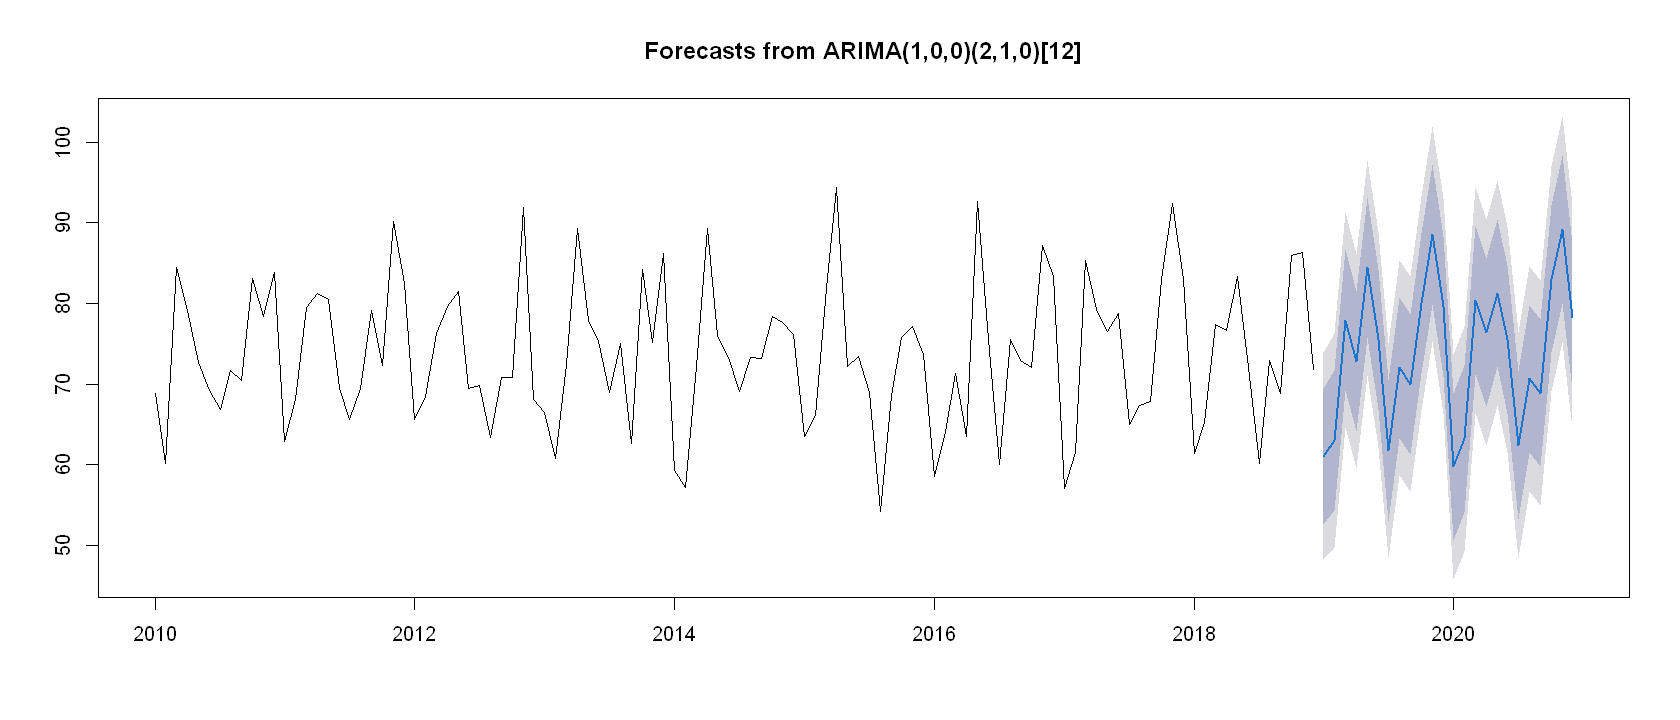

In [76]:
pred_autoarima = forecast(fit_autoarima, h = 24)
pred_autoarima
plot(forecast(fit_autoarima, h = 24))


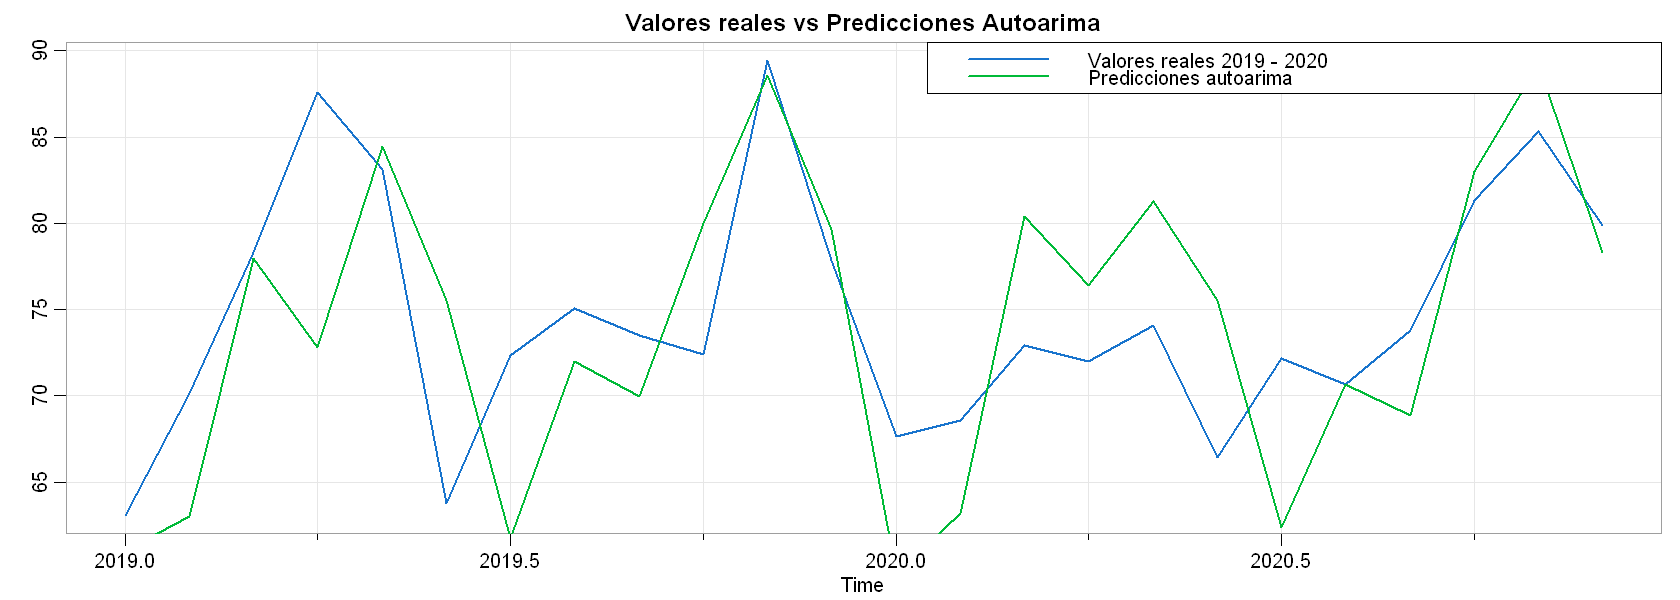

In [77]:
options(repr.plot.width = 14, repr.plot.height = 5)

predicciones_autoarima = ts(pred_autoarima$mean, start = 2019, freq = 12)
tsplot(ts(consumo_2019_2020$consumo_miles_m3, start = 2019, freq = 12), ylab = '', main = "Valores reales vs Predicciones Autoarima", col = 4, lwd = 2)
lines(ts(predicciones_autoarima, start = 2019, freq = 12), col = 3, lwd = 2)

legend("topright", legend = c("Valores reales 2019 - 2020", "Predicciones autoarima"), lwd = 2, col = c(4, 3))

RMSE del ajuste fit_autoarima sobre la serie original x:

In [78]:
RMSE_autoarima = sd(residuals(fit_autoarima))
RMSE_autoarima

[1] 6.112599

RMSE de las predicciones del autoarima 2019 - 2020 sobre la serie original x:

In [79]:
rmse_predicciones_autoarima = rmse(valores_reales, predicciones_autoarima)
rmse_predicciones_autoarima

[1] 6.618955

Si comparamos el "rmse_predicciones_autoarima" (generado a partir del modelo obtenido mediante la función "auto.arima" para analizar un arima estacional) con el "rmse_modelo_econometrico_estacional" (siendo este último una variabilidad determinística ya que sus componentes fueron obtenidos de forma determinística), vemos que el primero de ellos es superior. Por este motivo, nuestro ajuste con frecuencias específicas de senos y cosenos, obtenidas a partir del periodograma generó un mejor resultado.

4.88990509641538 < 6.61895458040406

PLOTEO RESUMEN DE PREDICCIONES: Predicciones predeterministicas de senos y cosenos (modelo econométrico)/ Predicciones completas (modelo econométrico)/ Predicciones Red Neuronal (mejor ejecución)/ Predicciones Autoarima 

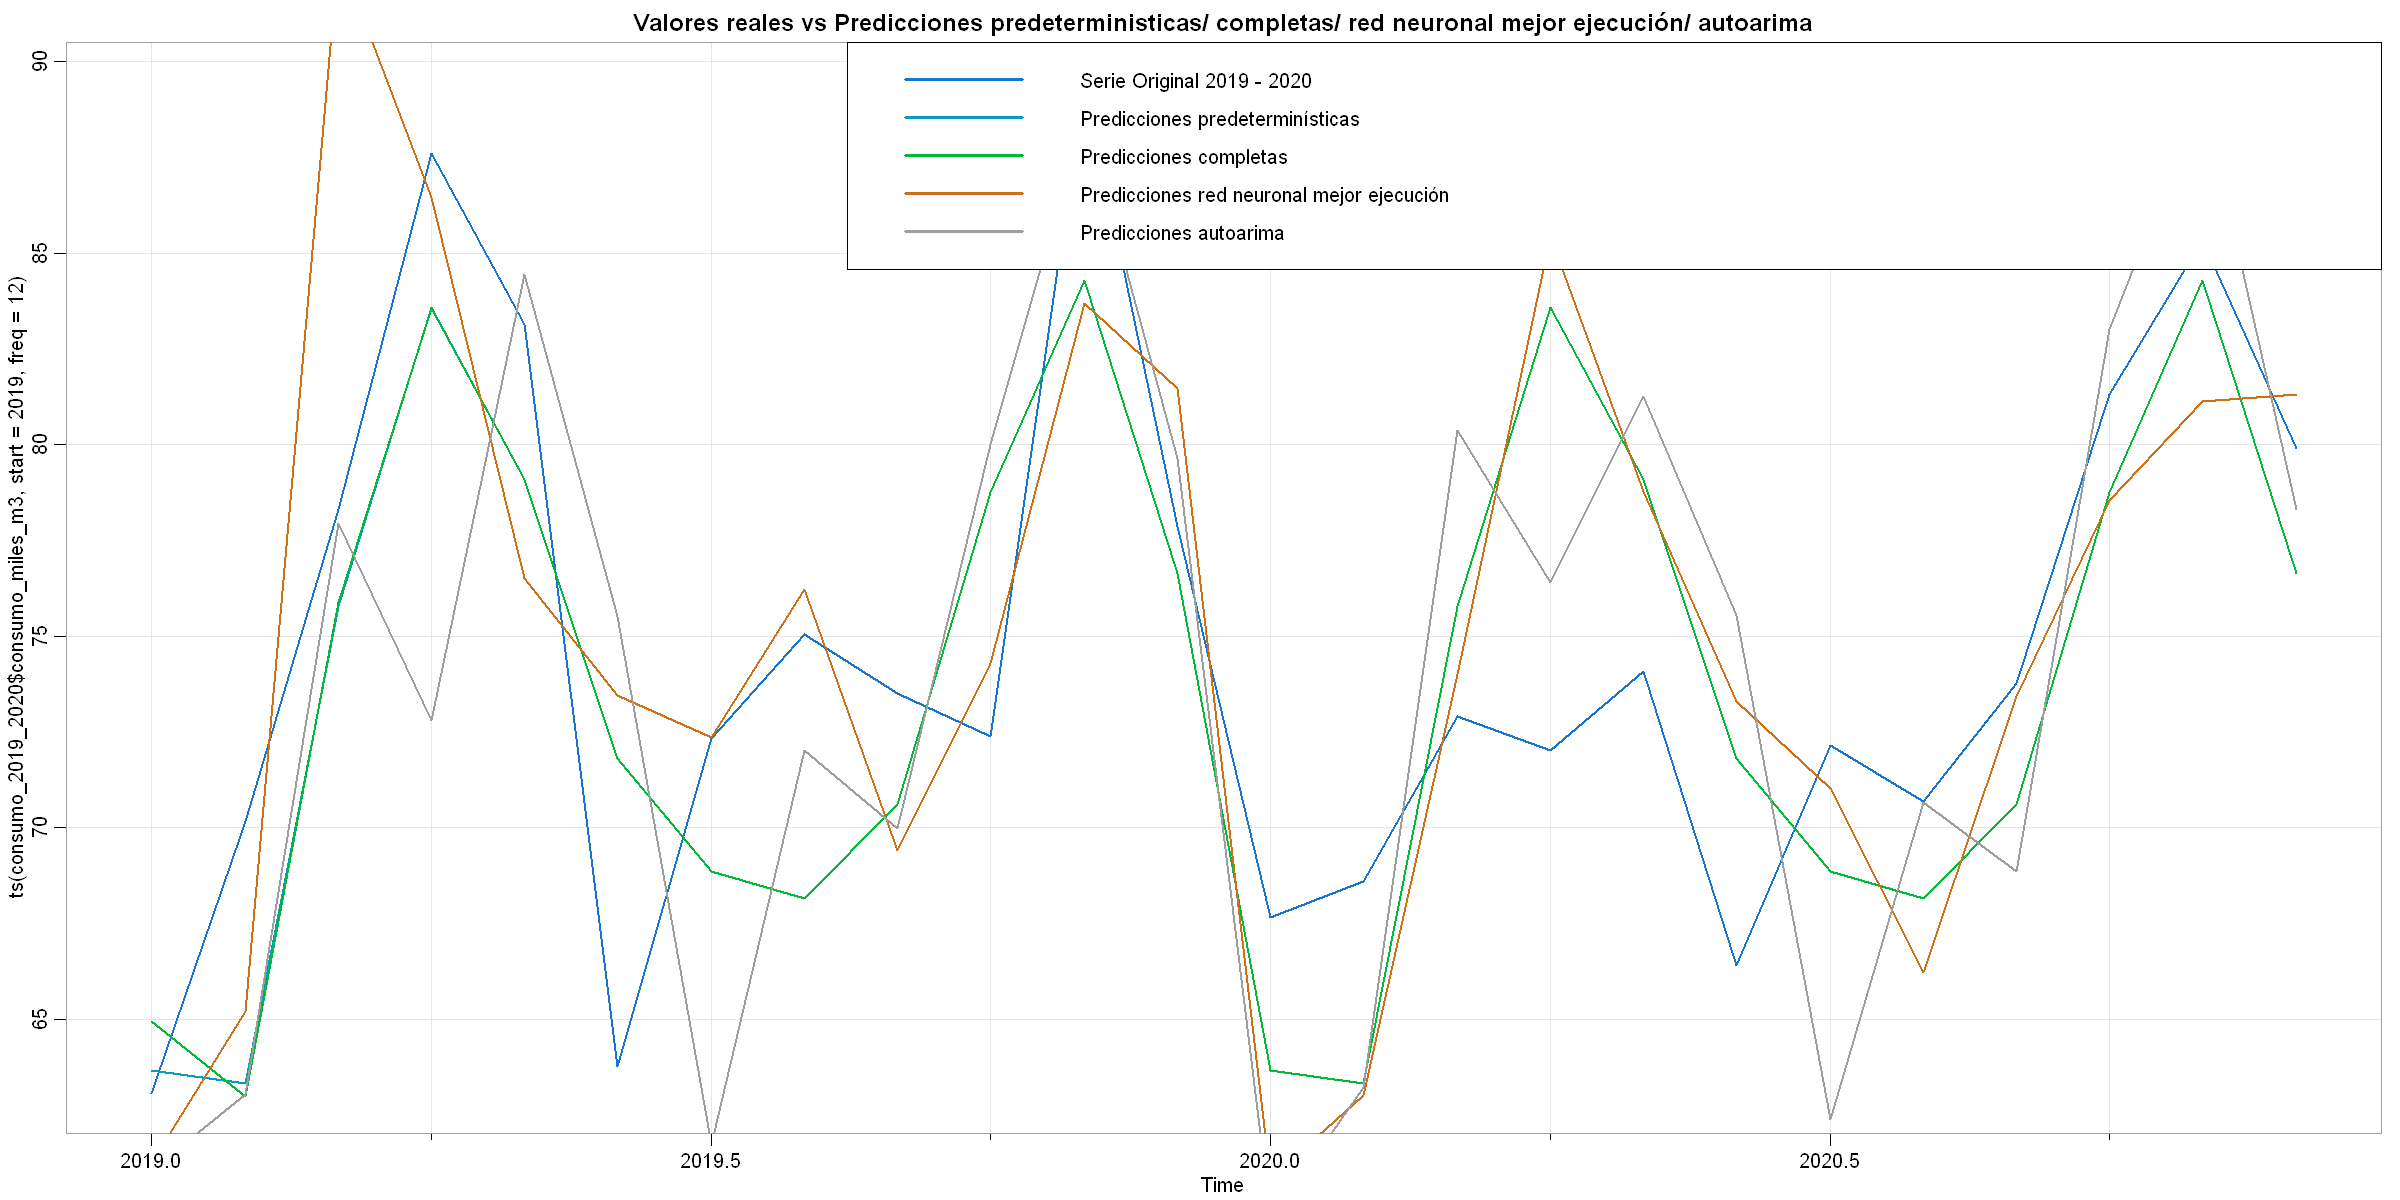

In [80]:
options(repr.plot.width = 20, repr.plot.height = 10)
tsplot(ts(consumo_2019_2020$consumo_miles_m3, start = 2019, freq = 12), main = "Valores reales vs Predicciones predeterministicas/ completas/ red neuronal mejor ejecución/ autoarima", col = 4, lwd = 2)
lines(ts(pred_original, start = 2019, freq = 12), col = 5, lwd = 2)
lines(ts(predA_media_f, start = 2019, freq = 12), col = 3, lwd = 2)
lines(ts(mejor_ejecucion_red, start = 2019, freq = 12), col = 7, lwd = 2)
lines(ts(predicciones_autoarima, start = 2019, freq = 12), col = 8, lwd = 2)

legend("topright", legend = c("Serie Original 2019 - 2020", "Predicciones predeterminísticas", "Predicciones completas", "Predicciones red neuronal mejor ejecución", "Predicciones autoarima"),
       lwd = 3, col = c(4, 5, 3, 7, 8))

ANALISIS APARTADO 4:

ANALISIS DE CORRELACION CRUZADA:

LA CORRELACION CRUZADA SIRVE PARA EXPLICAR UNA SERIE A PARTIR DE OTRA pero en OTRO momento del tiempo. Específicamente, la correlación cruzada compara una serie con otra serie que está en OTRO momento del tiempo.

In [81]:
area_cultivos <- read.csv("area_cultivos.csv")

In [82]:
consumo_aux= consumo[0:127,]

In [83]:
x_area_c= ts(area_cultivos$area_total, start = 2010, freq = 12)
x_consumo_g= ts(consumo_aux$consumo_miles_m3, start = 2010, freq = 12)


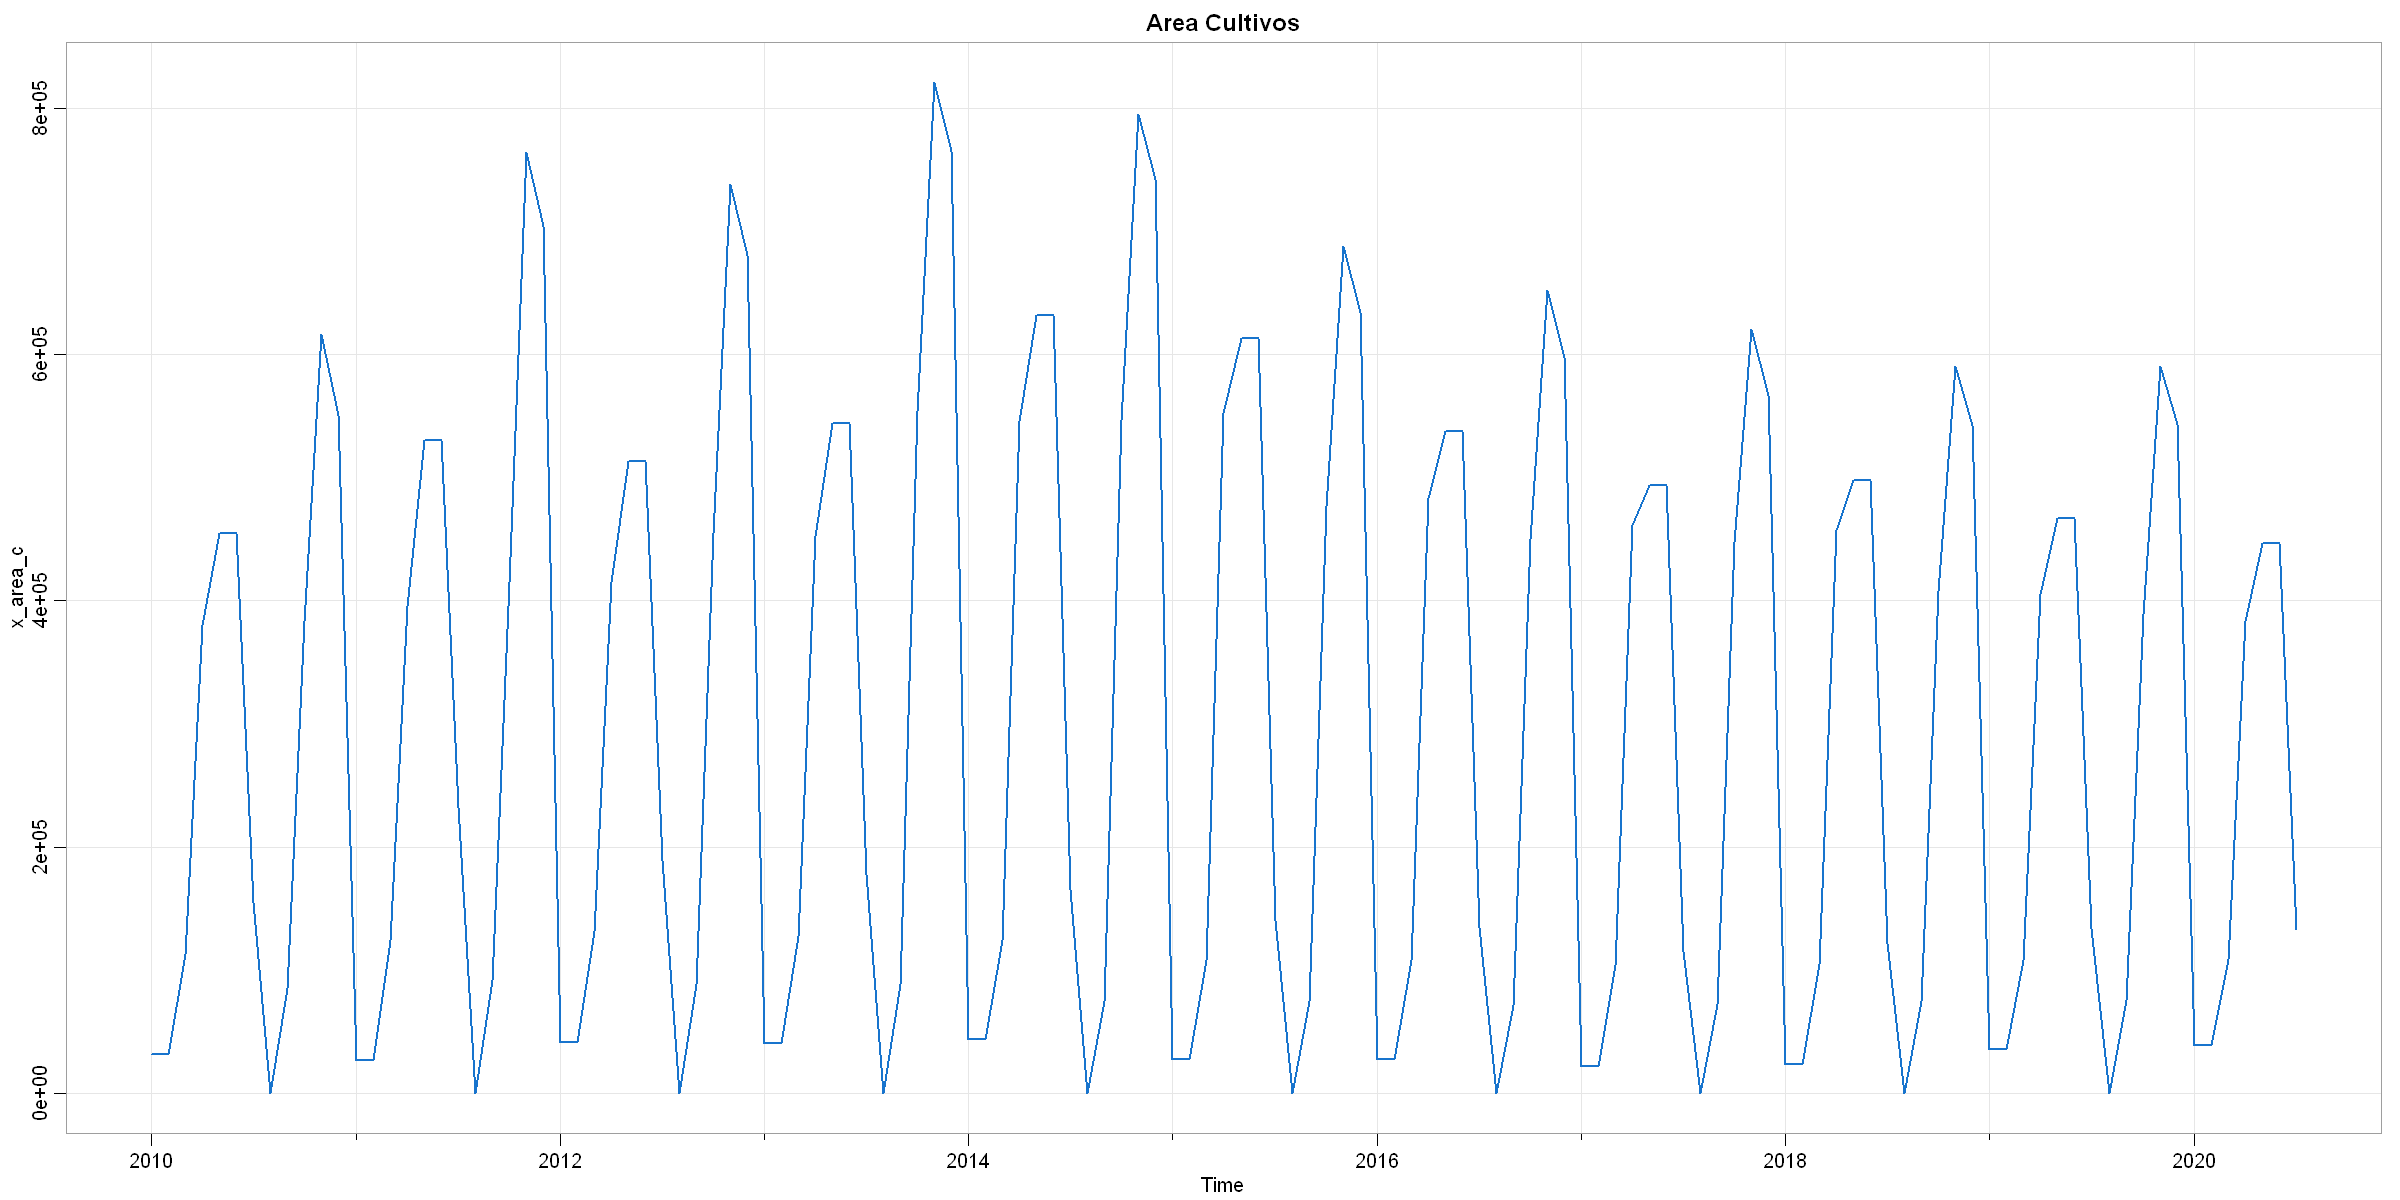

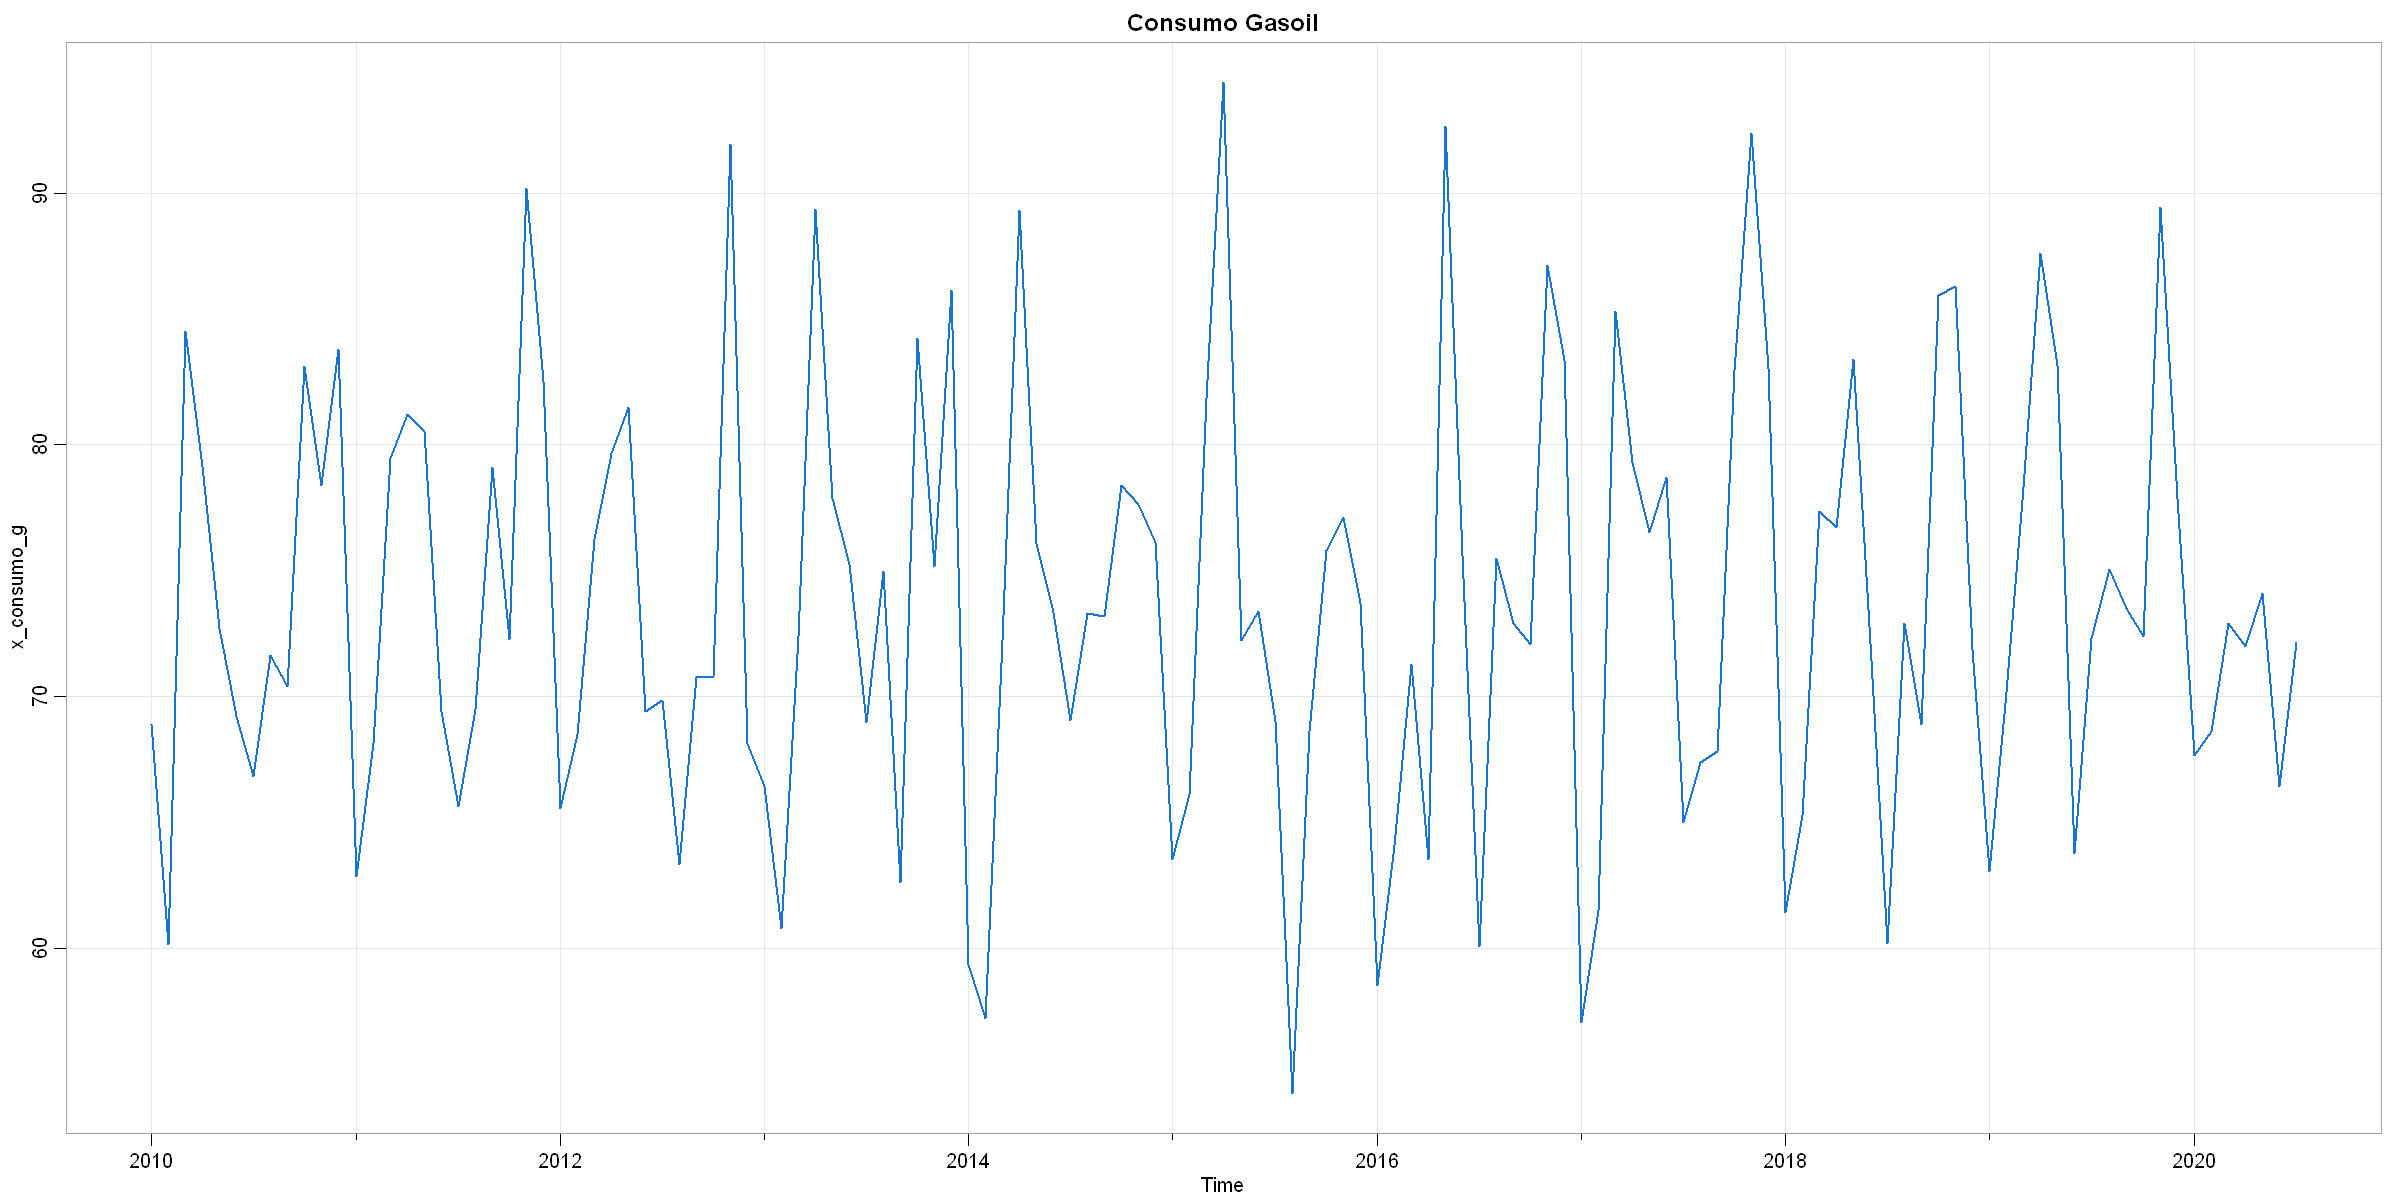

In [84]:
tsplot(x_area_c, main = 'Area Cultivos', col = 4, lwd = 2)
tsplot(x_consumo_g, main = 'Consumo Gasoil', col = 4, lwd = 2)

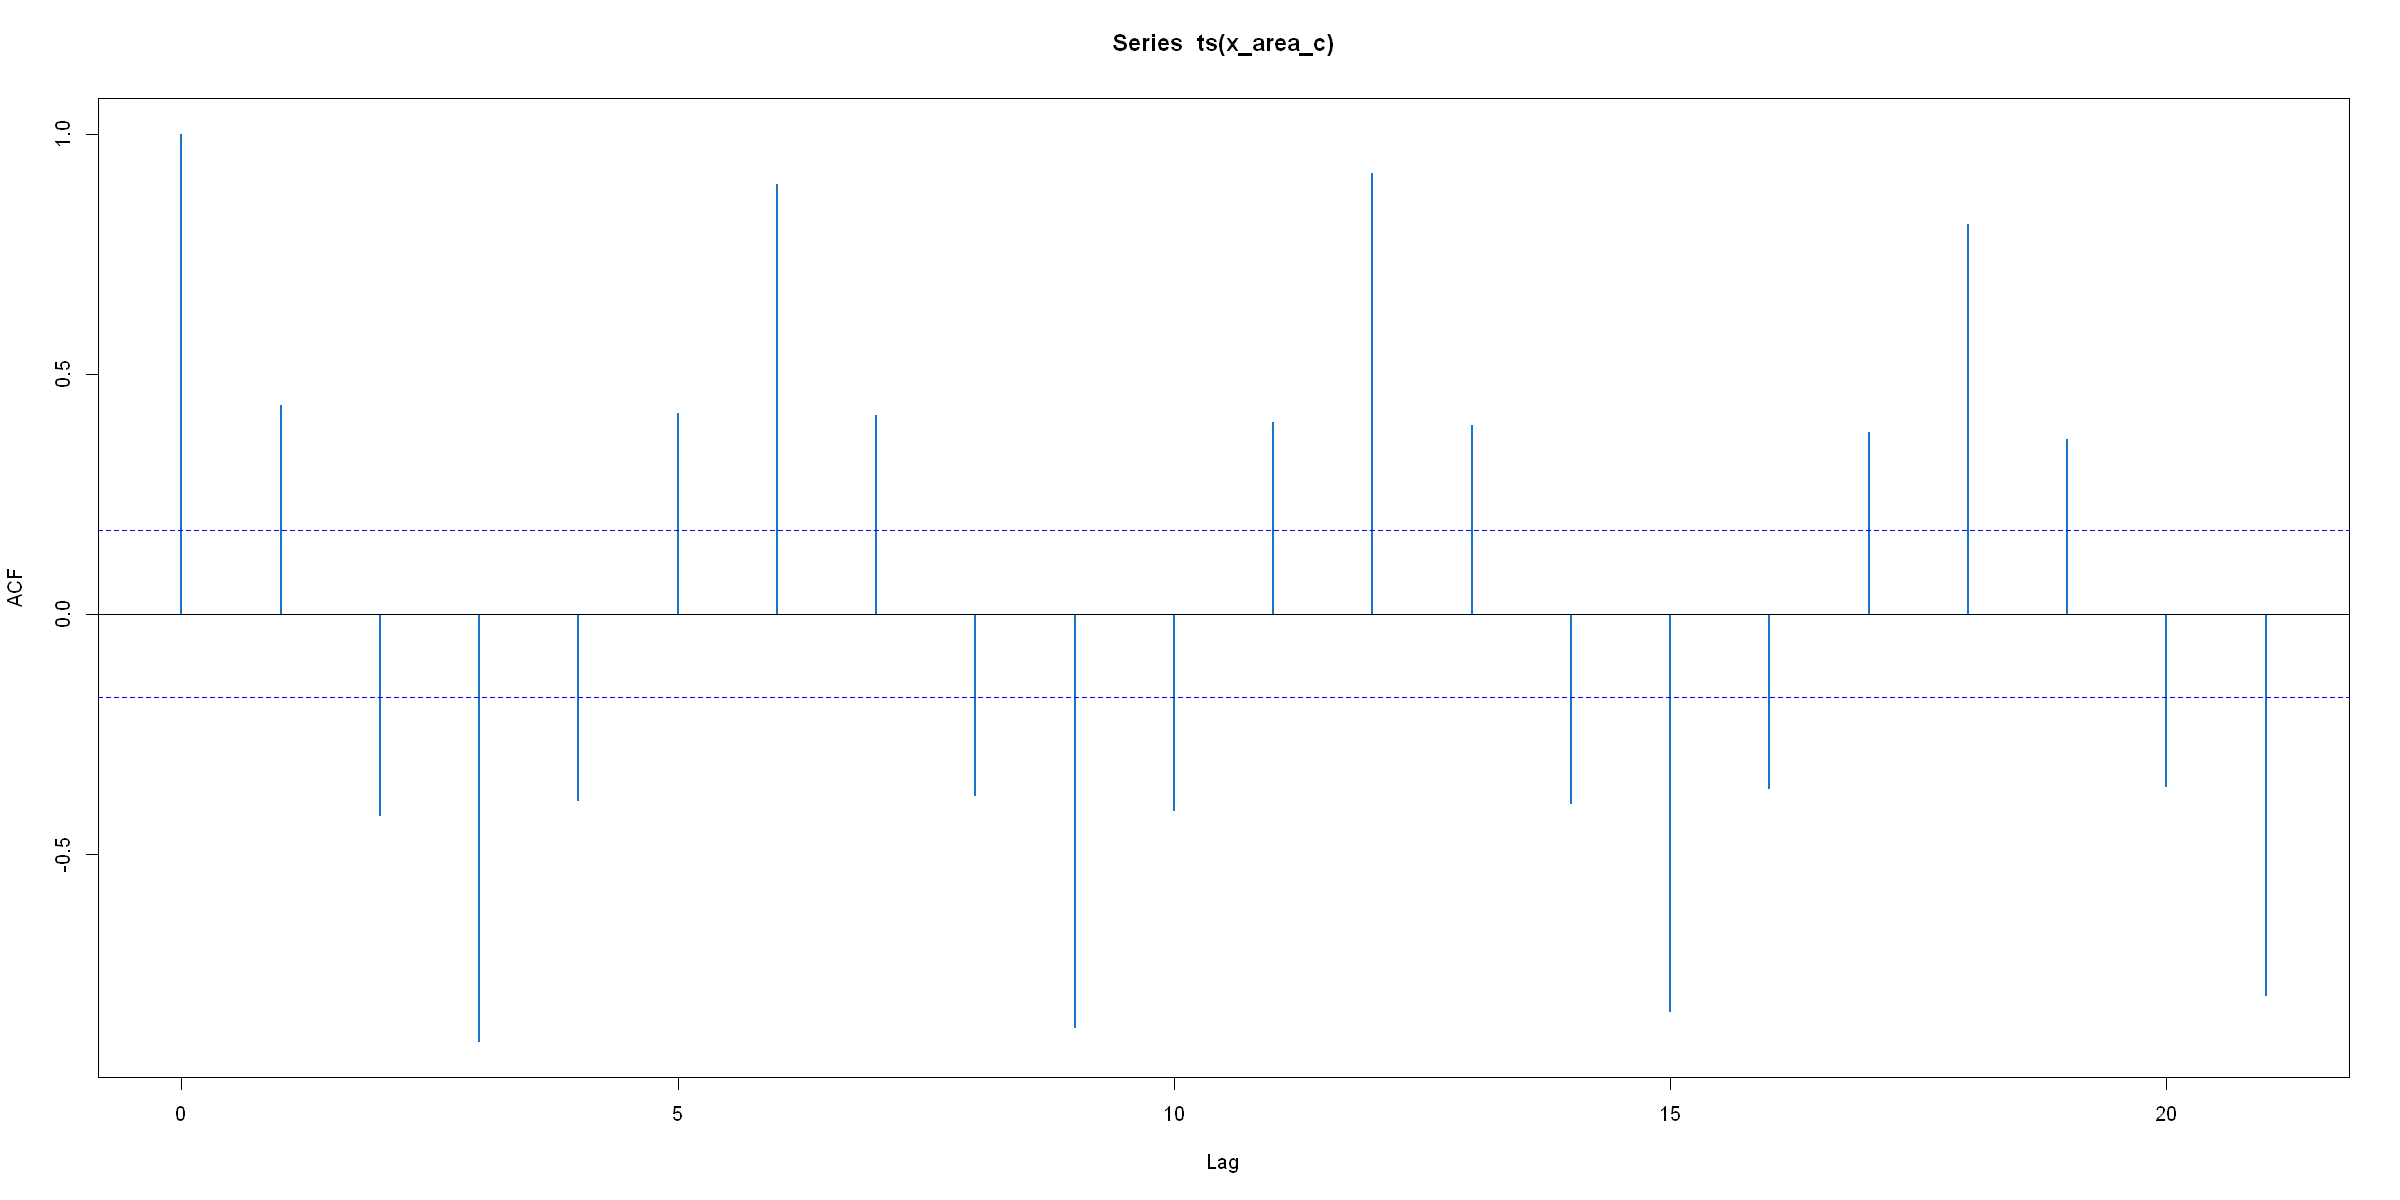

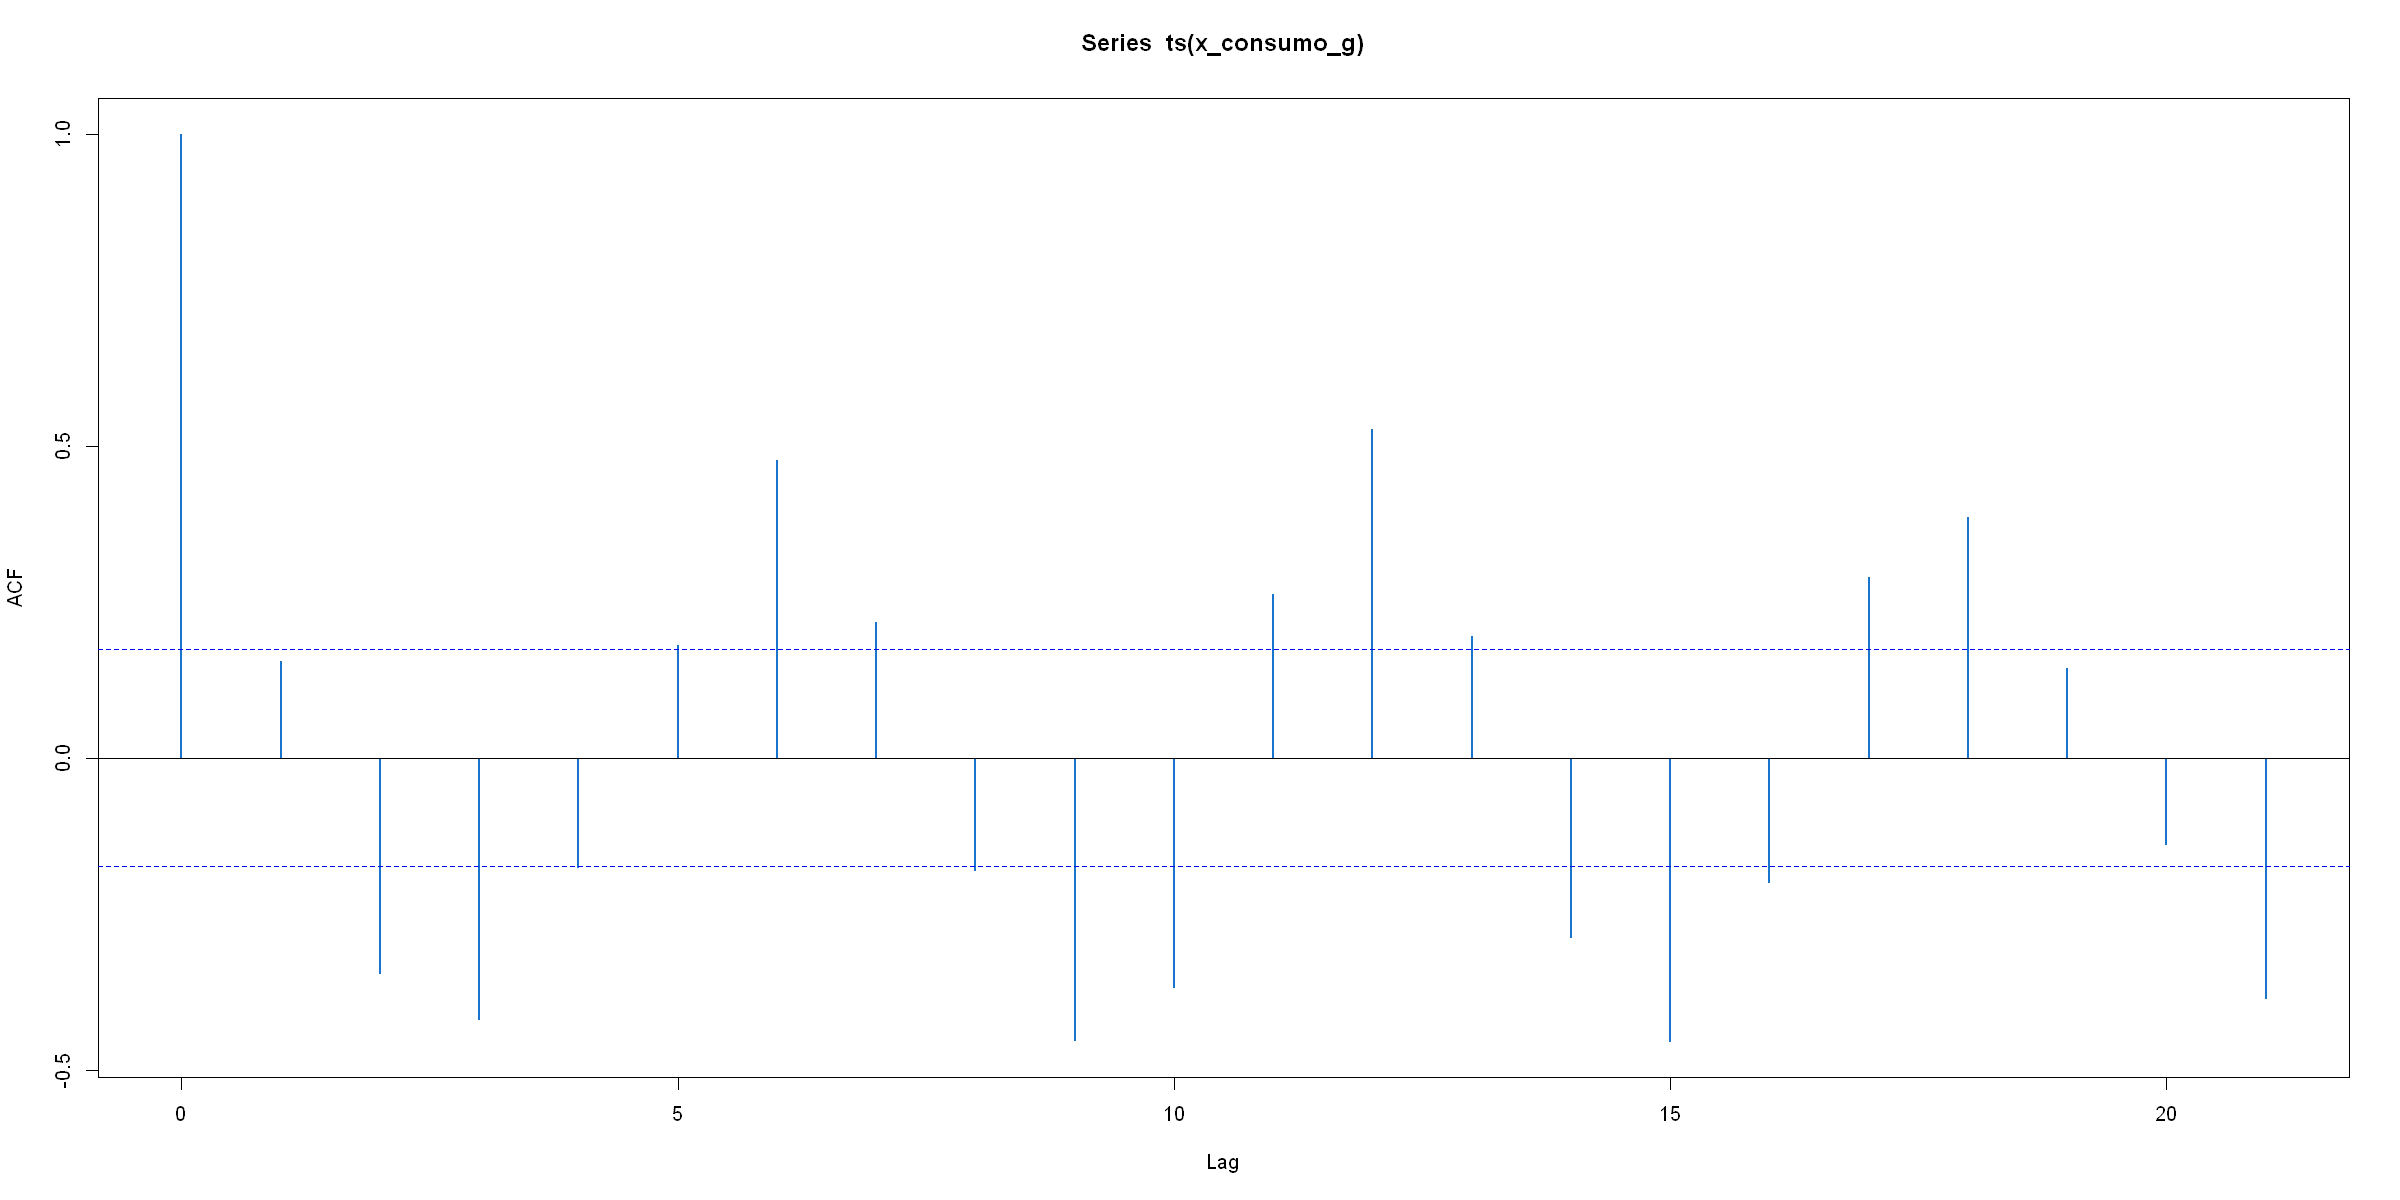

In [85]:
# AUTOCORRELACION DE LAS SERIES
autocorrelacionCultivos = acf(ts(x_area_c), col = 4, lwd = 2)
autocorrelacionGasoil = acf(ts(x_consumo_g), col = 4, lwd = 2)

CORRELACION CRUZADA

Correlación cruzada: Consideramos que deseamos explicar el consumo de gasoil a partir del area total de cultivo (ambas series mensuales)

Acá queremos que “area_total” prediga a “consumo_miles_m3”. Por ende la que corremos es “area_total” y “consumo_miles_m3” la dejamos quieta. Queremos entonces atender a lo que está del cero a la izquierda, porque significa que, por ejemplo, “area_total” DOS meses para atrás tiene una correlación negativa con “consumo_miles_m3”, CINCO meses para atrás, una positiva. Sin embargo, no tiene sentido ver del cero hacia a la derecha, porque nos dice por ejemplo, 3 meses hacia adelante, “area_total” se correlaciona con “consumo_miles_m3” de tal modo (pero para predecir “consumo_miles_m3” eso no nos sirve porque “consumo_miles_m3” ya habrá pasado para ese entonces). En cambio, del cero hacia la derecha sirve “consumo_miles_m3” para predecir “area_total”. 

Por eso, en este caso que queremos usar “area_total” para predecir “consumo_miles_m3”, ponemos “area_total” a la izquierda, y “consumo_miles_m3” a la derecha en el siguiente código con el comando “ccf”:


Previamente a realizar la correlación cruzada de las series mediante el comando "ccf" de R, vamos a quitarles las media, y luego quitaremos el Intercept de los ajustes que realicemos:

In [86]:
x_area_c = x_area_c - mean(x_area_c)
x_consumo_g = x_consumo_g - mean(x_consumo_g)

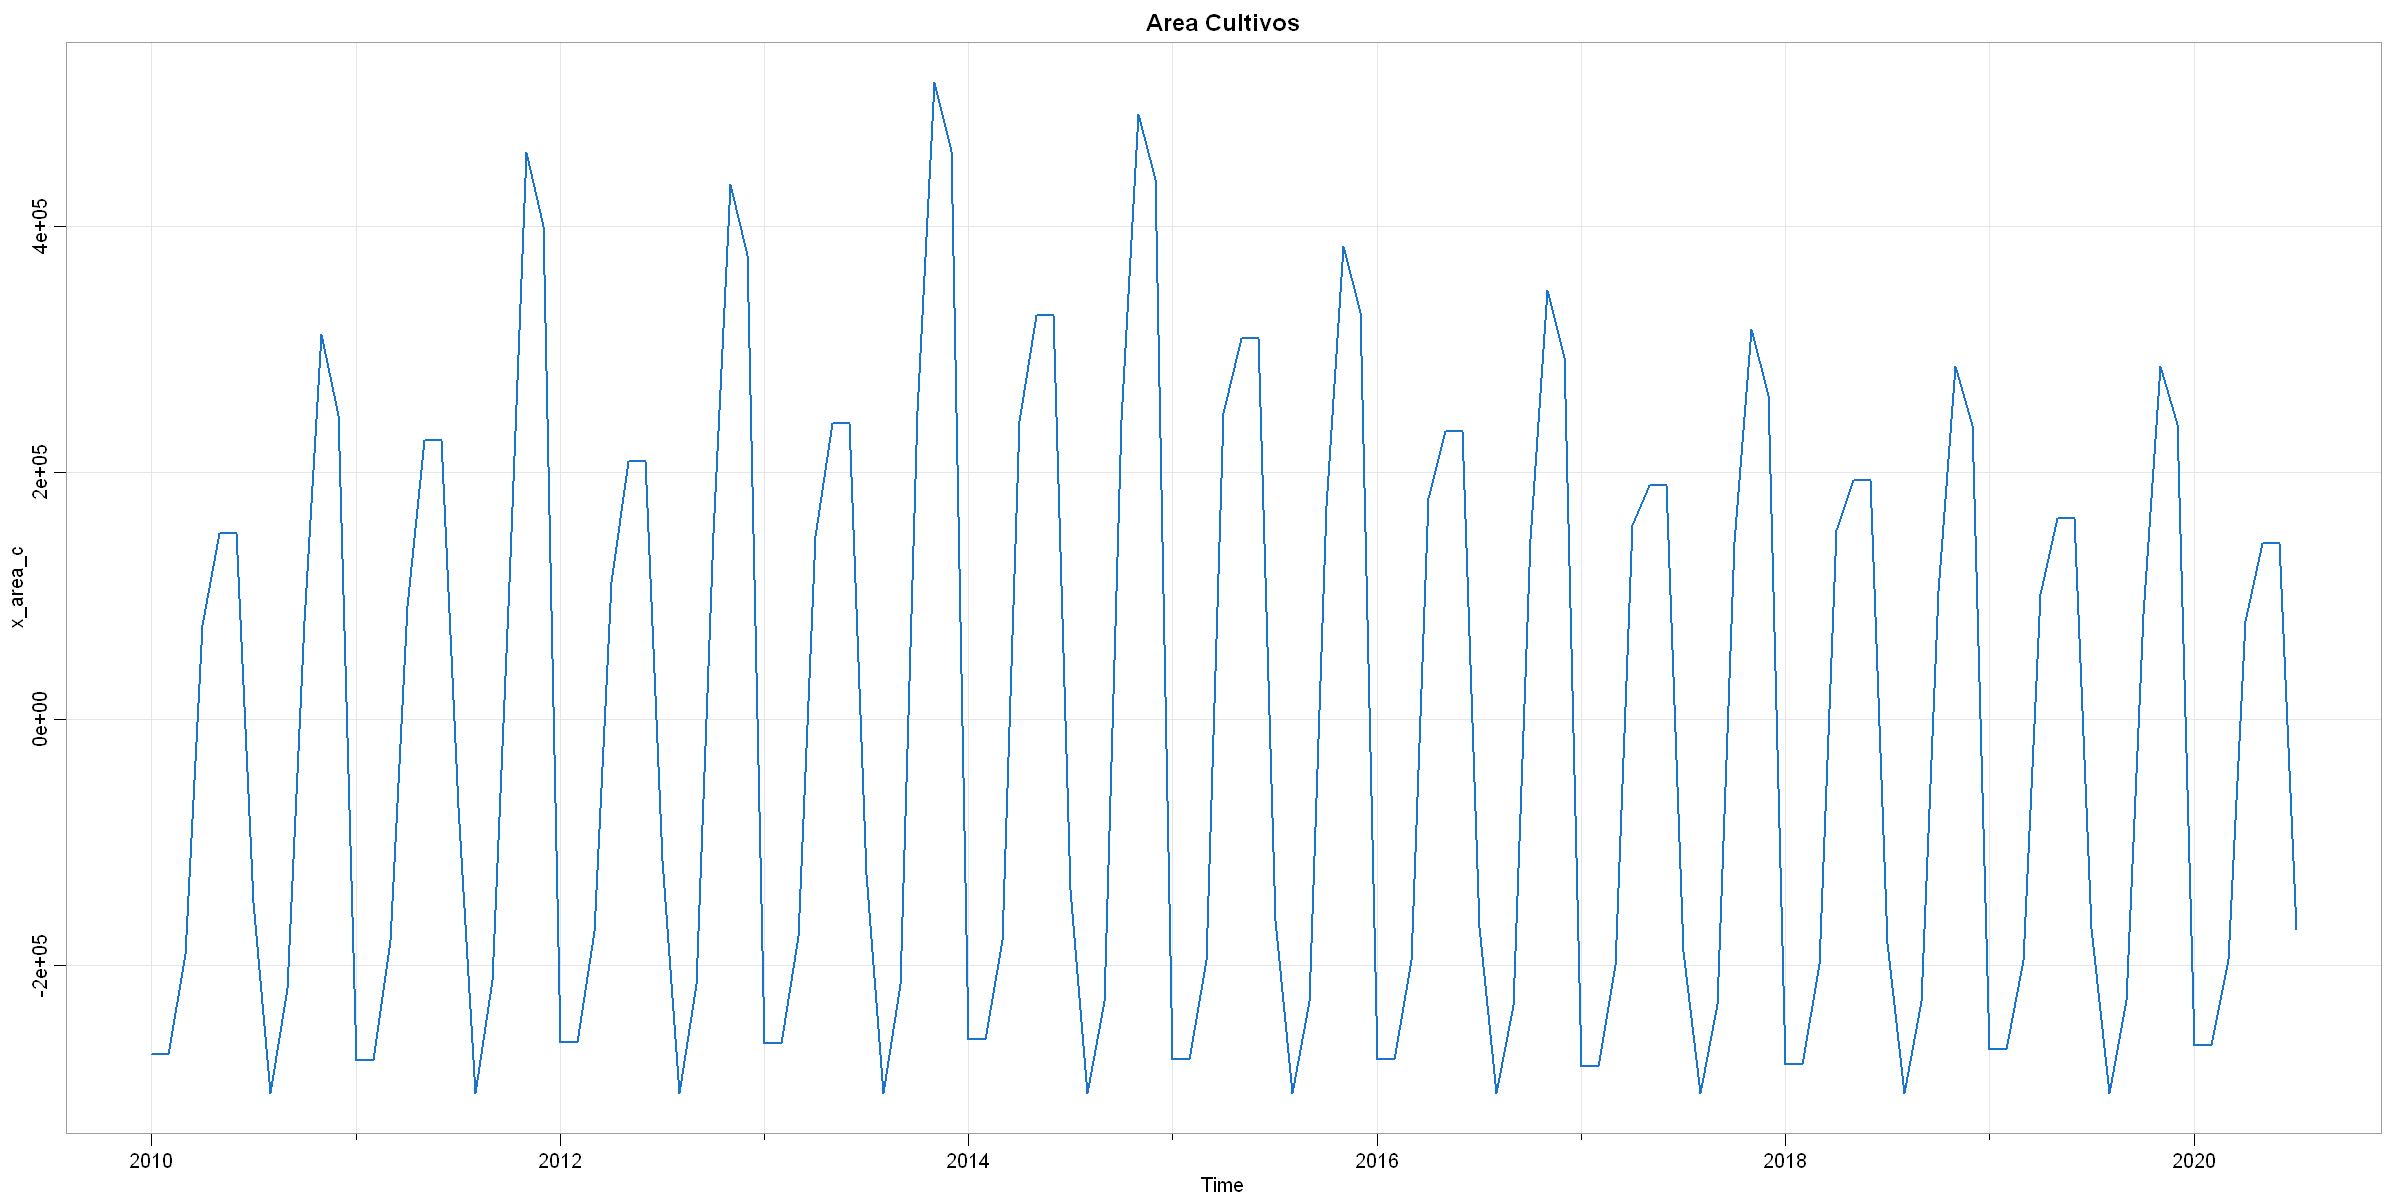

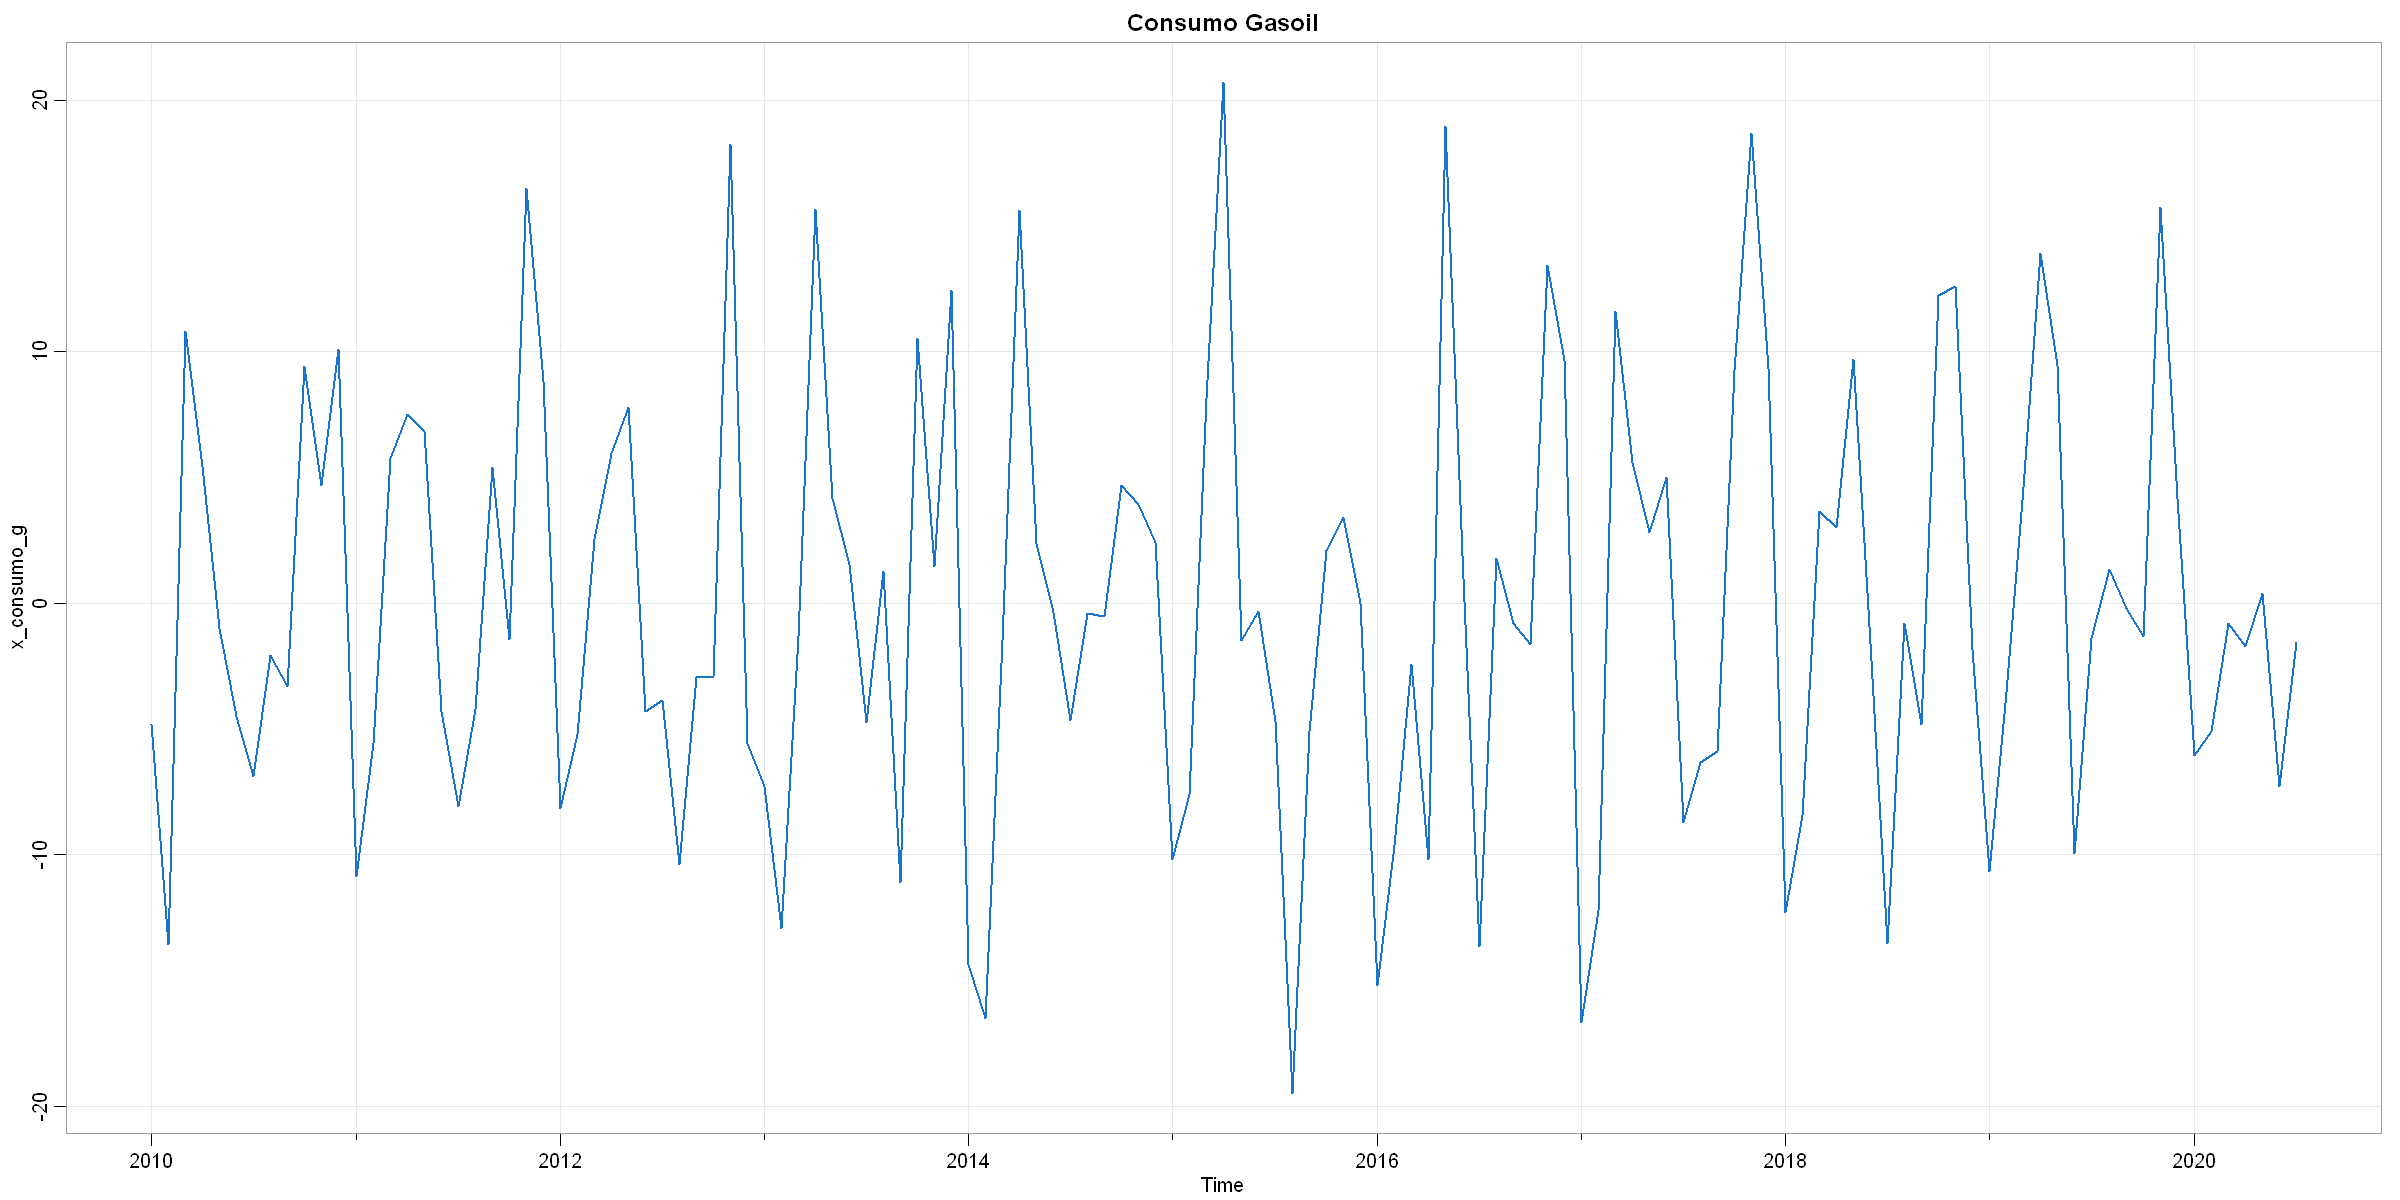

In [87]:
tsplot(x_area_c, main = 'Area Cultivos', col = 4, lwd = 2)
tsplot(x_consumo_g, main = 'Consumo Gasoil', col = 4, lwd = 2)

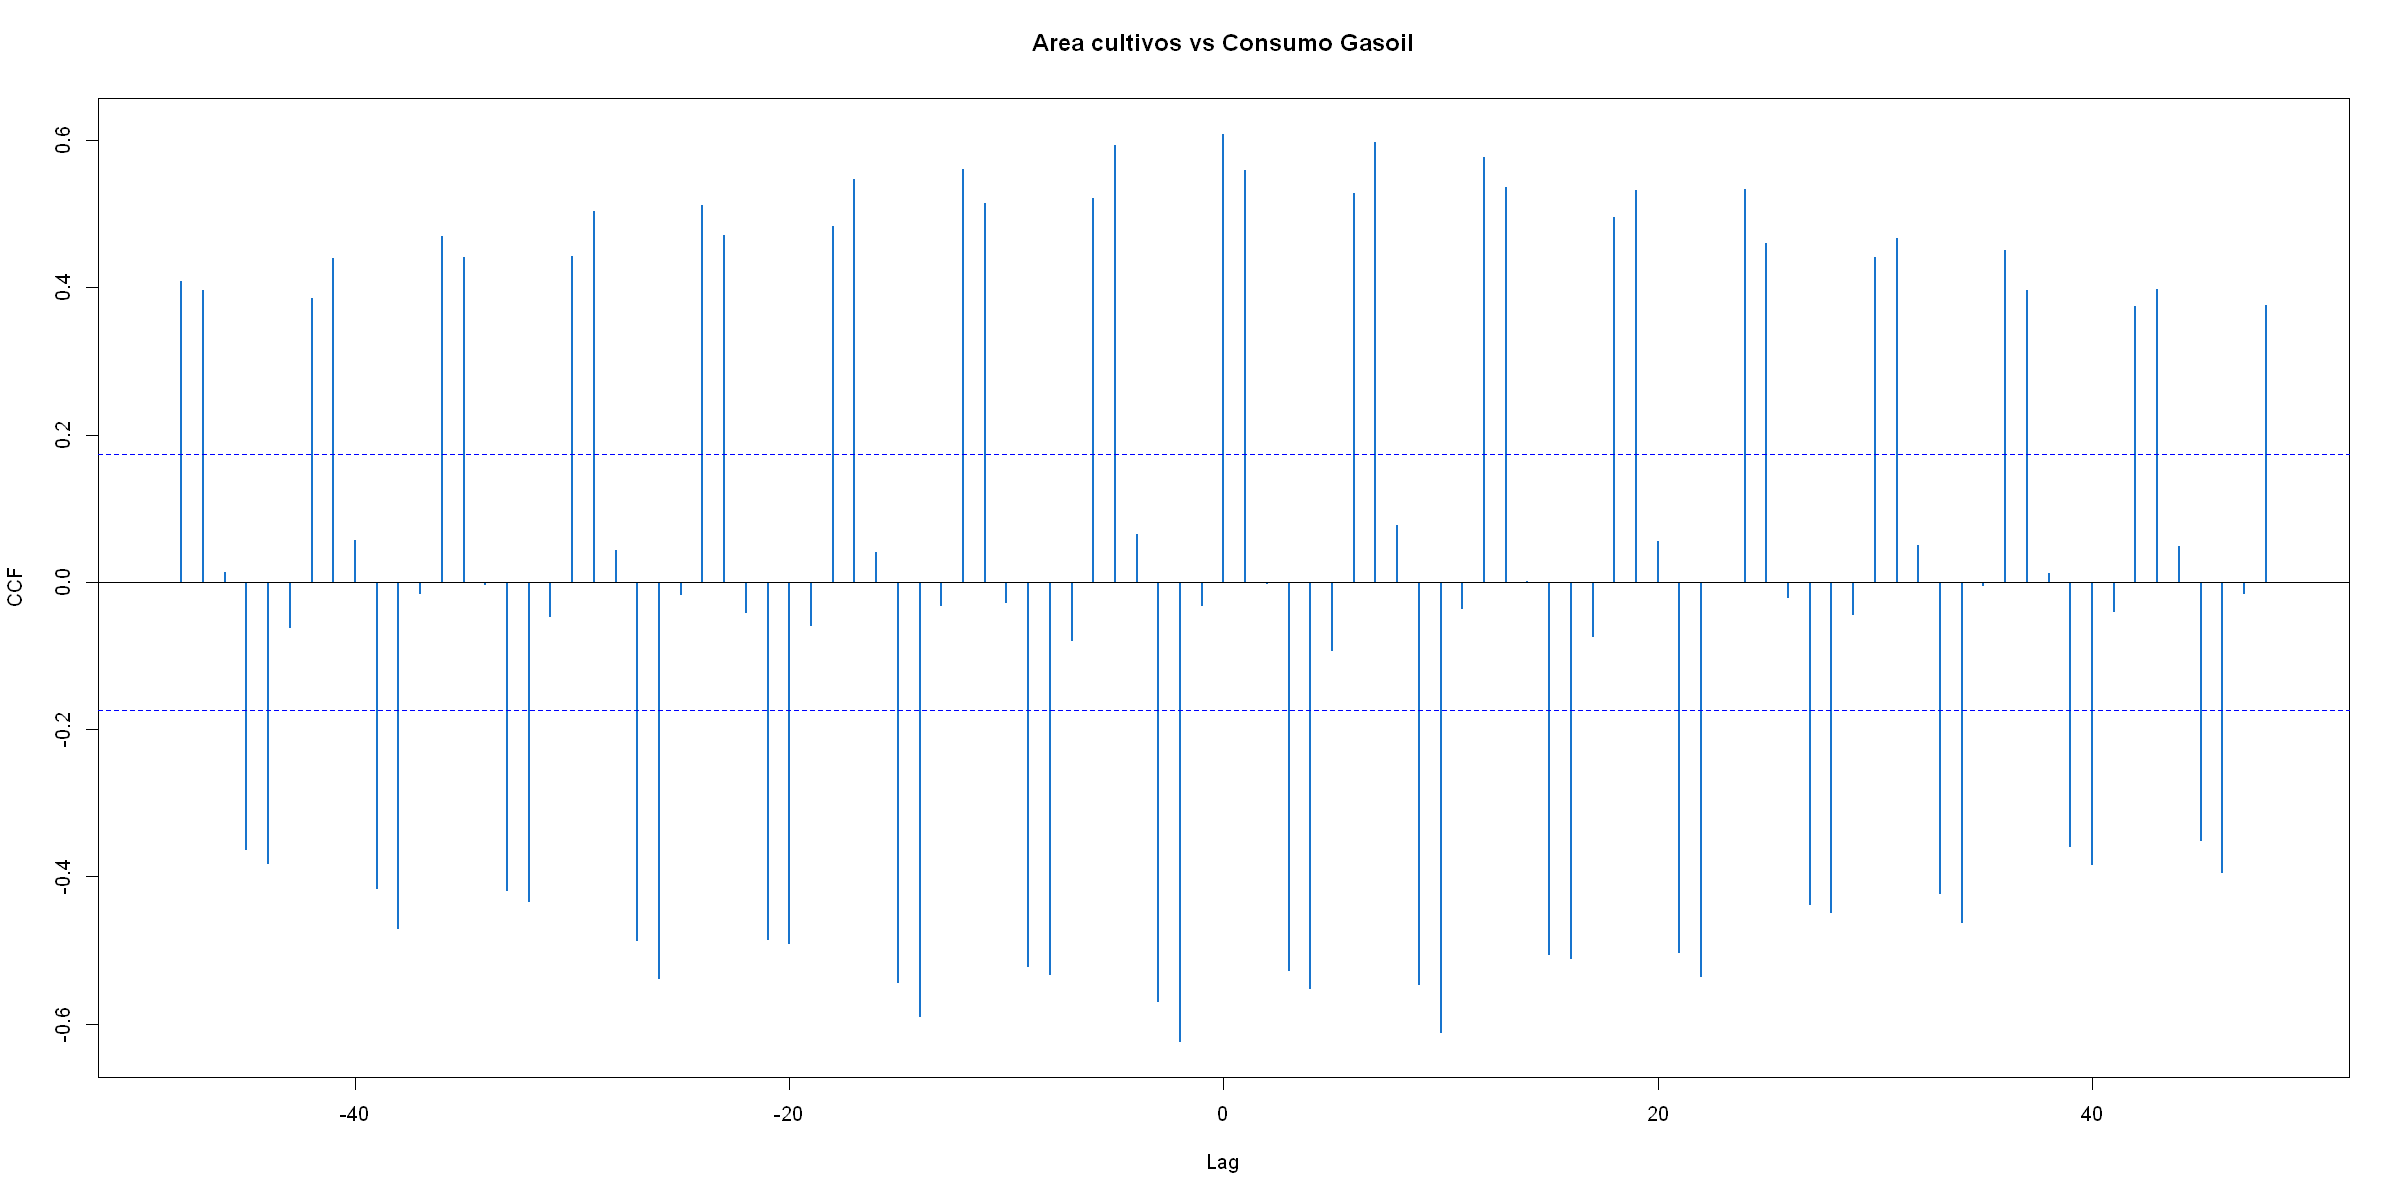

In [88]:
ccf(ts(x_area_c),ts(x_consumo_g),48,main = 'Area cultivos vs Consumo Gasoil', ylab = "CCF", col = 4, lwd = 2)

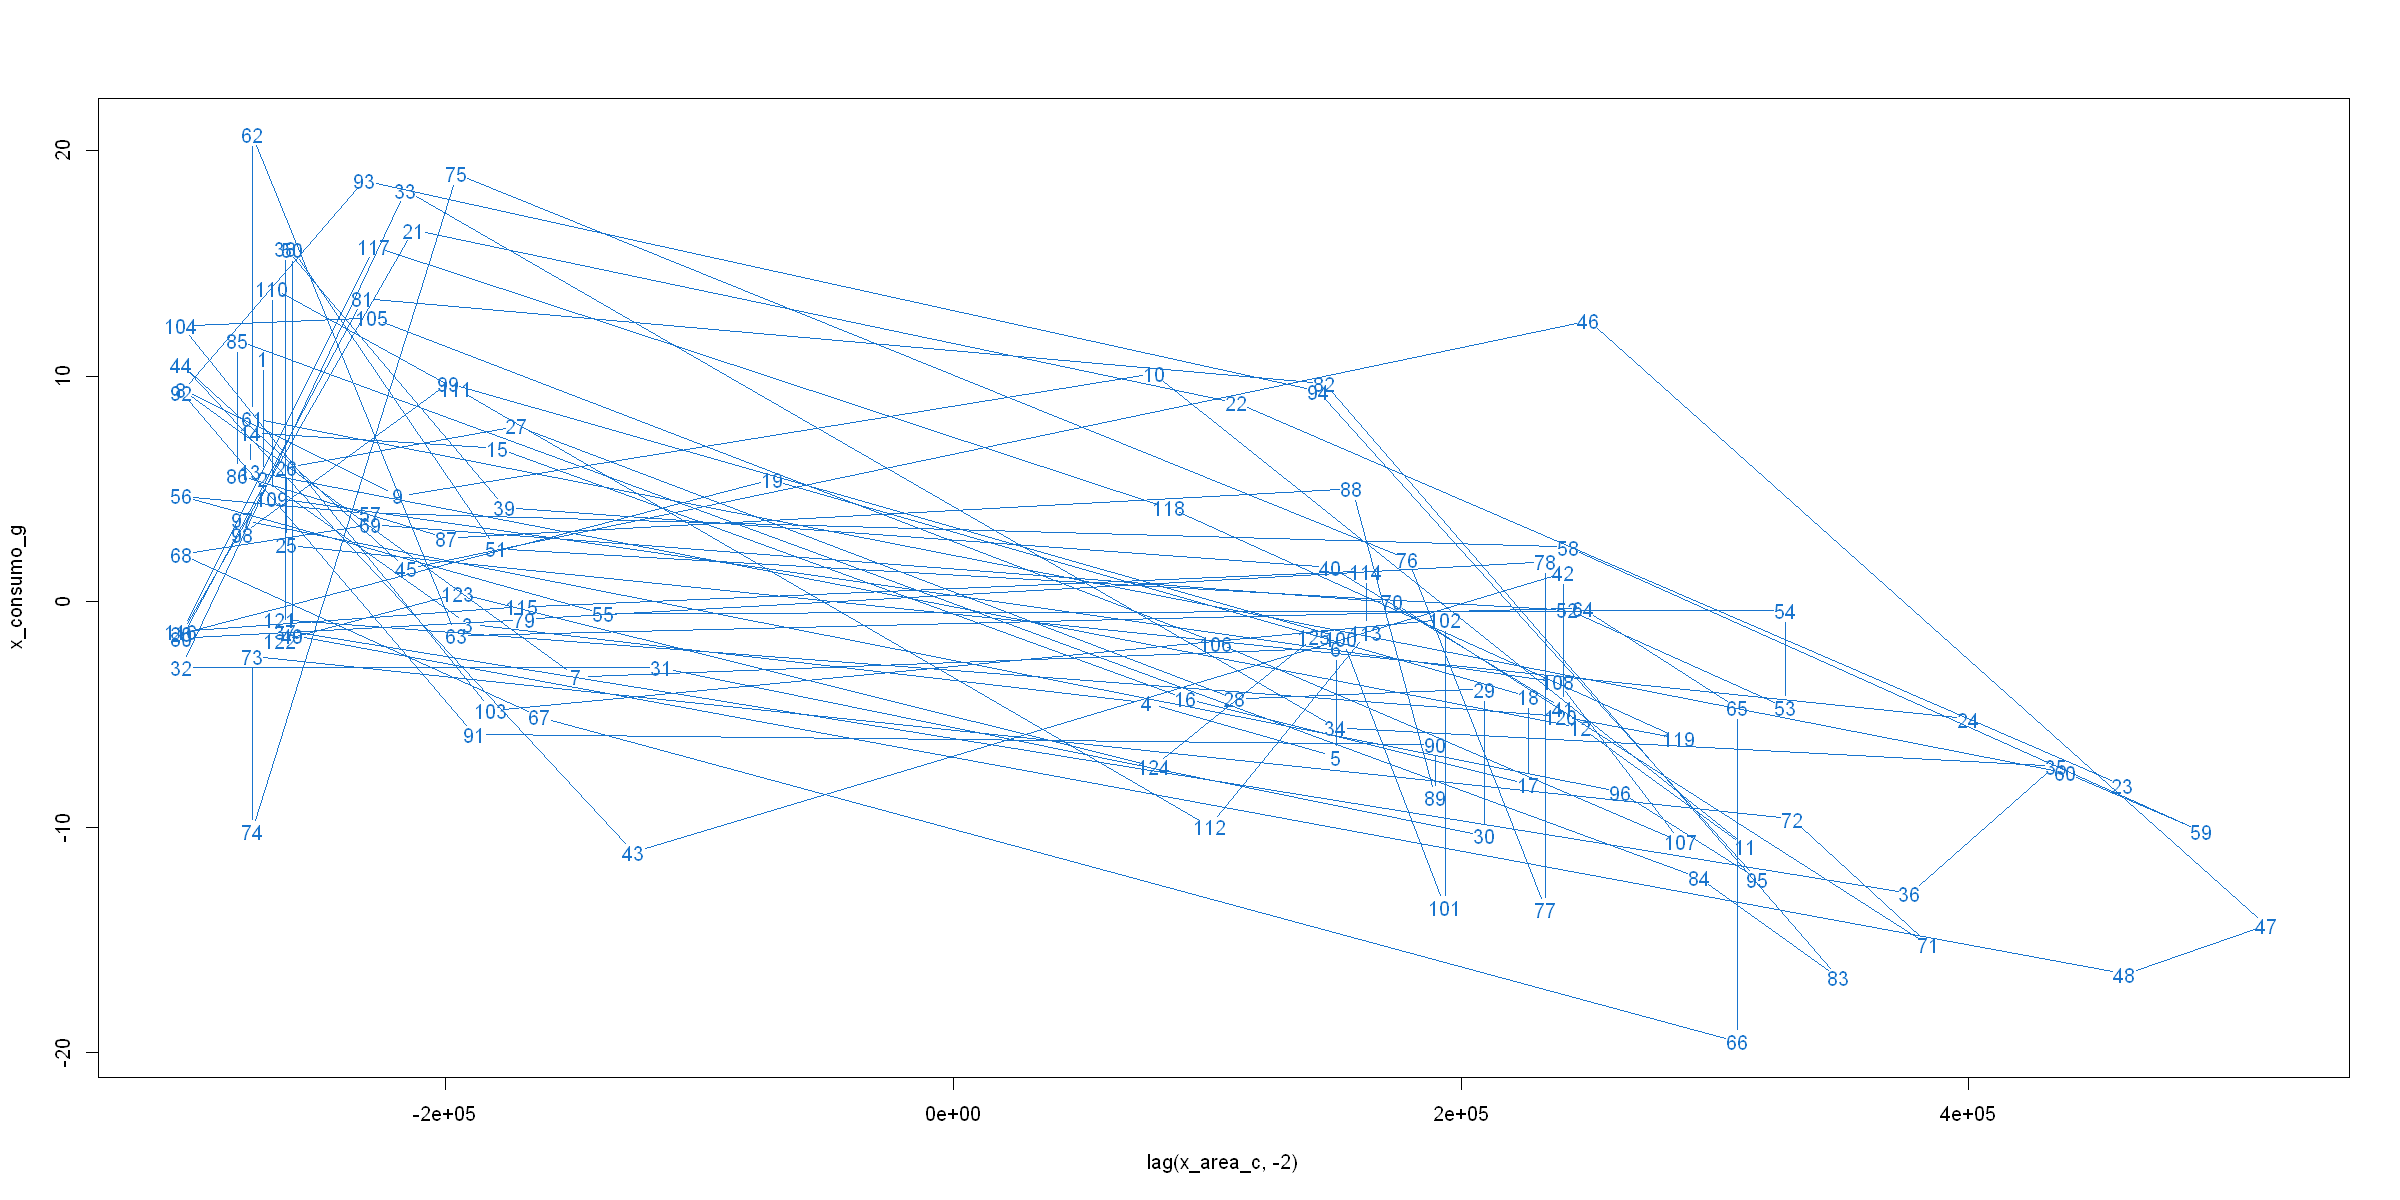

In [89]:
plot(lag(x_area_c,-2), x_consumo_g, col = 4)

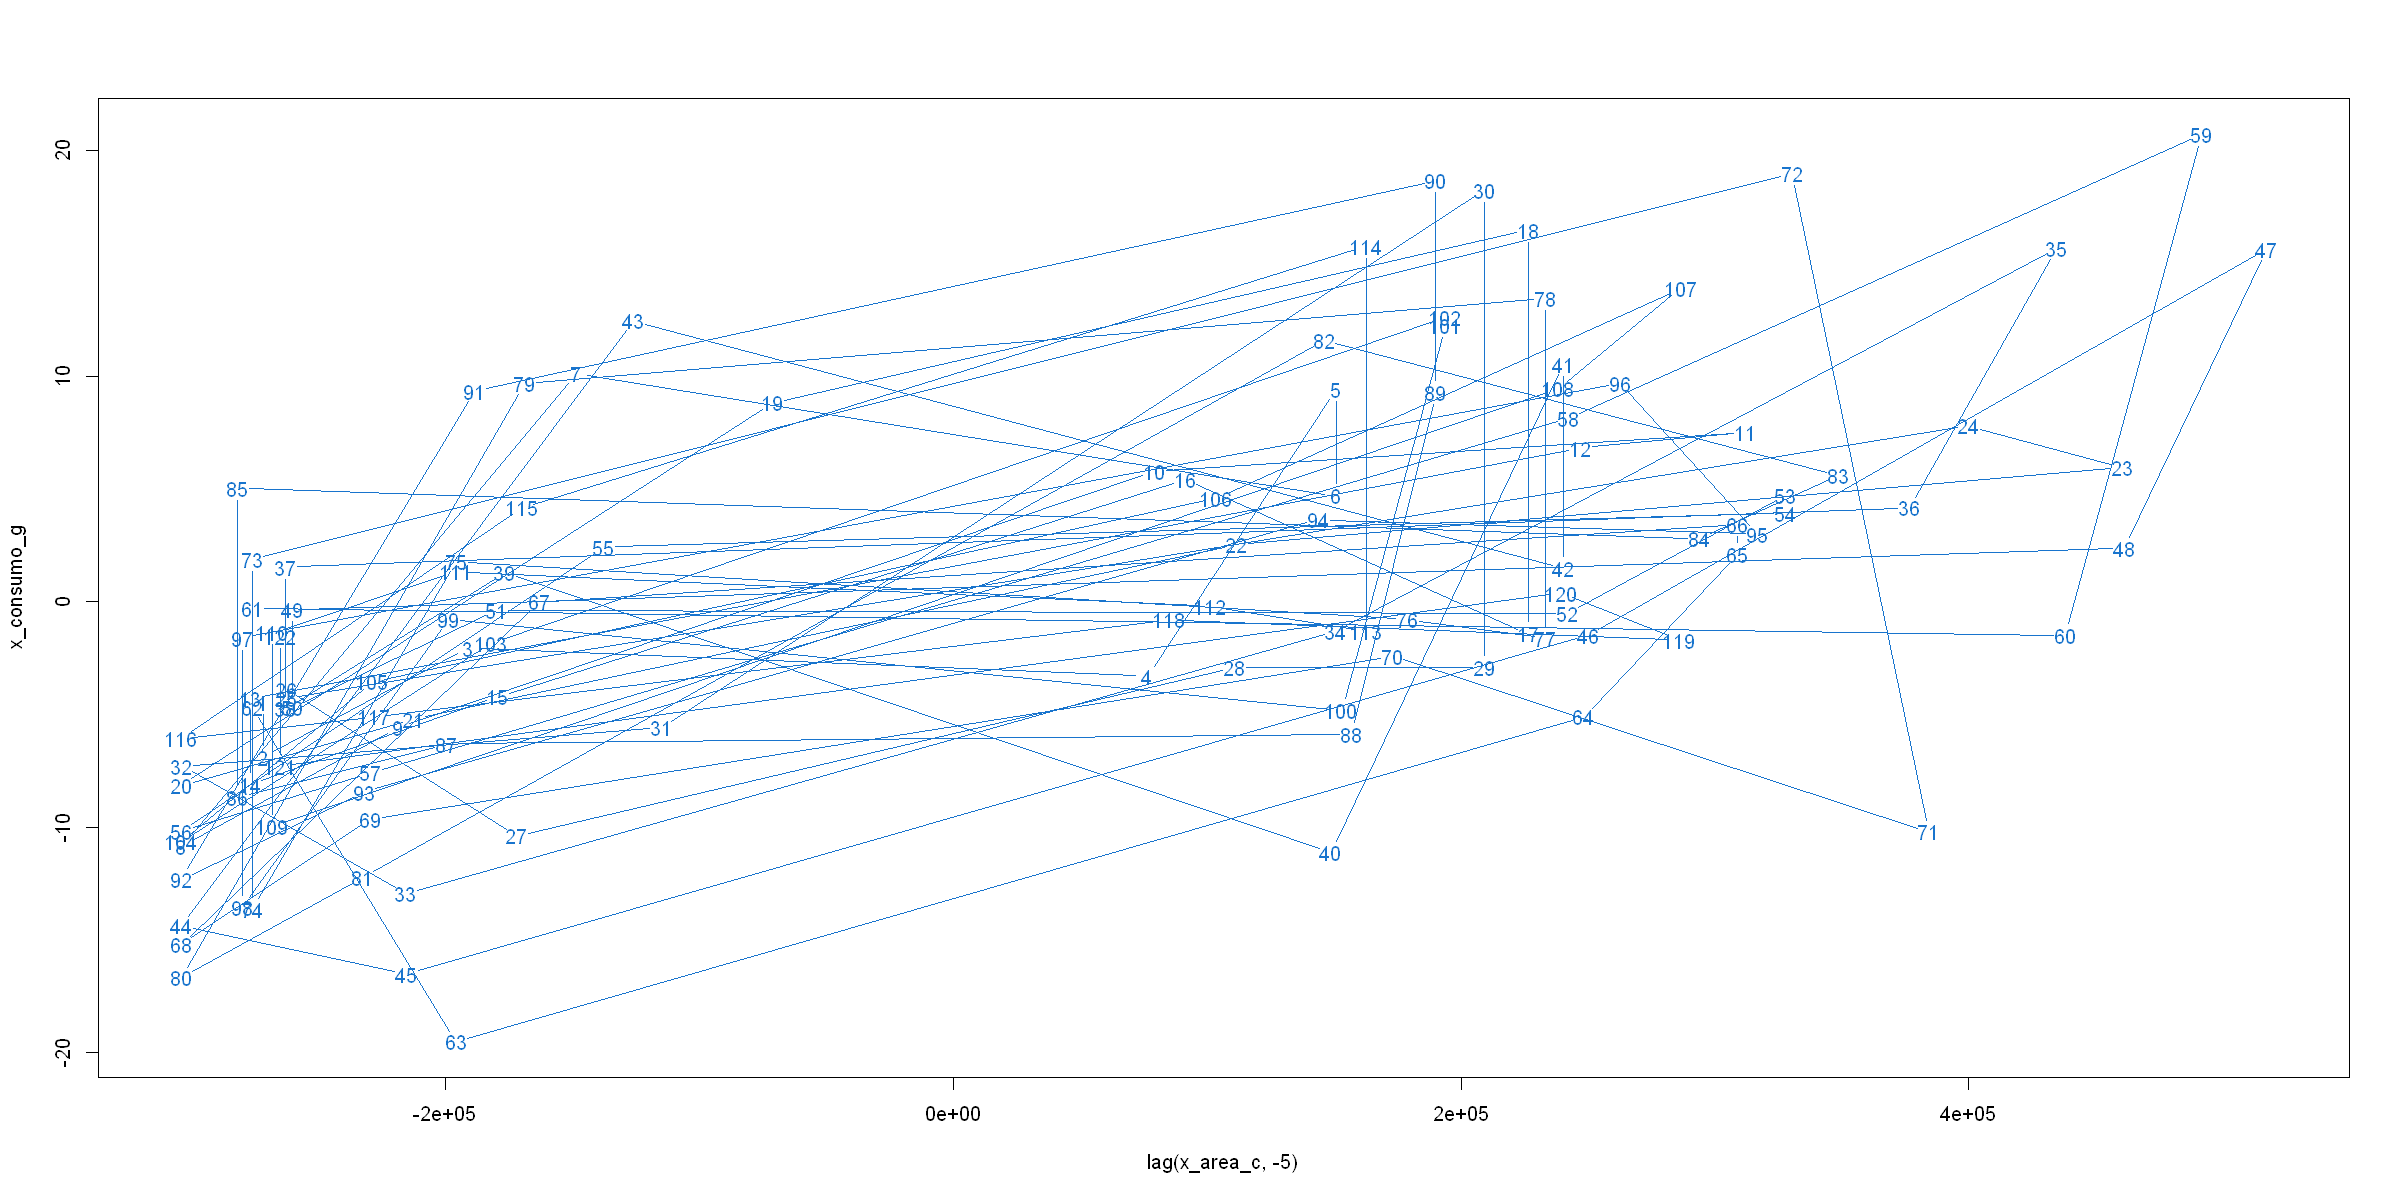

In [90]:
plot(lag(x_area_c,-5), x_consumo_g, col = 4)

REALIZACIÓN DE UN AJUSTE PARA EXPLICAR UNA SERIE A PARTIR DE OTRA (SE USA INTERSECT Y UN DATAFRAME): En este caso, usamos las series “x_consumo_g” y “x_area_c”

REALIZACIÓN DEL AJUSTE para explicar “x_consumo_g” a partir de “x_area_c” corrida 5 meses hacia atrás:
Creamos un dataframe de nombre “df” con las dos columnas alineadas que contienen los datos necesarios para hacer la correlación cruzada:


In [91]:
df = ts.intersect(x_consumo_g, area_total_5 = lag(x_area_c,-5), dframe = TRUE)

A continuación, tratamos de explicar “x_consumo_g” a partir de “area_total_5” tomando los datos del dataframe “df” que le pasamos:

In [92]:
fit_cc1 = lm(x_consumo_g ~ 0 + area_total_5, data = df, na.action = NULL)
summary(fit_cc1)


Call:
lm(formula = x_consumo_g ~ 0 + area_total_5, data = df, na.action = NULL)

Residuals:
     Min       1Q   Median       3Q      Max 
-18.0770  -4.5133  -0.4821   4.8141  15.0296 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
area_total_5 2.050e-05  2.422e-06   8.466 7.02e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.805 on 121 degrees of freedom
Multiple R-squared:  0.372,	Adjusted R-squared:  0.3668 
F-statistic: 71.67 on 1 and 121 DF,  p-value: 7.016e-14


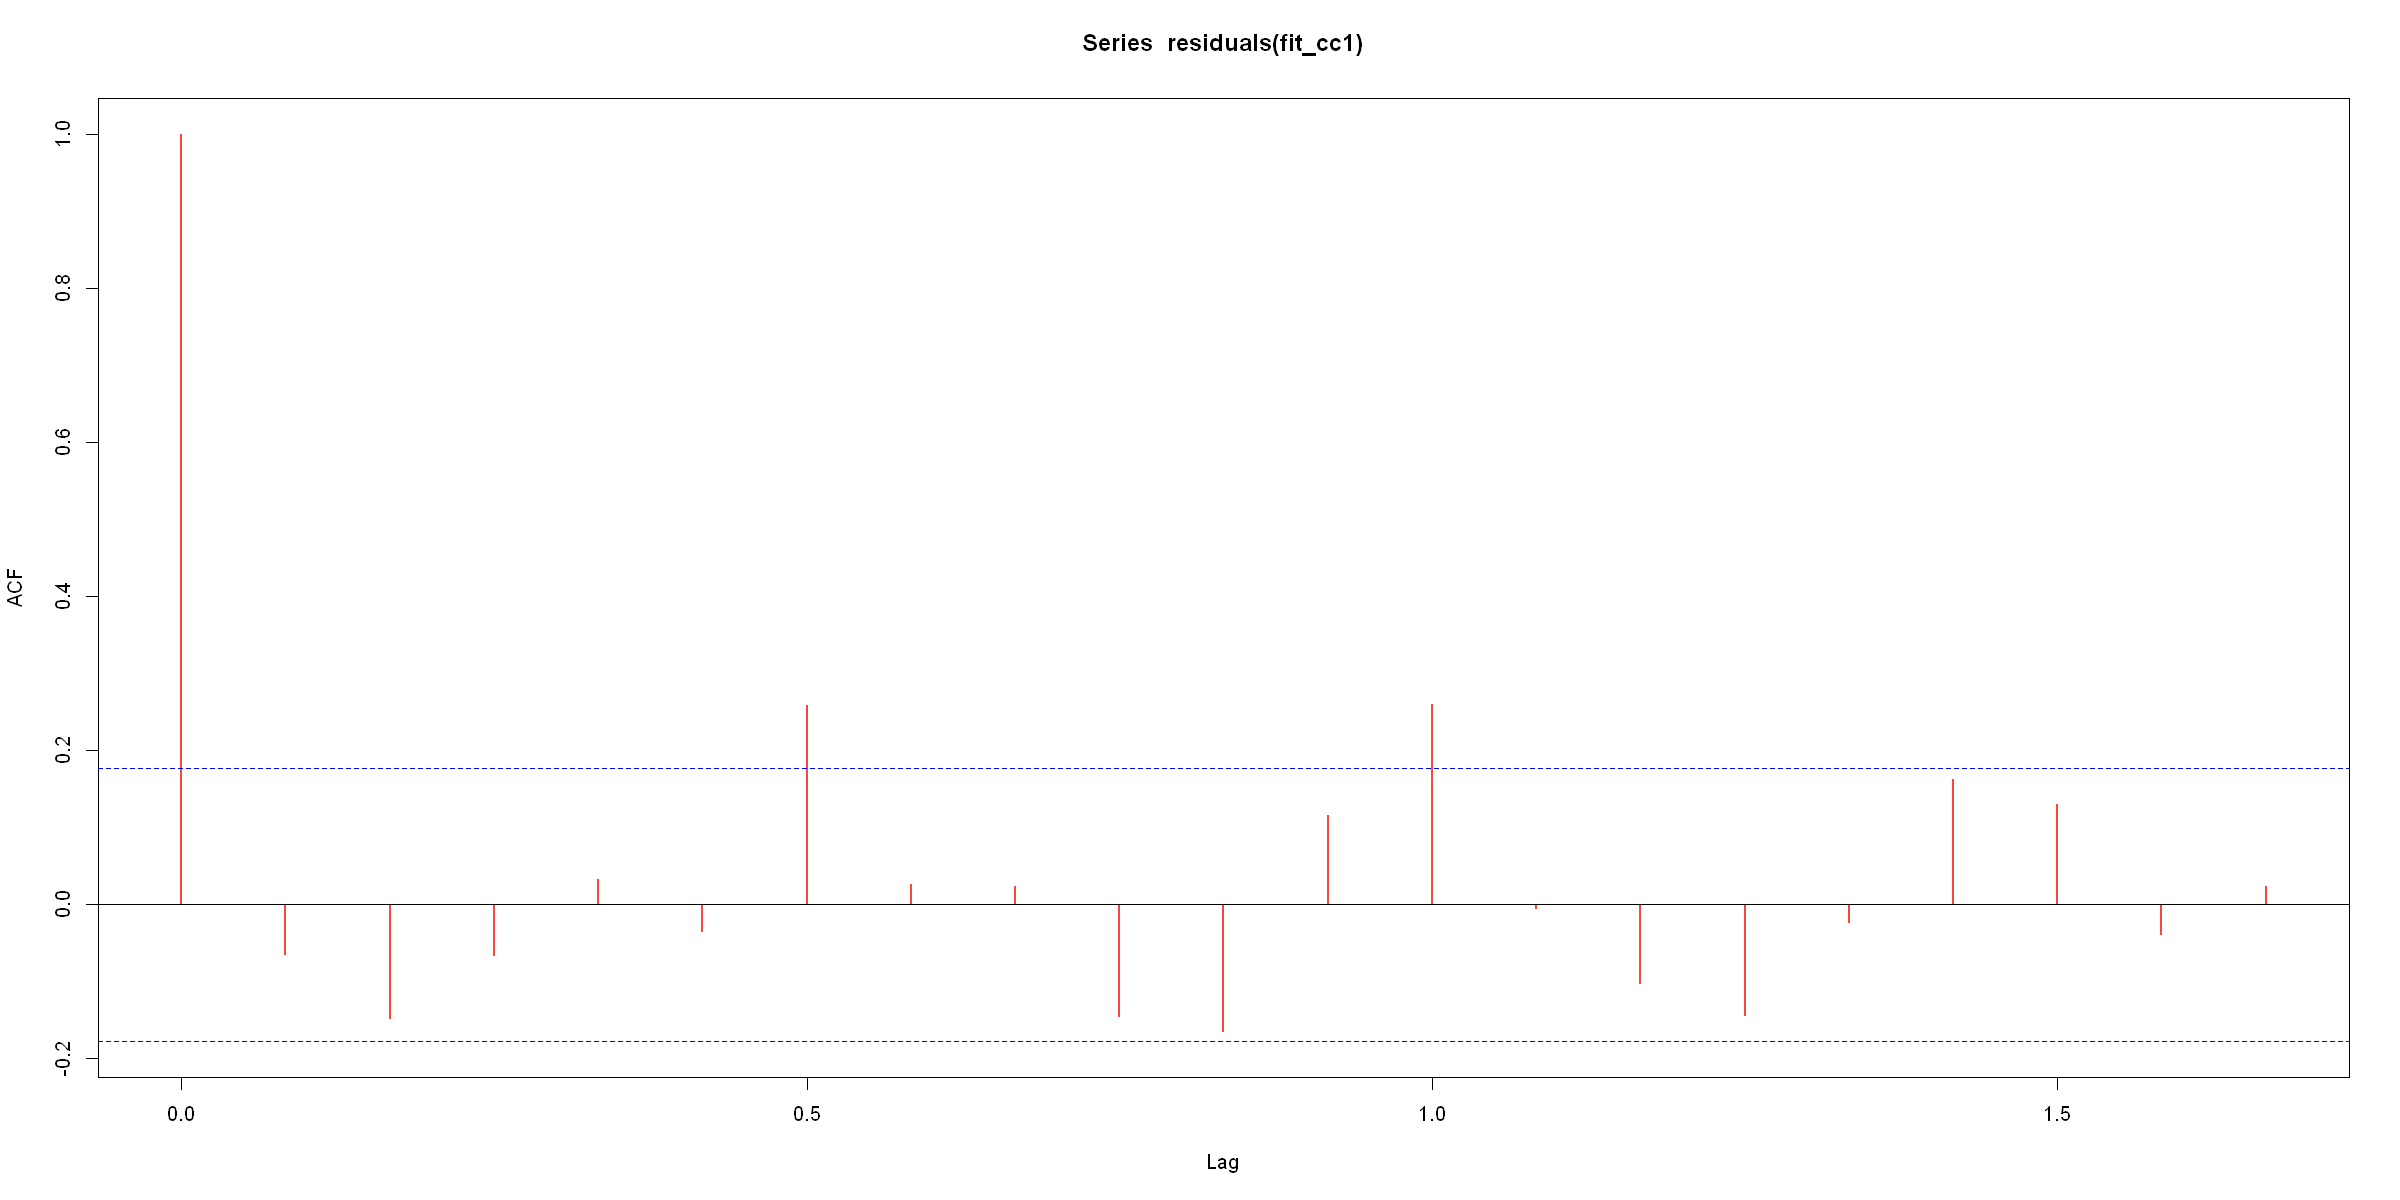

In [93]:
acf(residuals(fit_cc1), col = 2, lwd = 2)

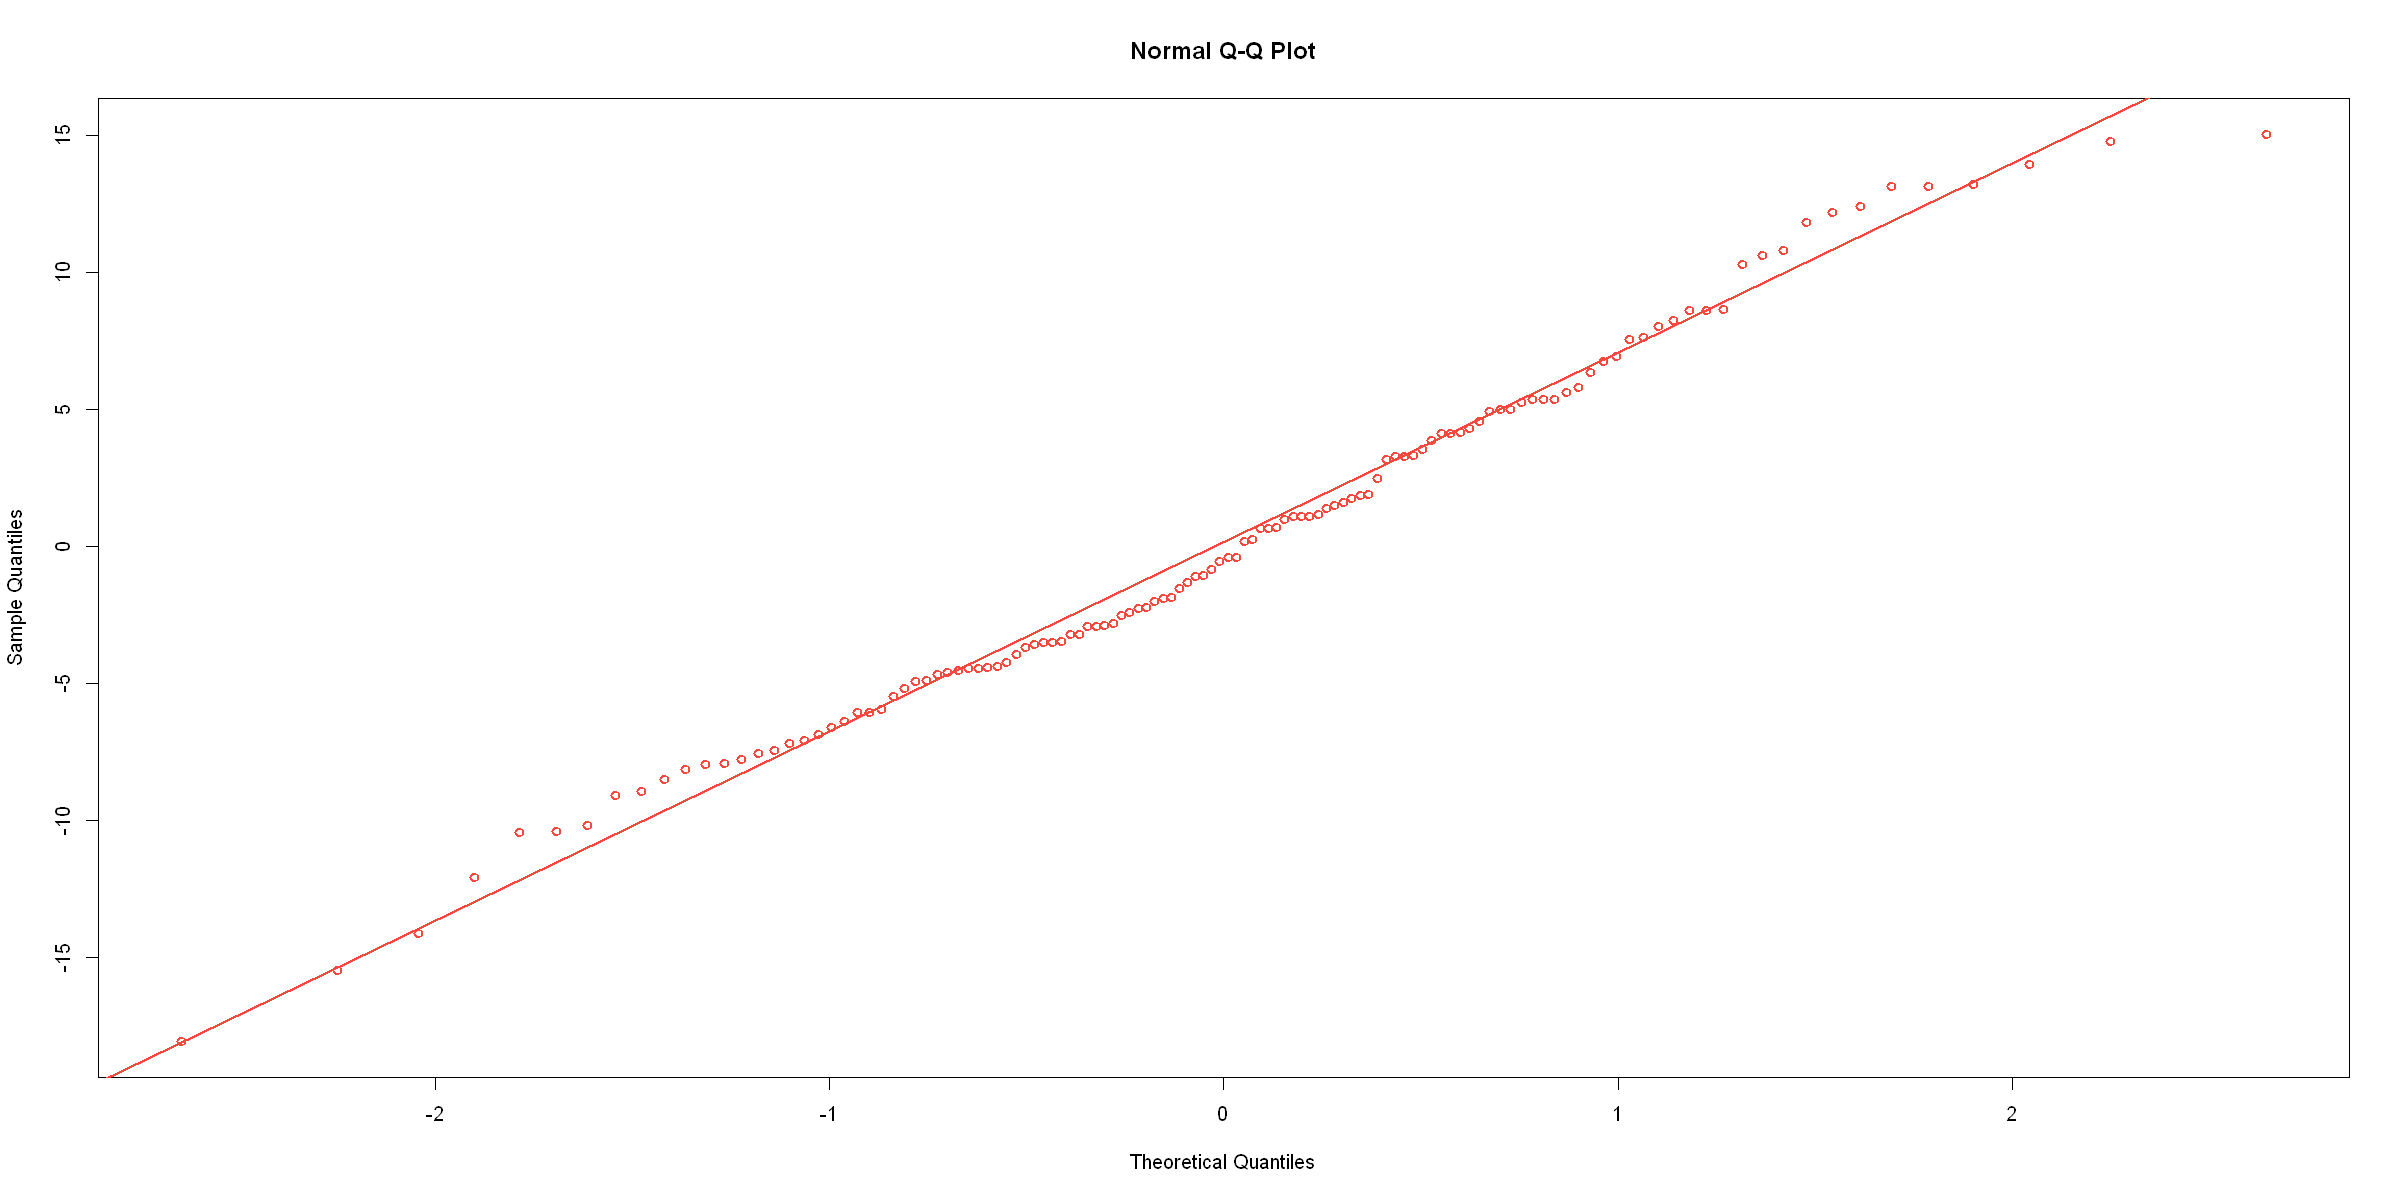

In [94]:
qqnorm(residuals(fit_cc1), col = 2,lwd = 2)
qqline(residuals(fit_cc1), col = 2,lwd = 2)

A continuación probaremos agregar a "df" las frecuencias de senos y cosenos que obtuvimos del periodograma y volver a relizar un ajuste del consumo de gasoil con "area_total_5":

In [95]:
time = time(x_consumo_g) - 2010

In [96]:
df2 = ts.intersect(x_consumo_g, area_total_5 = lag(x_area_c, -5), cos2 = cos(2*pi*(2)*time), sen2 = sin(2*pi*(2)*time), cos3 = cos(2*pi*(3)*time), sen3 =  sin(2*pi*(3)*time), dframe = TRUE)

In [97]:
fit_cc2 = lm(x_consumo_g ~ 0 + area_total_5  + cos2 + sen2 + cos3 + sen3, data = df2, na.action = NULL)
summary(fit_cc2)


Call:
lm(formula = x_consumo_g ~ 0 + area_total_5 + cos2 + sen2 + cos3 + 
    sen3, data = df2, na.action = NULL)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.9562  -3.3325   0.2527   4.3421  14.1578 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
area_total_5 -2.270e-06  6.898e-06  -0.329 0.742743    
cos2         -7.936e+00  2.433e+00  -3.262 0.001452 ** 
sen2         -4.727e+00  7.631e-01  -6.195 8.96e-09 ***
cos3         -2.505e+00  7.270e-01  -3.446 0.000792 ***
sen3         -2.693e+00  8.150e-01  -3.304 0.001266 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 5.646 on 117 degrees of freedom
Multiple R-squared:  0.5819,	Adjusted R-squared:  0.5641 
F-statistic: 32.57 on 5 and 117 DF,  p-value: < 2.2e-16


Consideramos que no tiene sentido continuar este análisis, ya que a partir de los resultados de este ajuste vemos que "area_total_5" se volvió un coeficiente no significativo. 

La explicación de esto subyace probablemente, en que si hubieramos querido ajustar la serie "area_total_5" por senos y cosenos con las mismas frecuencias (2, 3 y 4.2), también hubiesemos encontrado un buen ajuste. Es decir, si suponemos que "area_total_5" correlaciona bien con senos y cosenos, y a su vez, nuestra serie de consumo de gasoil (que también correlaciona bien con senos y cosenos) la tomamos como "area_total_5" por un número, entonces, estamos repitiendo los senos y cosenos dos veces (una por el lado de "area_total_5" y otra por agregarlos directamente). A consecuencia de esto, la regresión descarta uno de ellos y queda no significativo.

En otras palabras, la posible relación de causalidad entre el "area_total_5" y el consumo de gasoil vendría dada por las estaciones del año, pero entonces, al agregarle tales estaciones a la regresión, esta atribuyó la causalidad a tales estaciones, descartando "area_total_5" en sí misma.

Como consecuencia, decidimos no continuar el análisis por este lado.

La propia periodicidad de las series de consumo de gasoil y área de cultivo hace que estas se vuelvan a correlacionar, sin embargo, la correlación fuerte entre ambas series es simultánea. Por este motivo probaremos realizar un ajuste del consumo de gasoil, sin laguear ninguna de las series:

In [98]:
fit_cc3 = lm(x_consumo_g ~ 0 + x_area_c)
summary(fit_cc3)


Call:
lm(formula = x_consumo_g ~ 0 + x_area_c)

Residuals:
     Min       1Q   Median       3Q      Max 
-13.9049  -4.9439  -0.3304   4.7473  15.7264 

Coefficients:
          Estimate Std. Error t value Pr(>|t|)    
x_area_c 2.070e-05  2.407e-06   8.603 2.62e-14 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 6.81 on 126 degrees of freedom
Multiple R-squared:   0.37,	Adjusted R-squared:  0.365 
F-statistic: 74.01 on 1 and 126 DF,  p-value: 2.62e-14


Observamos que el R cuadrado obtenido es de 37%, practicamente igual al que obtuvimos considerando la serie "area_total_5", en el ajuste fit_cc1.

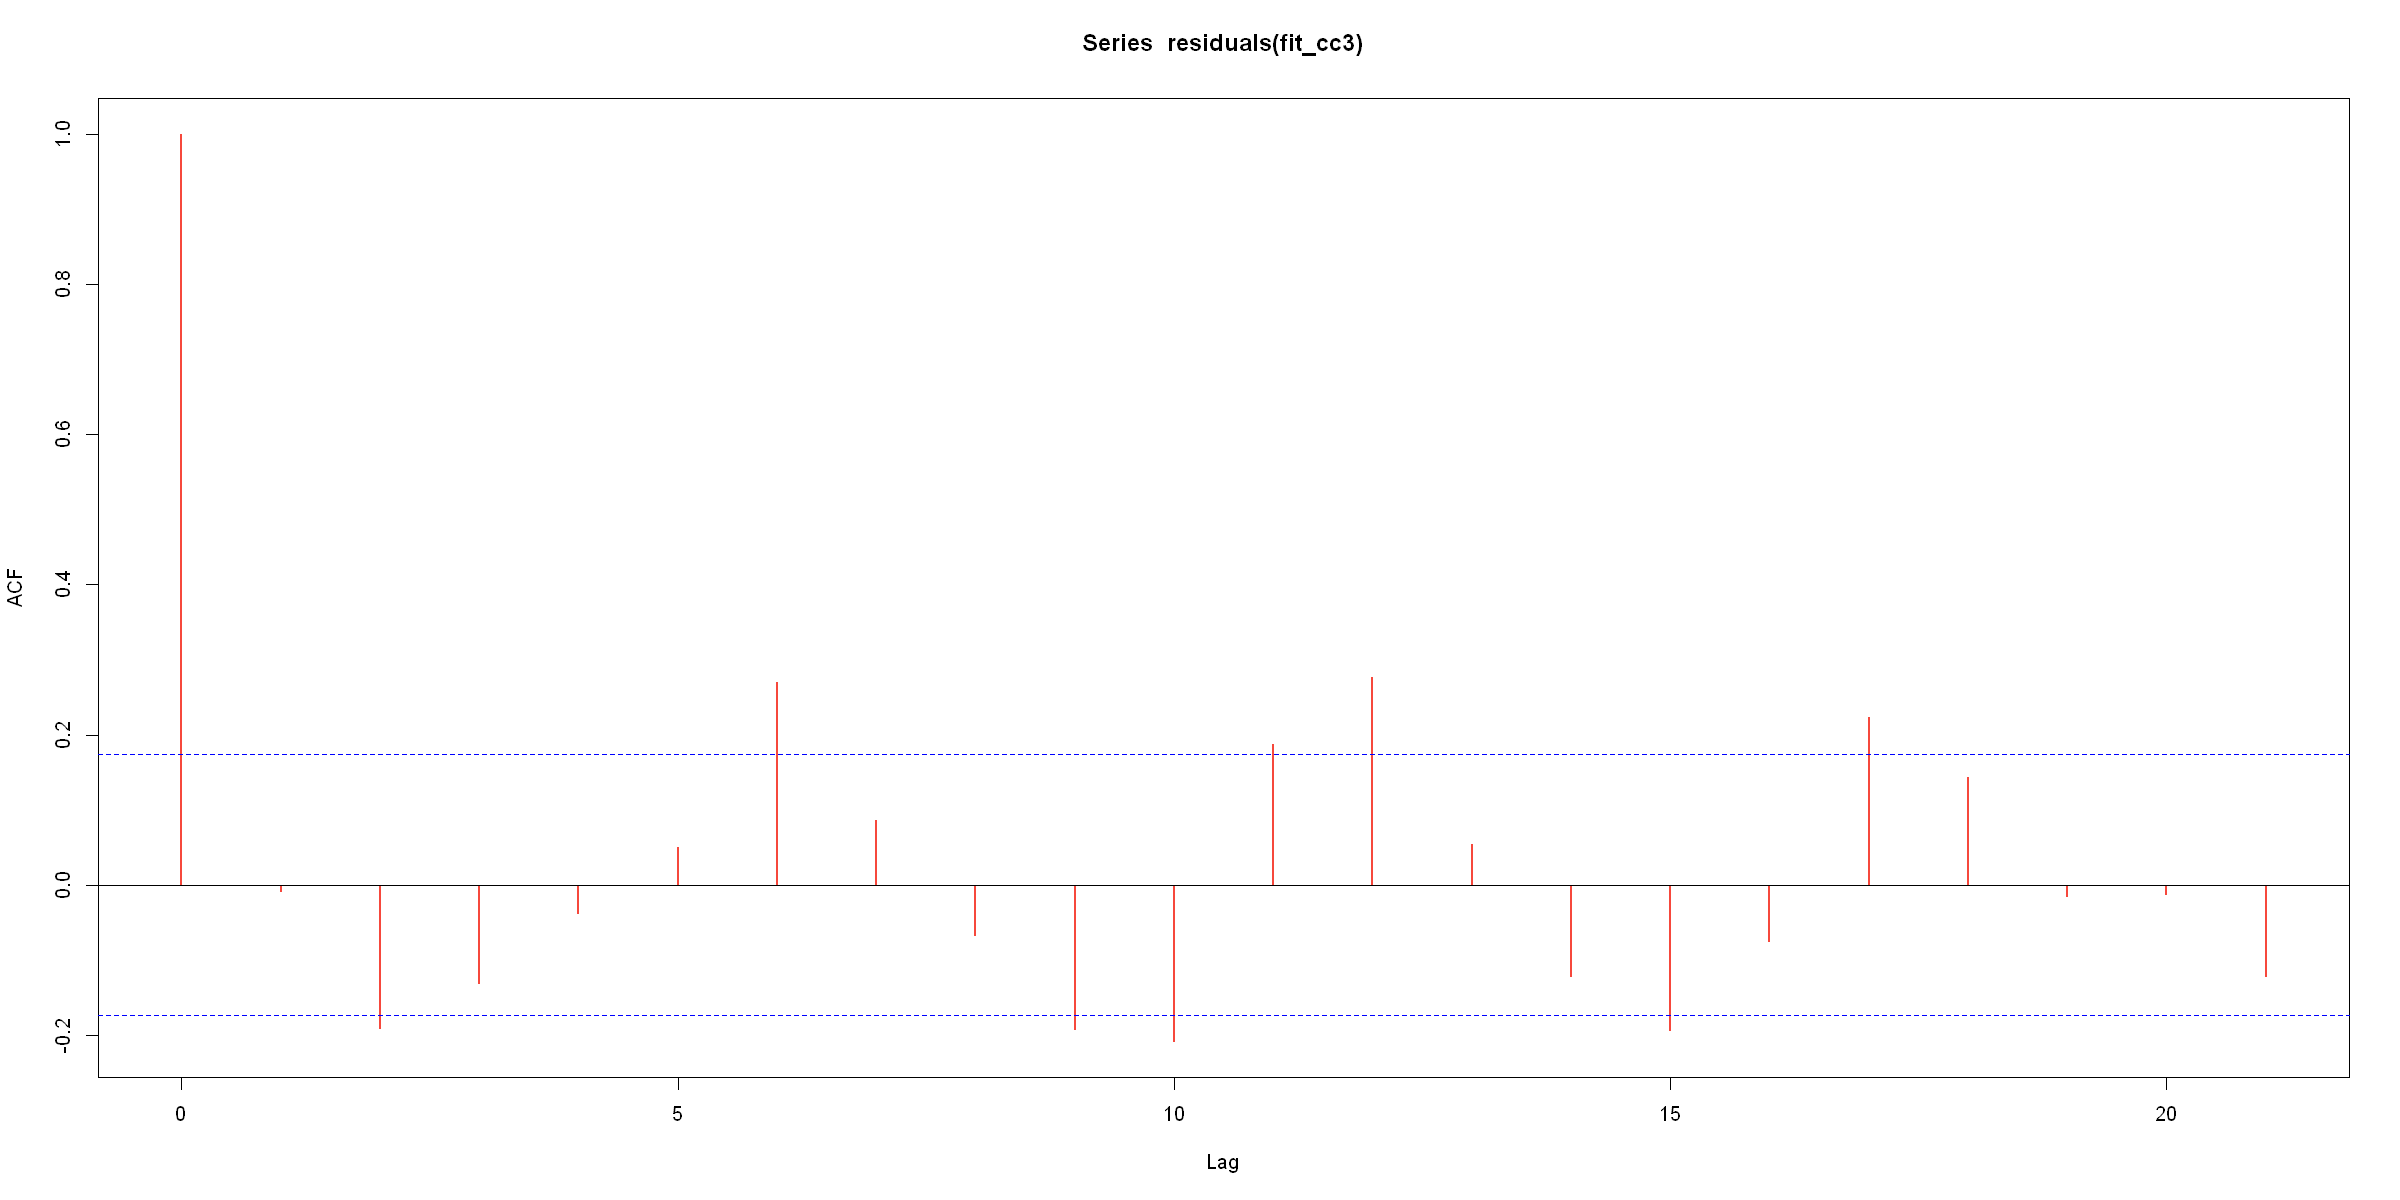

In [99]:
acf(residuals(fit_cc3), col = 2, lwd = 2)

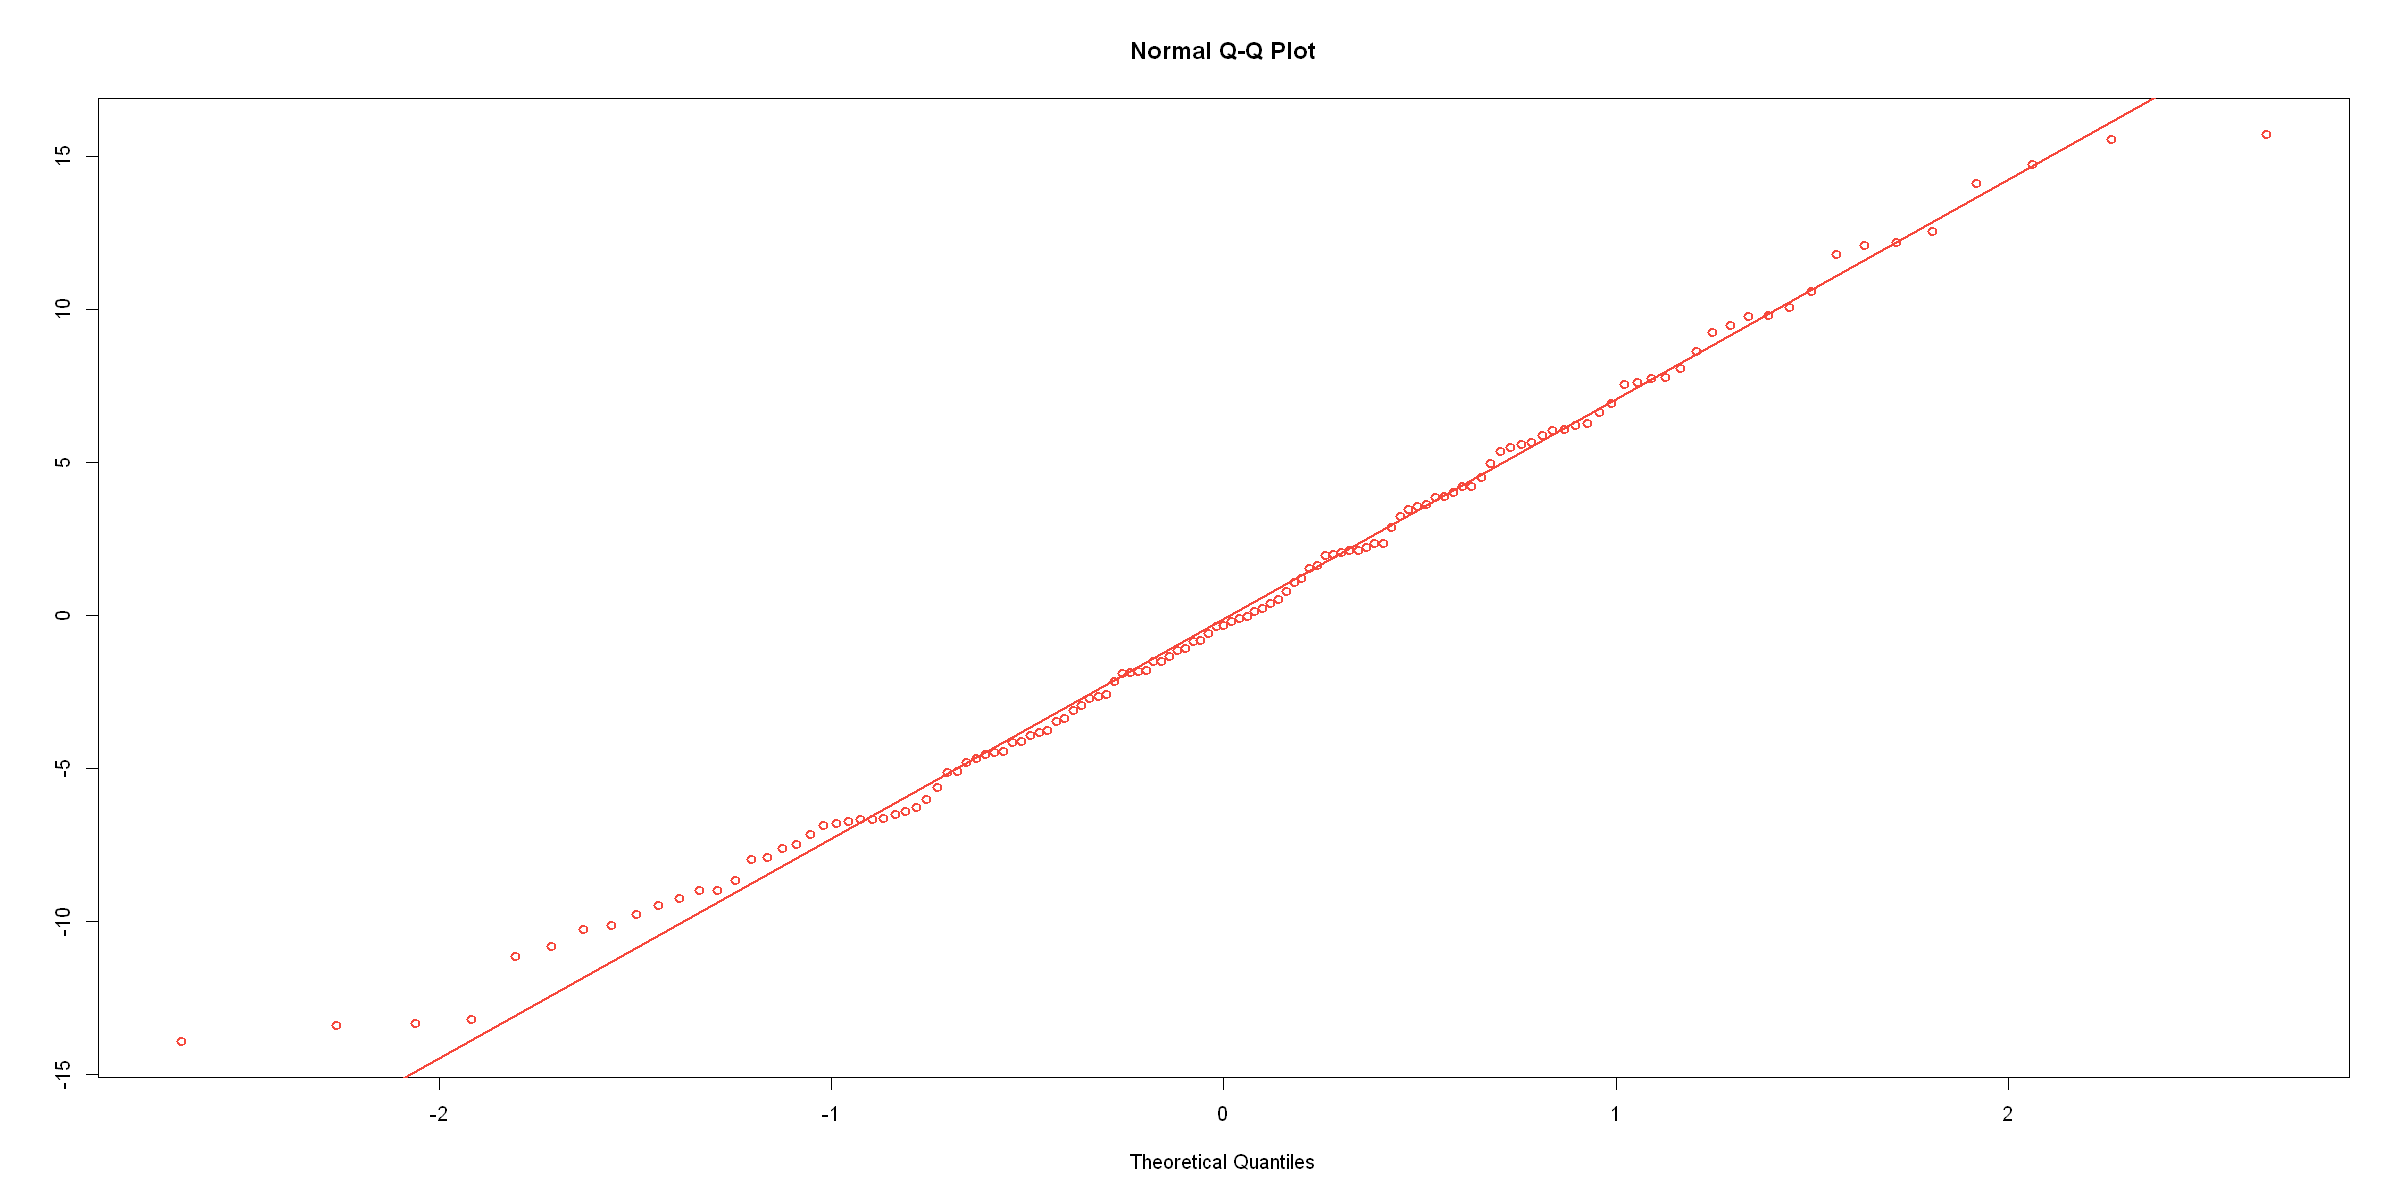

In [100]:
qqnorm(residuals(fit_cc3), ylab = '', col = 2,lwd = 2)
qqline(residuals(fit_cc3), col = 2,lwd = 2)